In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame as df
from IPython.display import display
import re
from collections import Counter
import missingno as msno

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.decomposition import PCA

In [2]:
# *load data*
train_data=pd.read_csv('../porto-seguro-data/train.csv')

In [3]:
# *split data into X and y*
y=df(train_data['target'],columns=['target'])
X=train_data.drop(['target','id'],axis=1)

### 1) Spot-Check Data

In [ ]:
# data types
#print('Train Data Types:\n{}\n'.format(train_data.dtypes))

In [ ]:
# check class (im)balance 
#labels = train_data.groupby('target').size()
#print('Target Variable: {}'.format(labels))

In [6]:
# claim-free %
1-y.mean()

target    0.963552
dtype: float64

In [ ]:
# check skewness of input variables
#print('Input Variables:\n{}'.format(X_imp.skew())) # (+) right skewed and (-) left skewed

### 2) Prepare Data
Reasons for splitting the dataset into various subsets for exploratory analysis:
* there're too many attributes to view at once
* intuitively, given it's car insurance, some attributes should be more correlated than others (e.g. attributes about individuals `'_Ind'` versus cars `'_Car'`) 
* split by data type, such as categorical and continuous, for different treatment in certain functionalities (e.g. `'DecisionTreeClassifier'` vs. `'DecisionTreeRegressor'`) and visualizations

Dataset is split by source of attribute (individual vs. region vs. car), data type (binary vs. categorical vs. ordinal vs. continuous, and integer vs. float), and various combinations of both when needed. Code for splitting dataset is below:

In [4]:
# column names split by Individual vs. Car vs. Region (vs. Calc)
ind_col=[col for col in X.columns if '_ind_' in col]
car_col=[col for col in X.columns if '_car_' in col]
reg_col=[col for col in X.columns if '_reg_' in col]
calc_col=[col for col in X.columns if '_calc_' in col]

# column names split by Binary, Categorical, Ordinal vs. Continuous
bin_col=[col for col in X.columns if '_bin' in col]
cat_col=[col for col in X.columns if '_cat' in col]
temp=[col for col in X.columns if '_cat' not in col and '_bin' not in col]

In [5]:
# make separate and combined dataframes for groupings identified above
# dataframes by Individual vs. Car vs. Region (vs. Calc) 
X_ind=X[ind_col]
X_car=X[car_col]
X_reg=X[reg_col]
X_calc=X[calc_col]
# further split by Integer vs. Float for 'relevance_score' function (regressor vs. classifier)
X_car_integer=X_car.select_dtypes(include=['int64'])
X_car_float=X_car.select_dtypes(include=['float64'])
X_calc_integer=X[calc_col].select_dtypes(include=['int64'])
X_calc_float=X[calc_col].select_dtypes(include=['float64'])
# combining subsets for correlations
X_ind_car=pd.concat([X_ind,X_car],axis=1)
X_reg_car=pd.concat([X_reg,X_car],axis=1)
X_ind_reg=pd.concat([X_ind,X_reg],axis=1)
X_ind_calc=pd.concat([X_ind,X_calc],axis=1)
X_reg_calc=pd.concat([X_reg,X_calc],axis=1)
X_car_calc=pd.concat([X_car,X_calc],axis=1)
X_ind_car_reg=pd.concat([X_car,X_reg,X_ind],axis=1)
X_ind_y=pd.concat([X_ind,y],axis=1)
X_car_y=pd.concat([X_car,y],axis=1)
X_reg_y=pd.concat([X_reg,y],axis=1)
X_calc_y=pd.concat([X_calc,y],axis=1)

# dataframes by Binary, Categorical, Ordinal vs. Continuous
X_bin=X[bin_col]
X_cat=X[cat_col]
X_ord=X[temp].select_dtypes(include=['int64'])
X_cont=X[temp].select_dtypes(include=['float64'])
X_bin_y=pd.concat([X_bin,y],axis=1)
X_cat_y=pd.concat([X_cat,y],axis=1)
X_ord_y=pd.concat([X_ord,y],axis=1)
X_cont_y=pd.concat([X_cont,y],axis=1)

In [6]:
X=X.replace(-1,np.nan)
null_col=X.isnull().sum()
X_na=X.filter(null_col[null_col!=0].index)

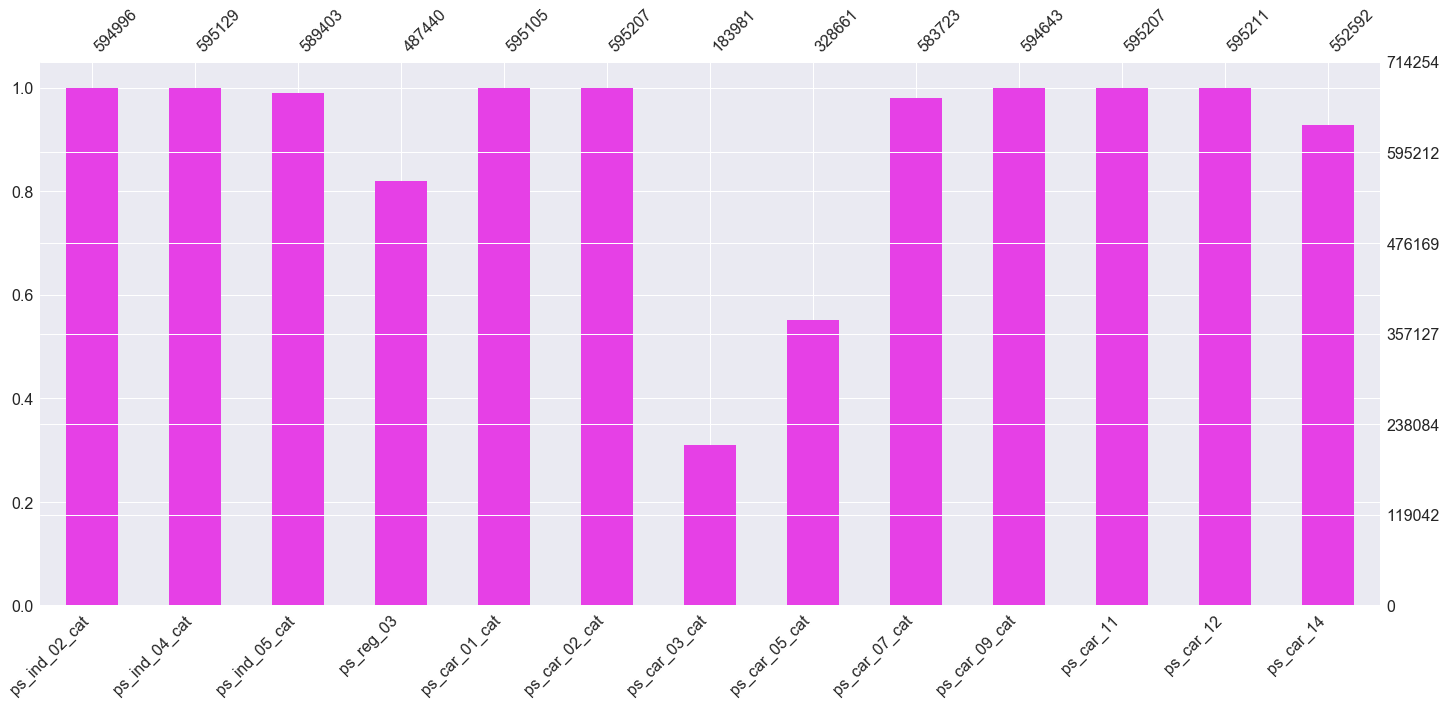

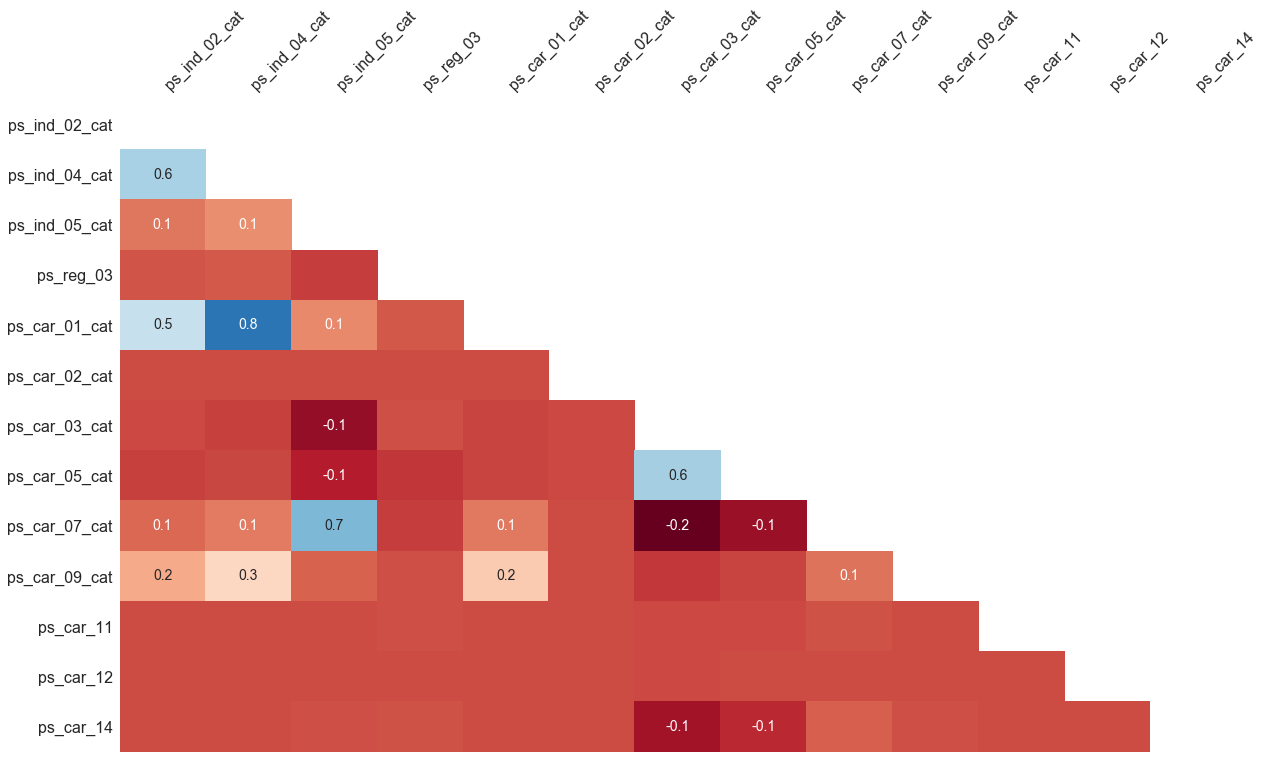

In [7]:
# Nullity or missing values by columns
msno.bar(X_na,color=(0.9,0.25,0.9))
msno.heatmap(X_na)

In [15]:
train_data['neg_one_sum']=np.sum((train_data[train_data.columns]==-1).values,axis=1)
display(train_data.transpose())
Counter(train_data['neg_one_sum'])

,0,1,2,3,4,5,6,7,8,9,...,595202,595203,595204,595205,595206,595207,595208,595209,595210,595211
id,7.000000,9.000000,13.000000,16.000000,17.000000,19.000000,20.000000,22.000000,26.000000,28.000000,...,1.488001e+06,1.488005e+06,1.488008e+06,1.488009e+06,1.488011e+06,1.488013e+06,1.488016e+06,1.488017e+06,1.488021e+06,1.488027e+06
target,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ps_ind_01,2.000000,1.000000,5.000000,0.000000,0.000000,5.000000,2.000000,5.000000,5.000000,1.000000,...,4.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,5.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00
ps_ind_02_cat,2.000000,1.000000,4.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00
ps_ind_03,5.000000,7.000000,9.000000,2.000000,0.000000,4.000000,3.000000,4.000000,3.000000,2.000000,...,3.000000e+00,3.000000e+00,2.000000e+00,6.000000e+00,2.000000e+00,1.000000e+01,3.000000e+00,1.000000e+01,3.000000e+00,8.000000e+00
ps_ind_04_cat,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
ps_ind_05_cat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ps_ind_06_bin,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
ps_ind_07_bin,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ps_ind_08_bin,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00


Counter({0: 124931,
         1: 156295,
         2: 254982,
         3: 56042,
         4: 2883,
         6: 19,
         7: 53,
         8: 7})

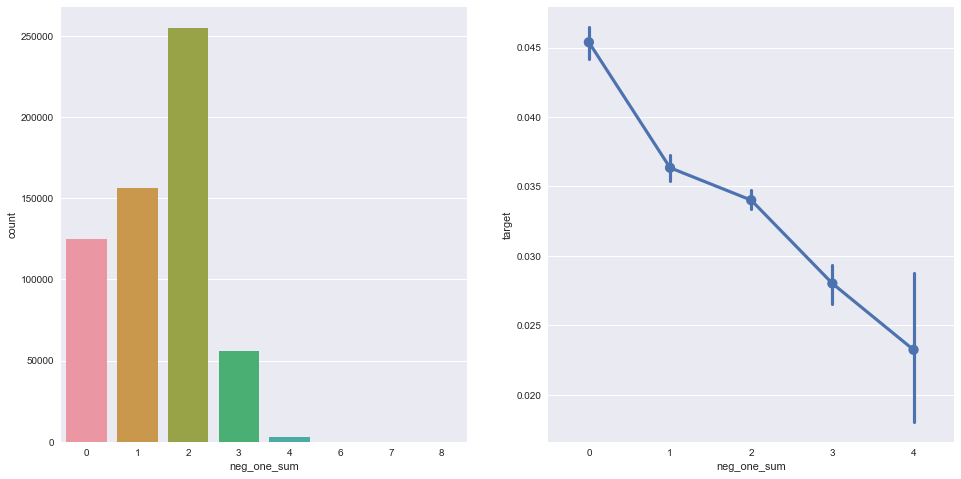

In [20]:
col='neg_one_sum'
fig,axs=plt.subplots(figsize=(16,8),ncols=2)
sns.countplot(x=col,data=train_data,ax=axs[0])
sns.pointplot(x=col,y='target',data=train_data[train_data[col]<5],ax=axs[1]);

### 3) Recursive Feature Elimination

There are various methods for finding out which attributes are relevant for understanding whether a policyholder will file a claim. Because the data is anonymous, rather than relying on intuition, we can systematically test whether a given attribute adds any additional information by first removing it and then scoring how well a trained learner can predict the removed attribute with the remaining subset as `X` and removed feature as `y`. In other words, if an attribute is highly correlated with the rest in its group, then it might not be relevant and we might consider removing it from our features set. 

The function `'relevance_score'` returns the score for a given subset, the feature to be removed, and an appropriate learner. For example, for the region attributes subset, I used a `'DecisionTreeRegressor'` to score the relevance of each individual attribute.   

In [ ]:
def relevance_score(data,feature,model):
    temp_X=data.copy(deep=True)
    temp_y=df(temp_X[feature])
    temp_X.drop(feature,axis=1,inplace=True)
    X_train,X_test,y_train,y_test = train_test_split(temp_X,temp_y,test_size=0.2,random_state=88)
    model.fit(X_train,y_train)
    score=model.score(X_test,y_test)
    return score

In [ ]:
dtr=DecisionTreeRegressor()
dtc=DecisionTreeClassifier()

In [ ]:
print('Region attribute scores:')
for col in X_reg:
    score=relevance_score(X_reg,col,dtr)
    print(col,score)

In [ ]:
print('Car attribute scores:')
for col in X_car_integer:
    score=relevance_score(X_car,col,dtc)
    print(col,score)
for col in X_car_float:
    score=relevance_score(X_car,col,dtr)
    print(col,score)

In [ ]:
print('Individual attribute scores:')
for col in X_ind:
    score=relevance_score(X_ind,col,dtc)
    print(col,score)

### 4) Visualize Feature Distributions
#### Binary Attributes

In [92]:
X_bin_y_2=X_bin_y.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin',
                        'ps_ind_16_bin','ps_ind_17_bin','ps_ind_18_bin'],axis=1)

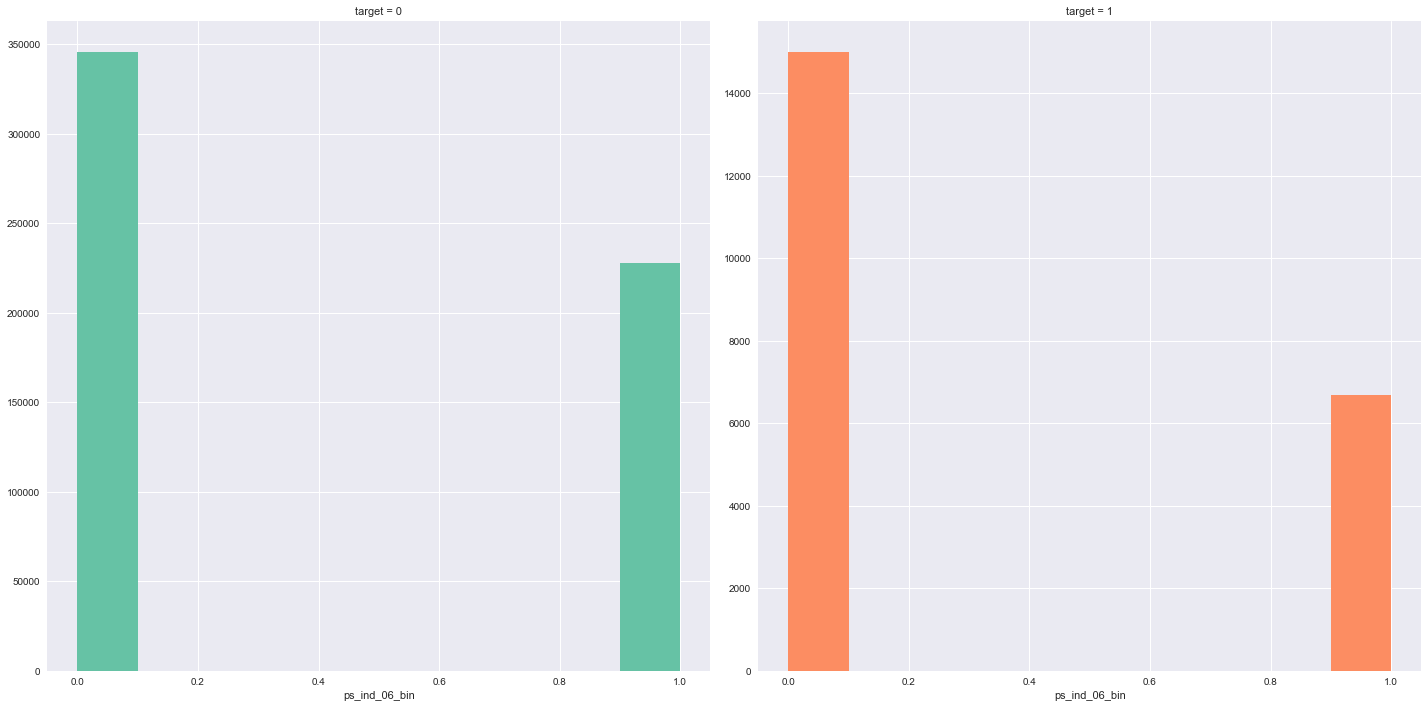

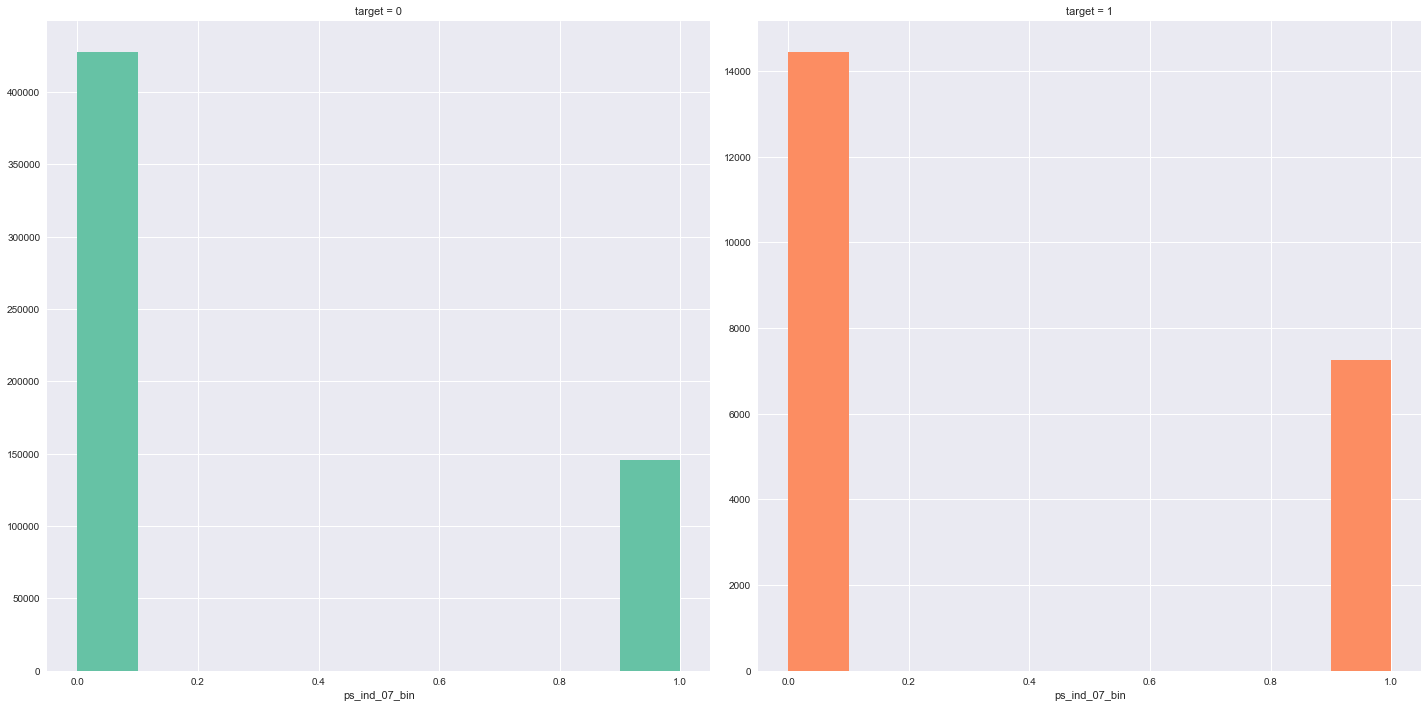

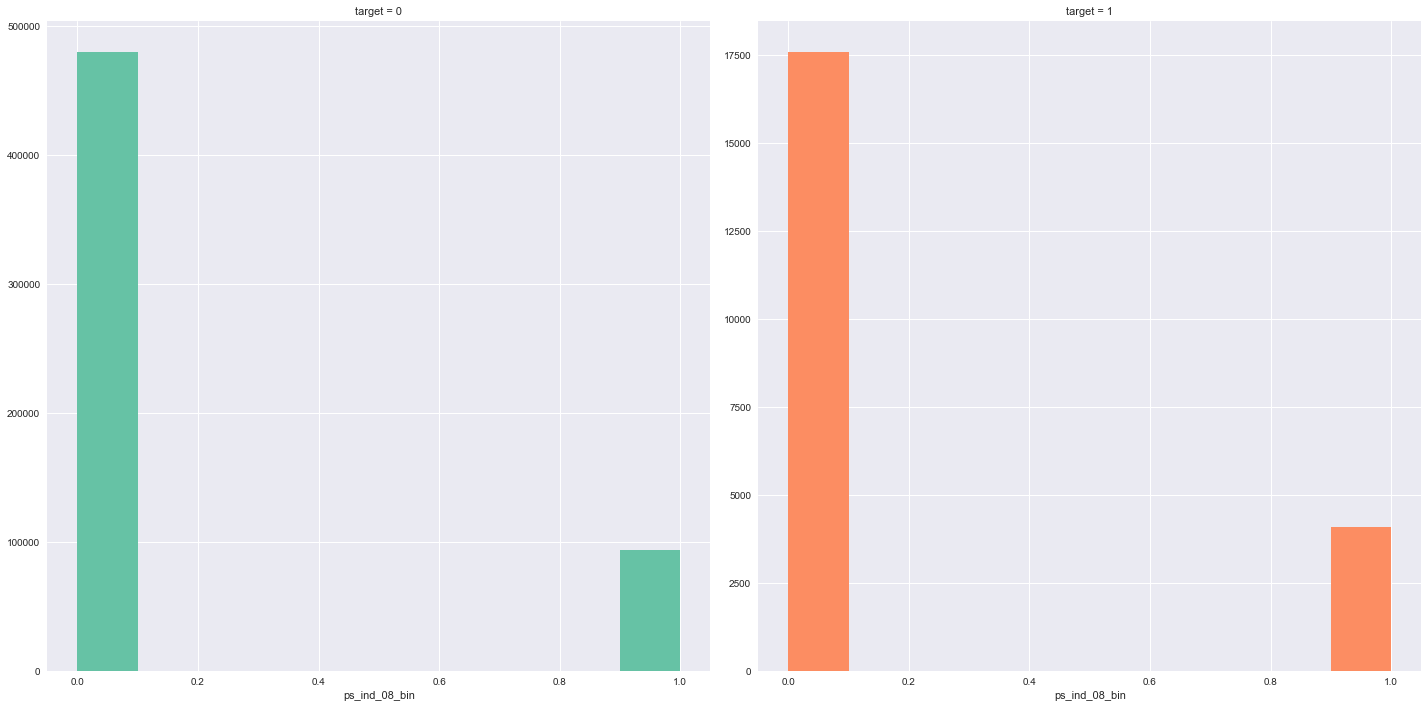

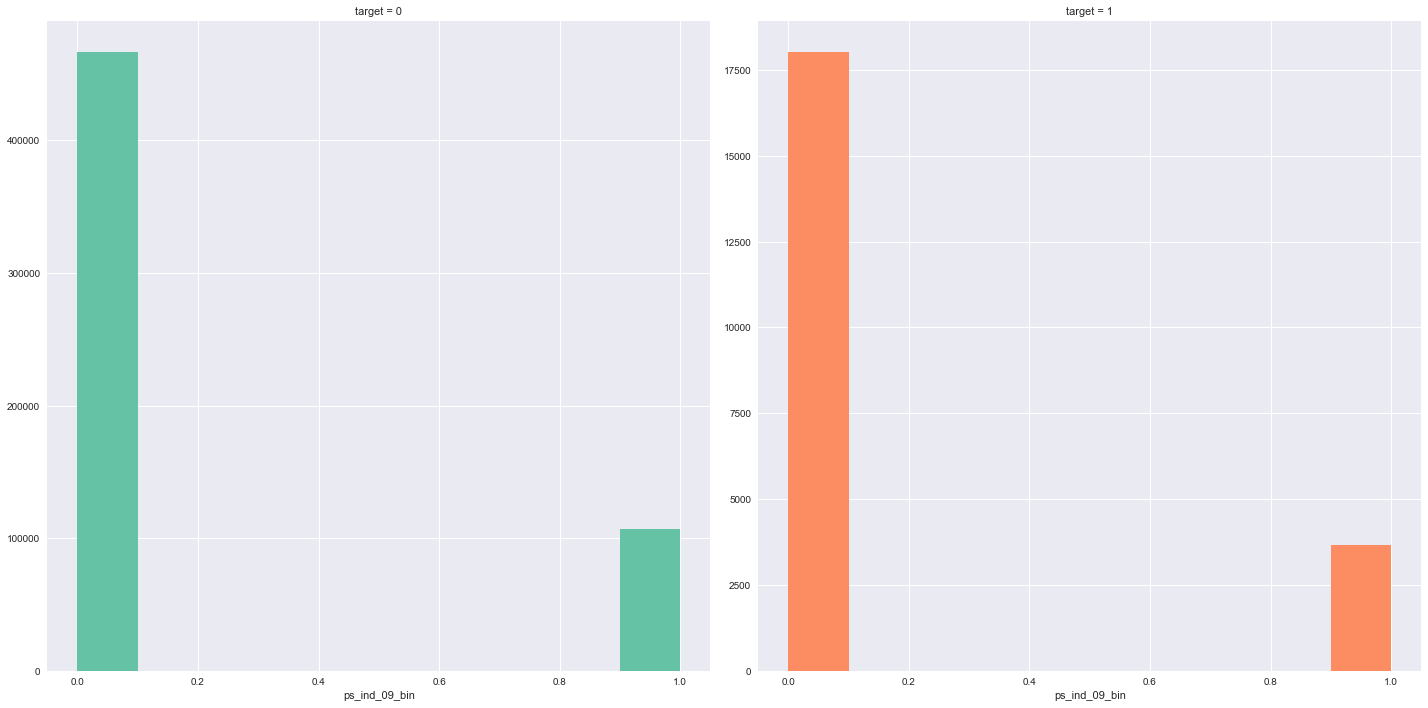

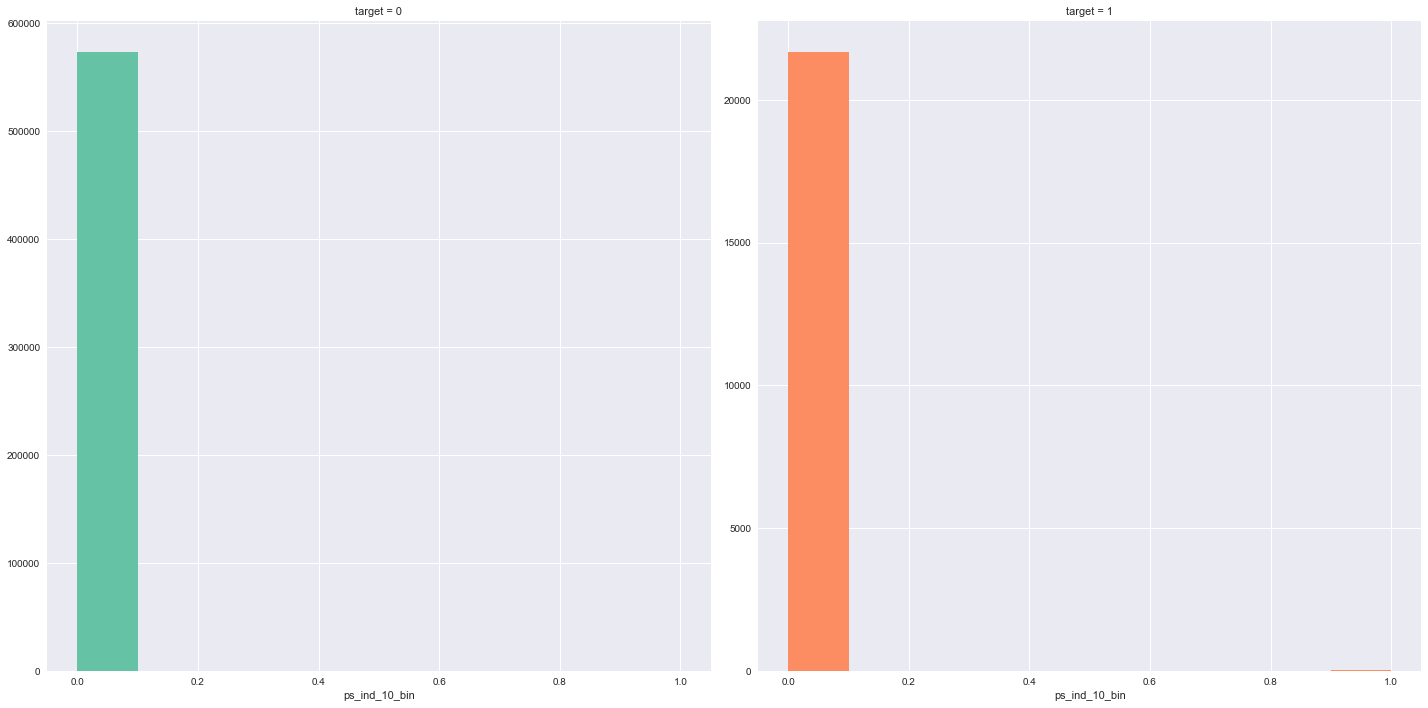

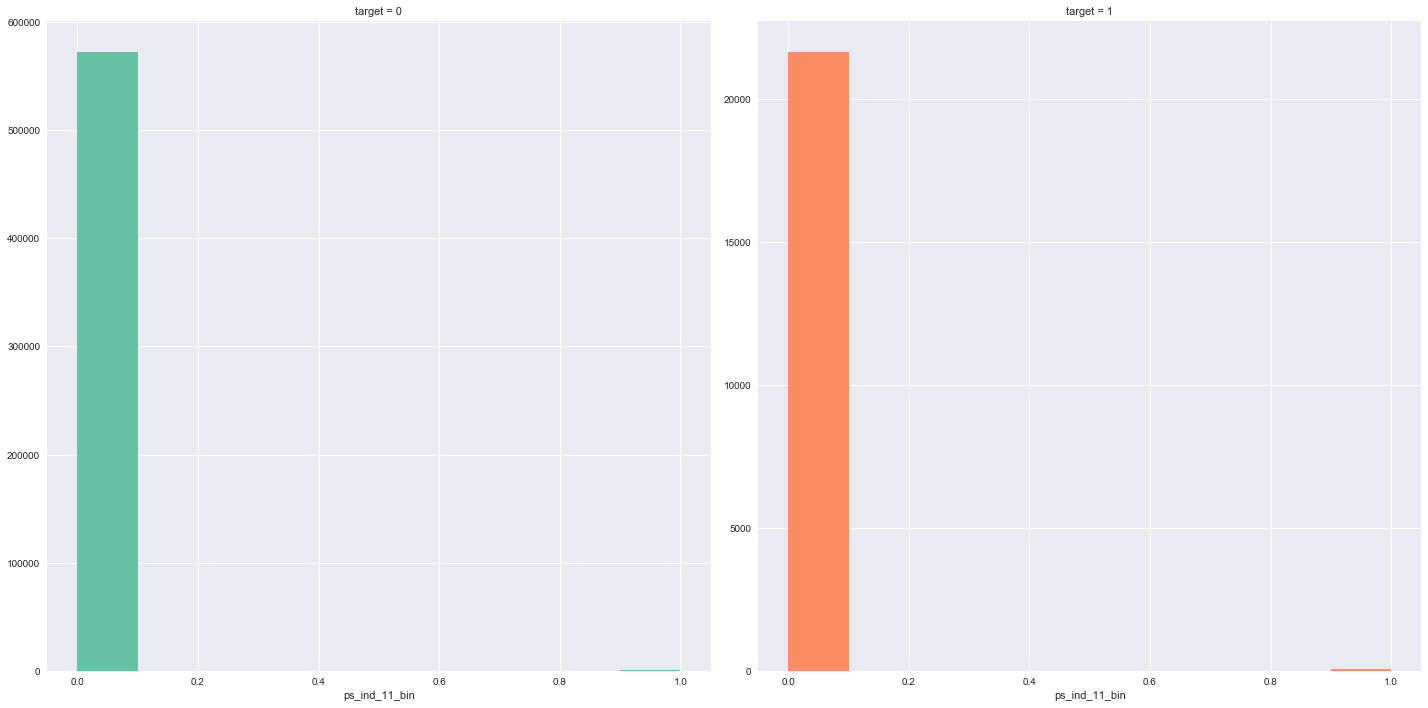

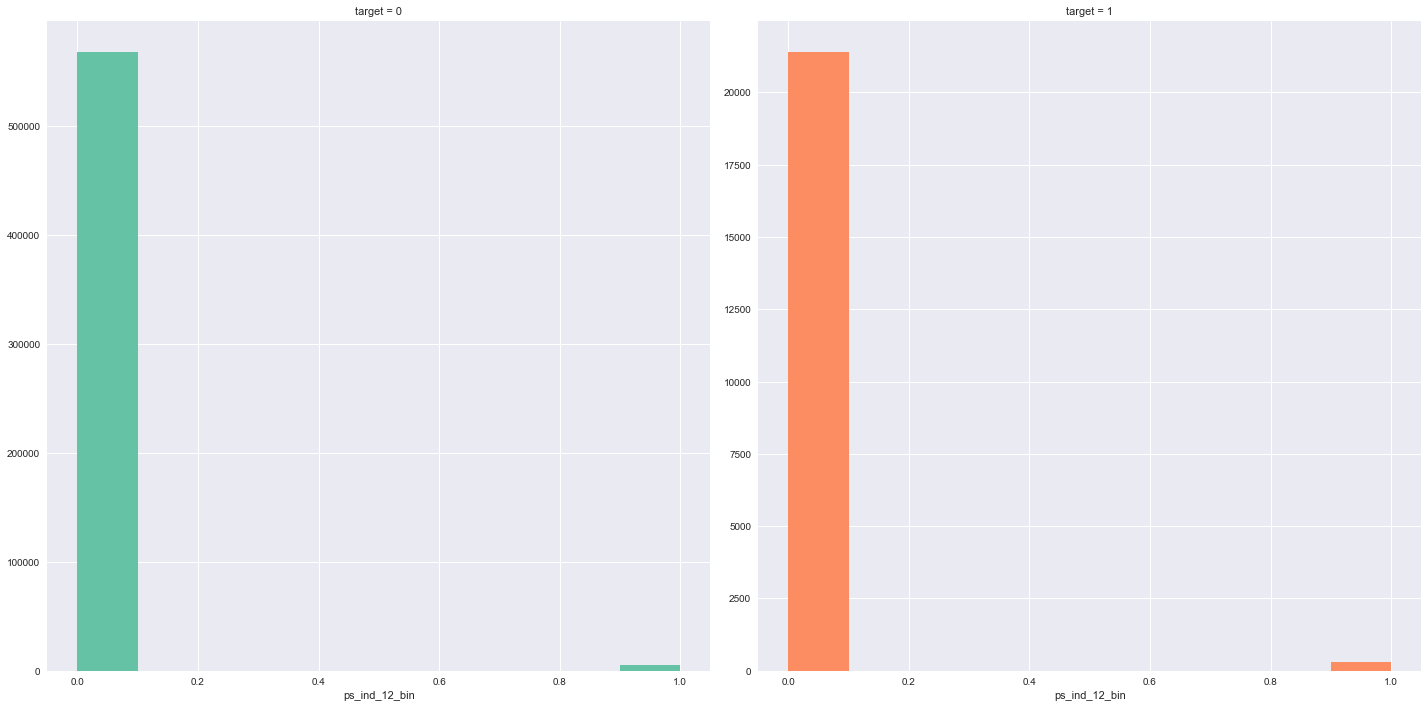

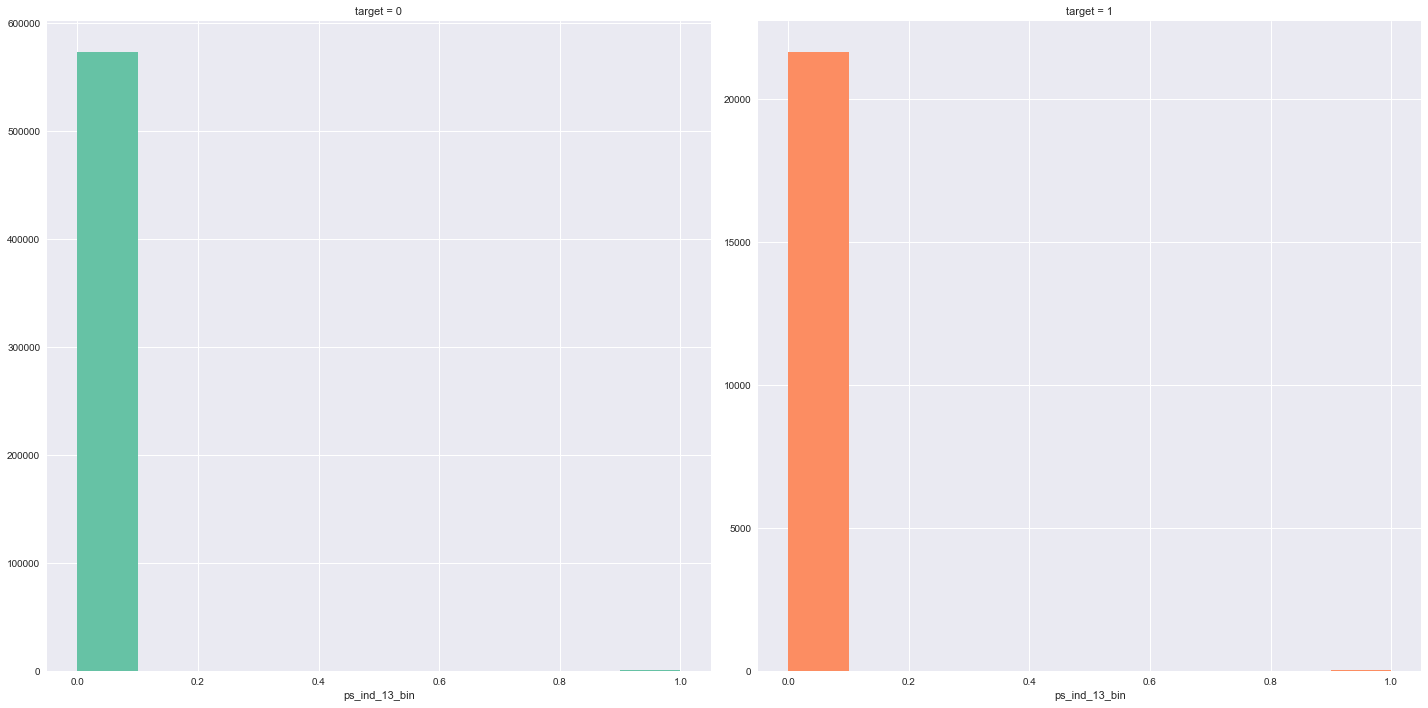

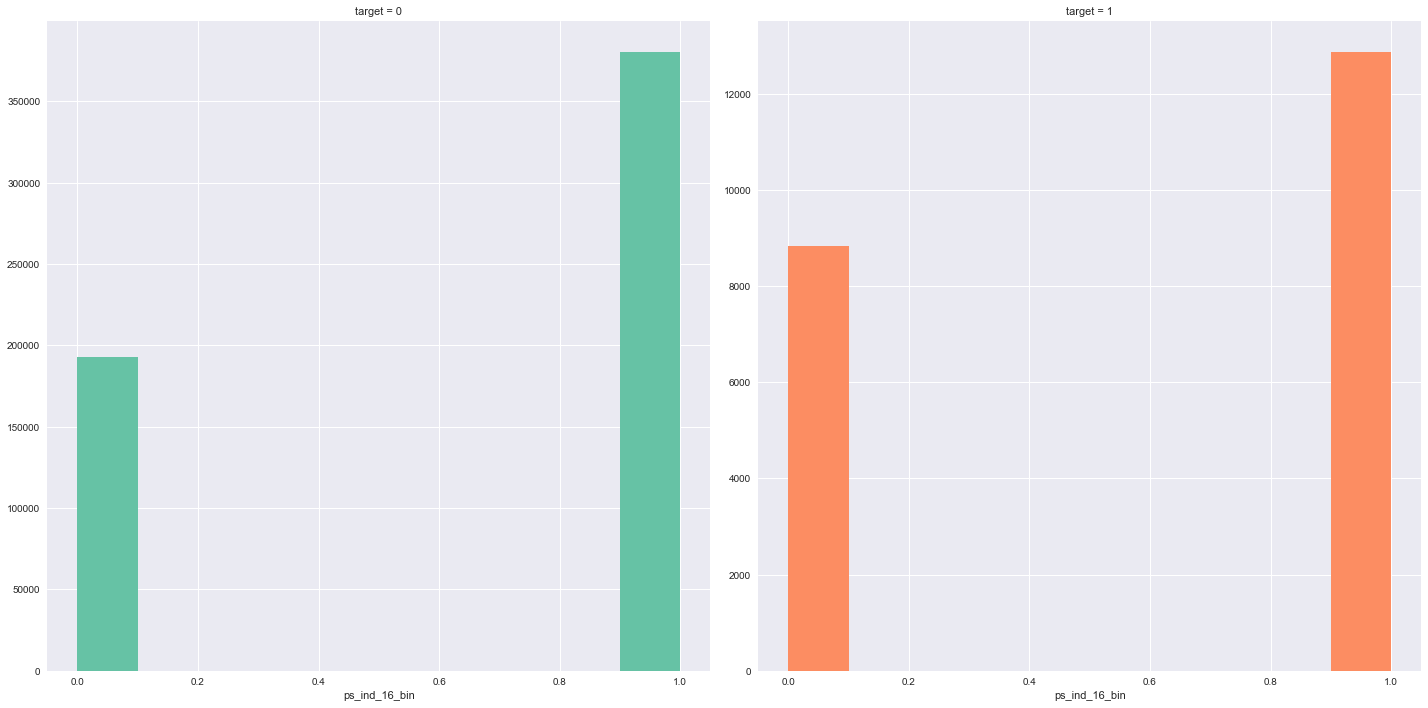

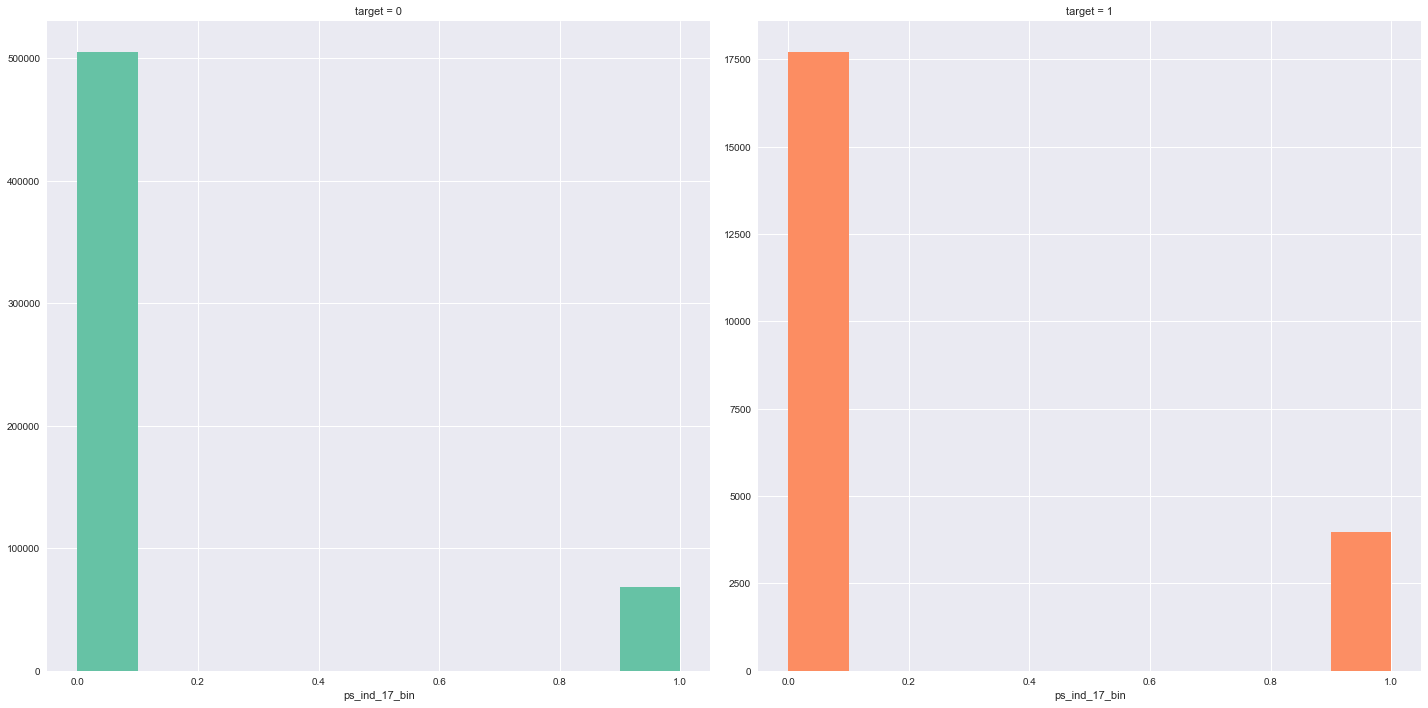

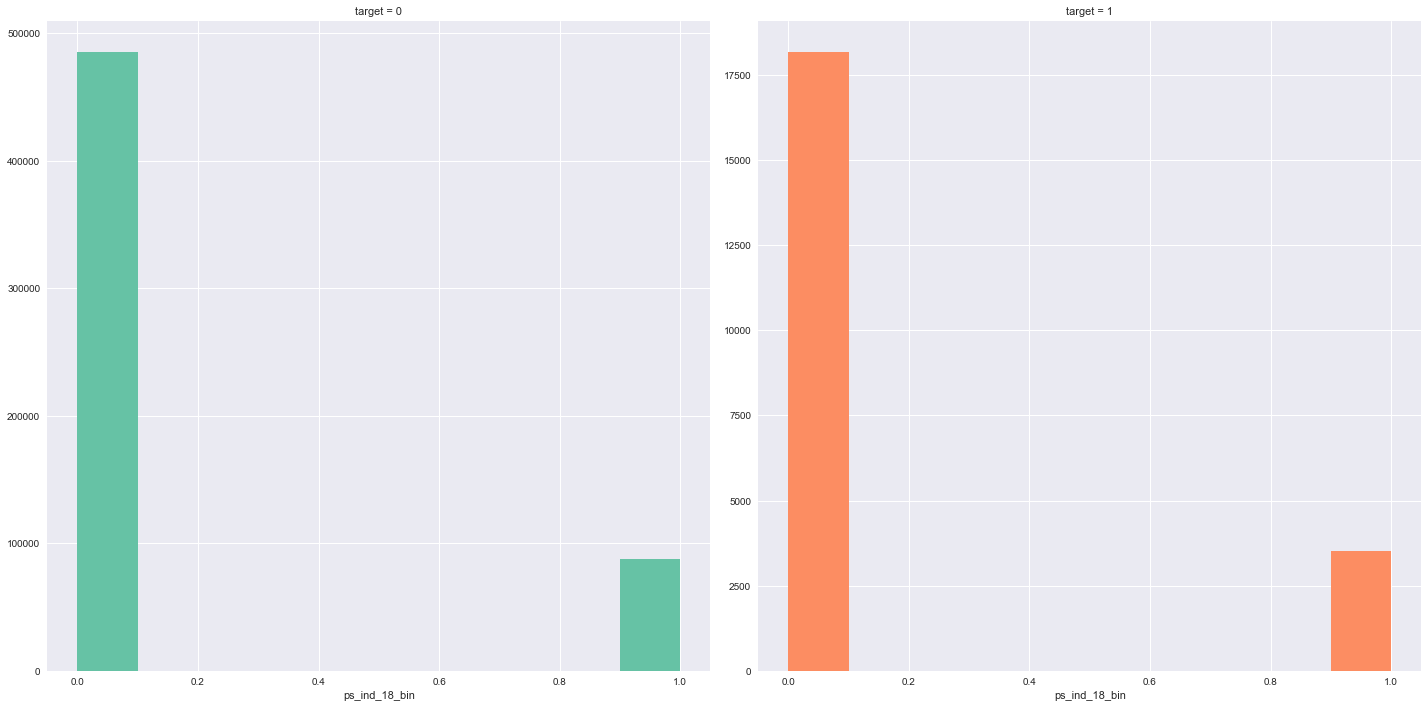

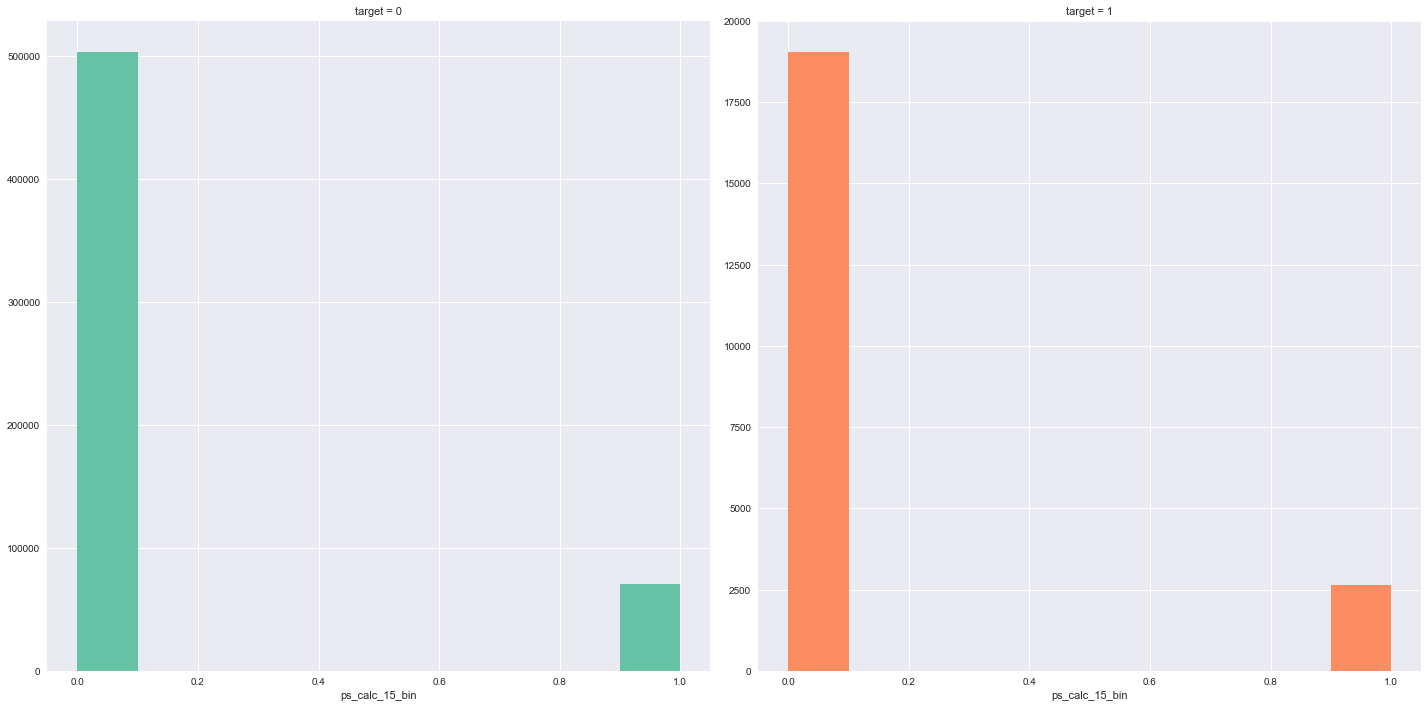

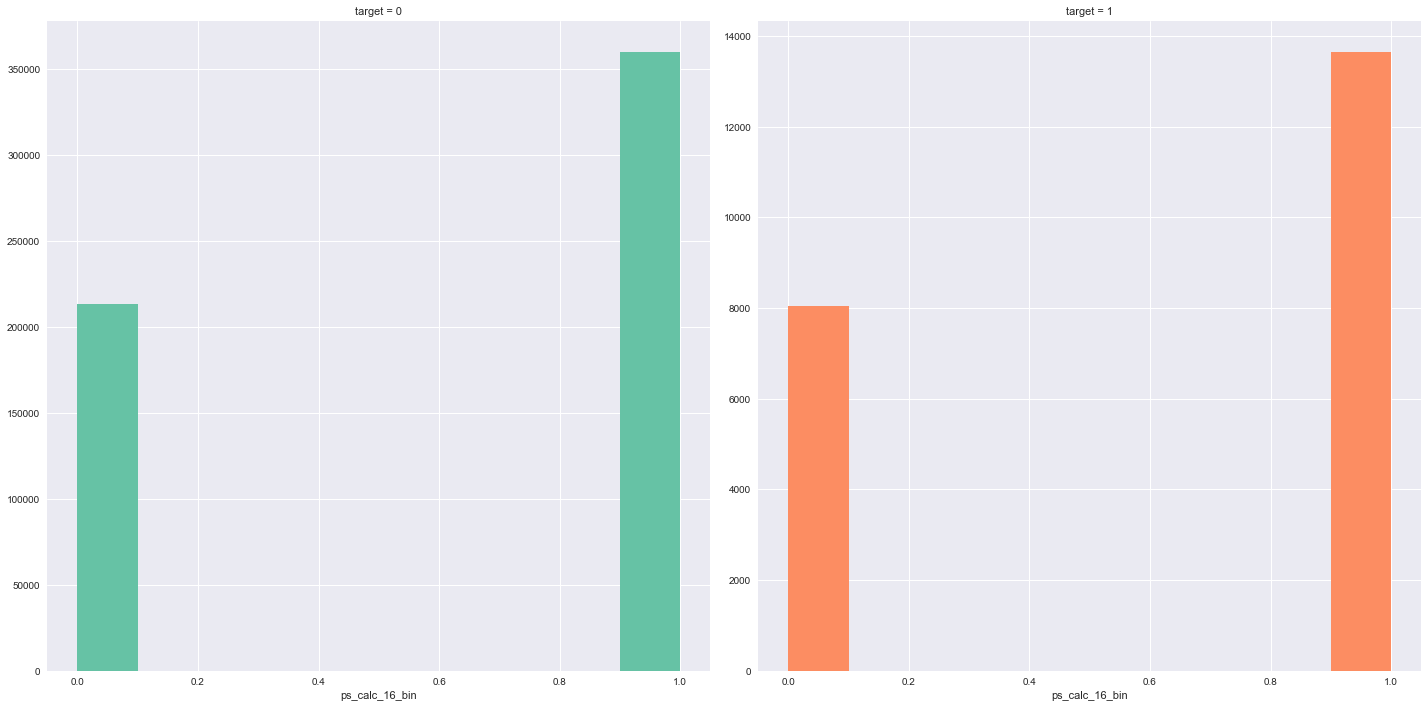

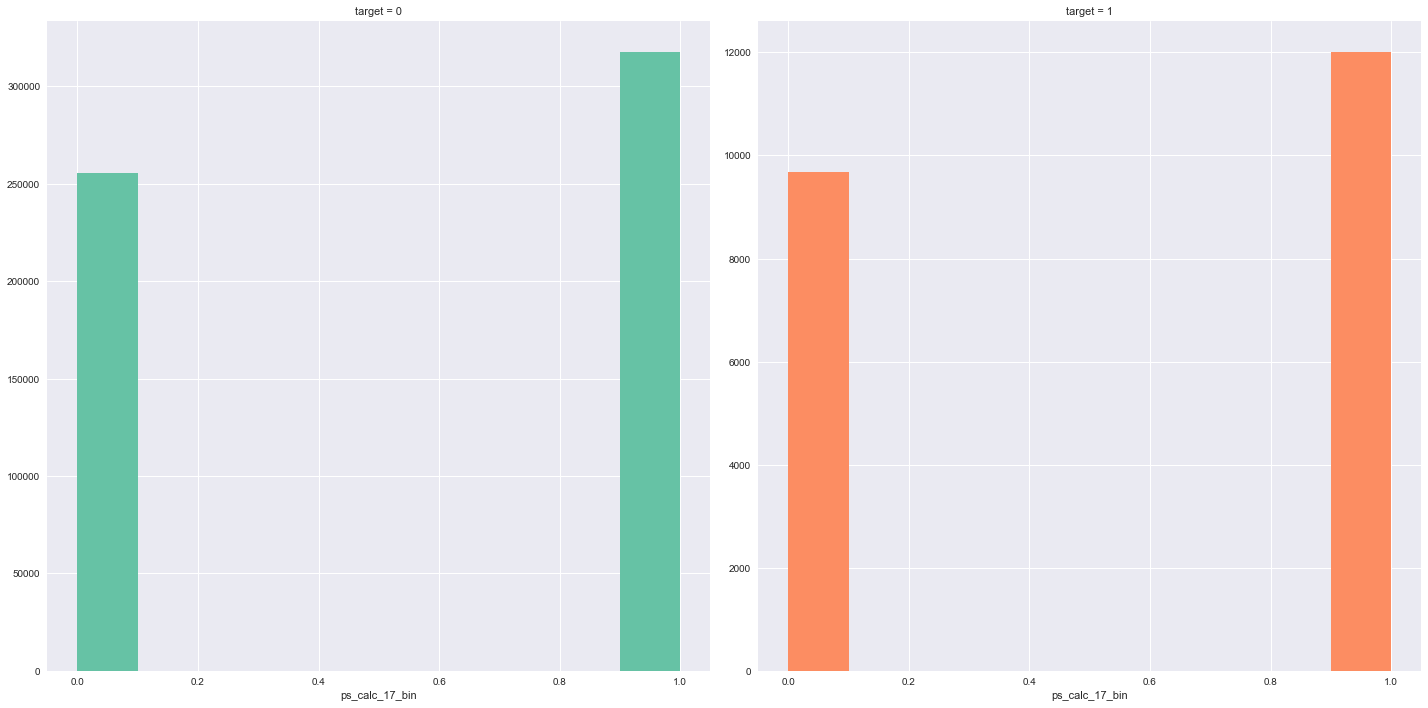

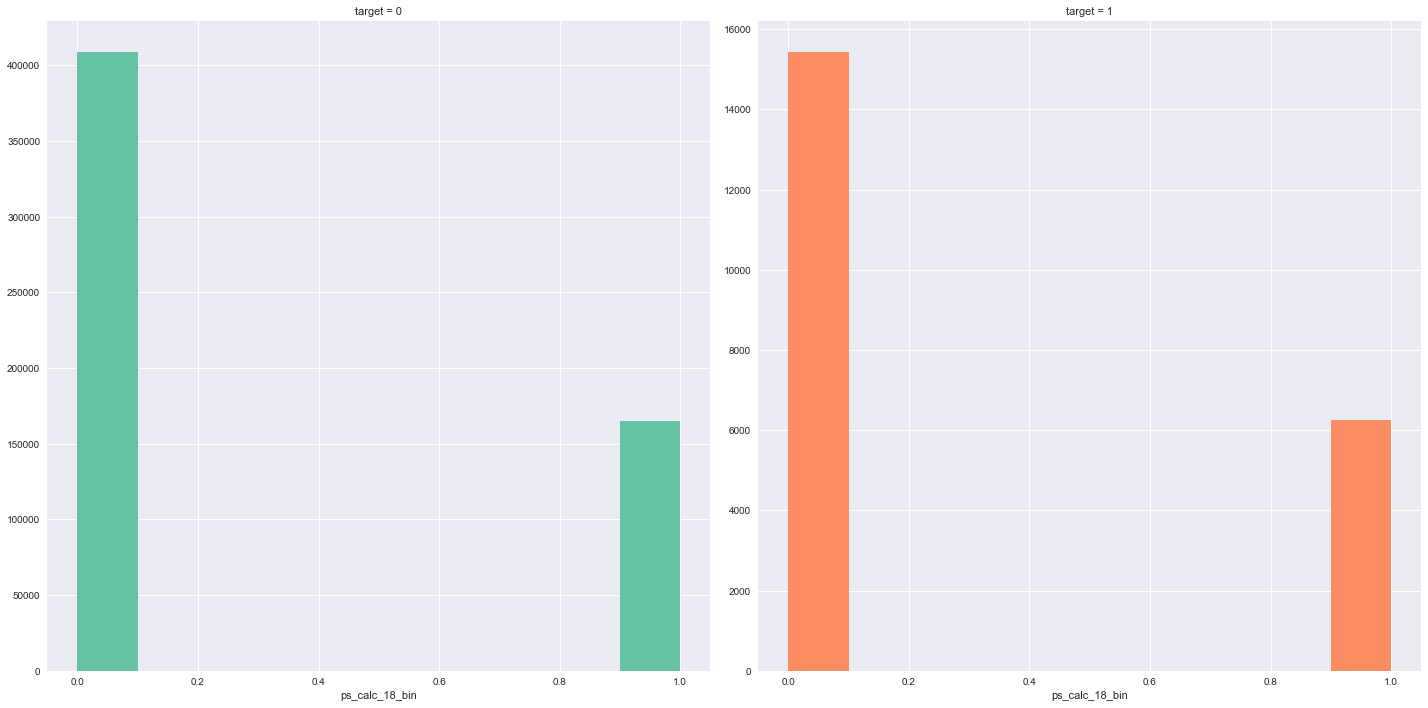

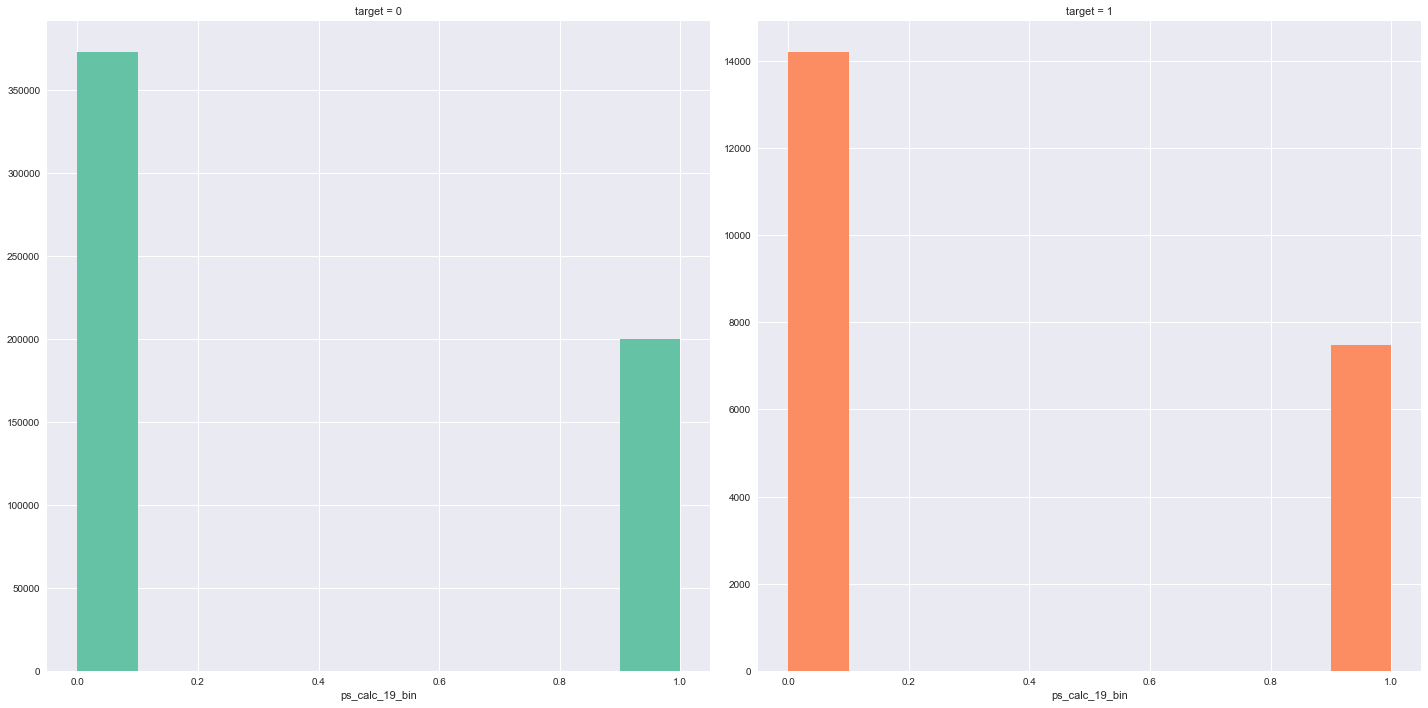

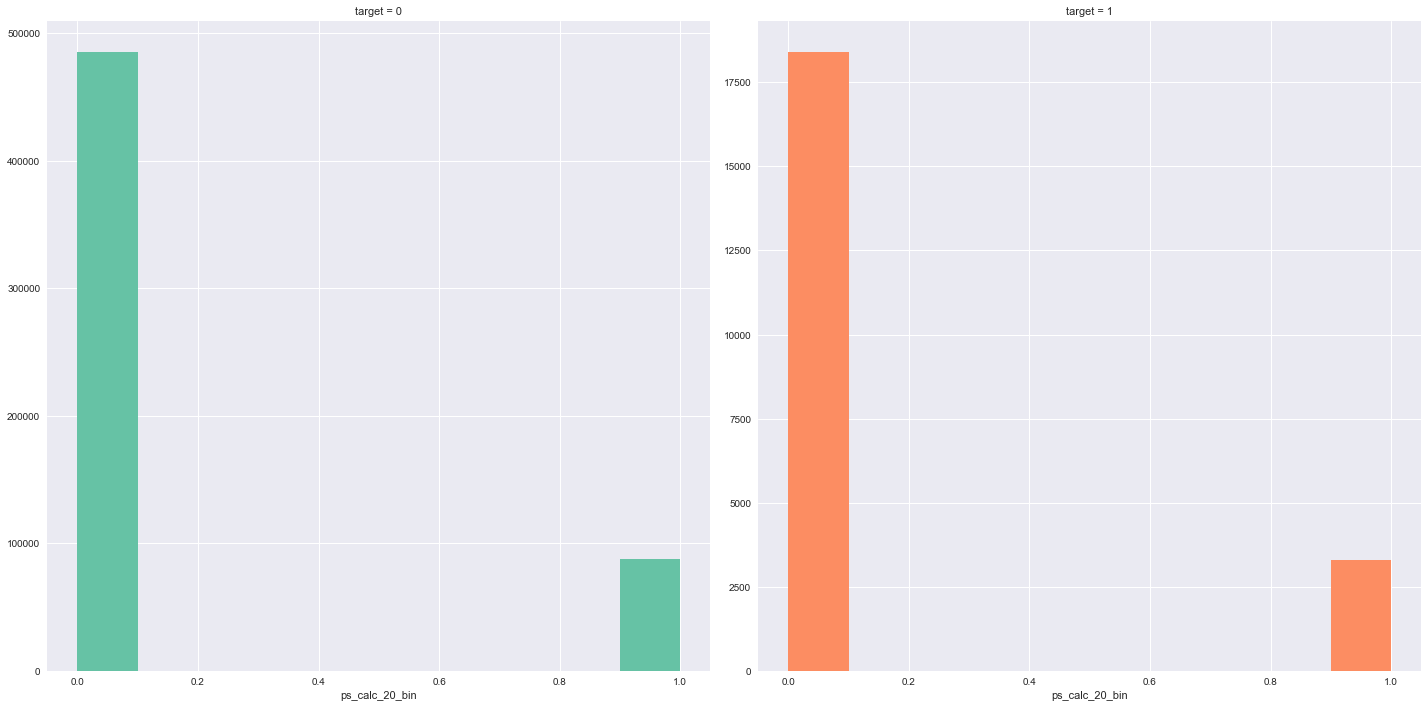

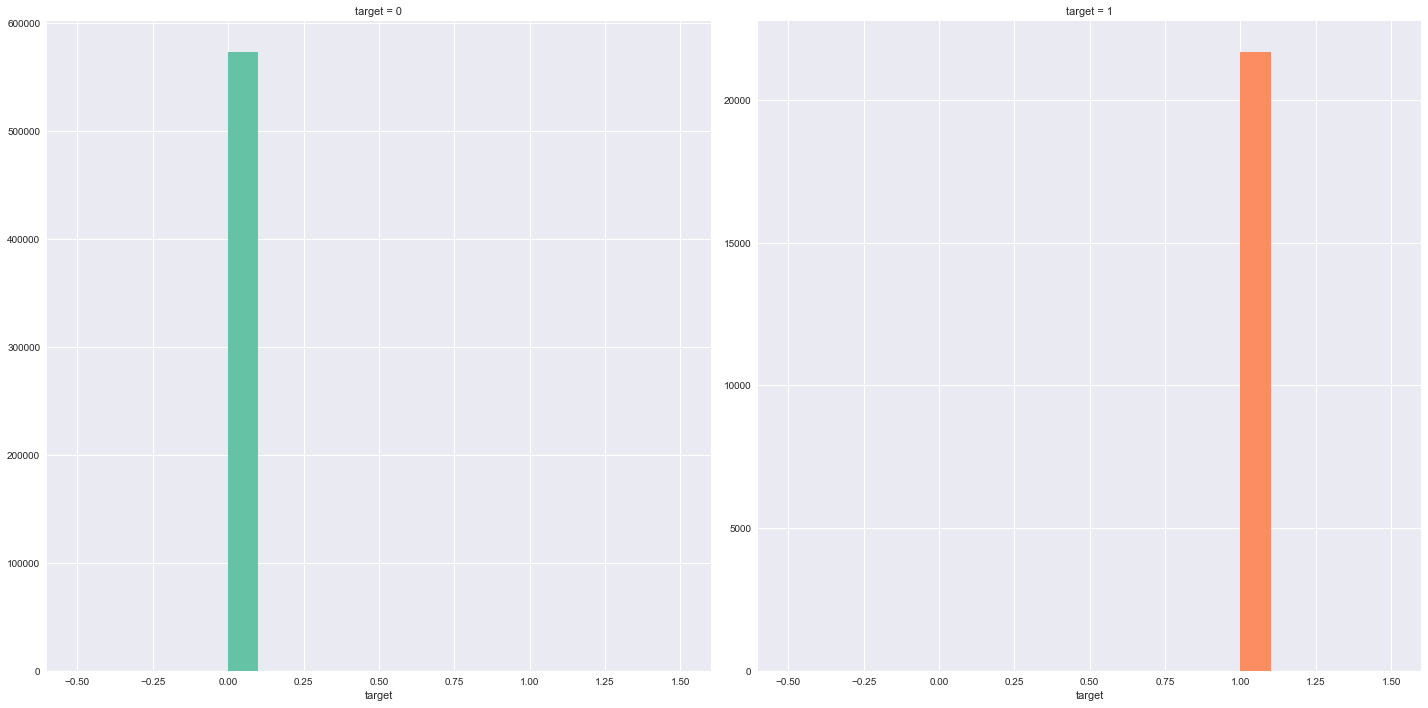

In [8]:
# produce histograms for all BINARY attributes
for col in X_bin_y.columns:
    g=sns.FacetGrid(X_bin_y,col='target',palette='Set2',hue='target',size=10,sharey=False)
    g.map(plt.hist,col);

In [108]:
X_bin_y_2['ps_ind_10_to_13_cat']=X_bin_y_2['ps_ind_10_bin']+X_bin_y_2['ps_ind_11_bin']+\
X_bin_y_2['ps_ind_12_bin']+X_bin_y_2['ps_ind_13_bin']
X_bin_y_2.sort_values(by='ps_ind_10_to_13_cat',ascending=False,inplace=True)
display(X_bin_y_2.head())
print(Counter(X_bin_y_2['ps_ind_10_to_13_cat']))
print(Counter(X_ord_y['ps_ind_14']))

,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target,ps_ind_10_to_13_cat
94859,1,1,1,1,0,1,1,1,0,0,0,4
345622,1,1,1,1,0,1,0,0,1,0,0,4
564742,1,1,1,1,0,1,0,0,0,0,0,4
113669,1,1,1,1,0,1,0,1,0,0,1,4
212956,1,1,1,1,0,0,1,0,0,0,0,4


Counter({0: 588832, 1: 5495, 2: 744, 3: 136, 4: 5})
Counter({0: 588832, 1: 5495, 2: 744, 3: 136, 4: 5})


In [60]:
len(X_ind_y[(X_ind_y['ps_ind_07_bin']==1) & (X_ind_y['ps_ind_03']==0)])

3066

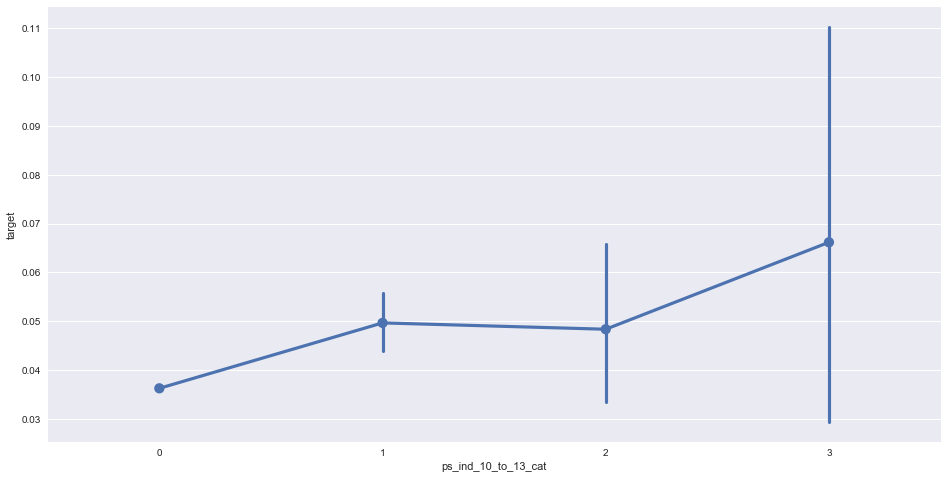

In [106]:
col='ps_ind_10_to_13_cat'
data=X_bin_y_2[X_bin_y_2[col]<4]
plt.figure(figsize=(16,8))
sns.pointplot(x=col,y='target',data=data);

In [87]:
cols_selected=X_ind_y.filter(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin',
                              'ps_ind_16_bin','ps_ind_17_bin','ps_ind_18_bin','target'],axis=1)
cols_selected['ps_ind_07_bin_2']=np.where(cols_selected['ps_ind_07_bin']==1,2,0)
cols_selected['ps_ind_08_bin_3']=np.where(cols_selected['ps_ind_08_bin']==1,3,0)
cols_selected['ps_ind_09_bin_4']=np.where(cols_selected['ps_ind_09_bin']==1,4,0)
cols_selected['ps_ind_06_to_09_cat']=cols_selected['ps_ind_07_bin_2']+cols_selected['ps_ind_08_bin_3']+\
cols_selected['ps_ind_09_bin_4']+cols_selected['ps_ind_06_bin']-1
cols_selected['ps_ind_17_bin_2']=np.where(cols_selected['ps_ind_17_bin']==1,2,0)
cols_selected['ps_ind_18_bin_3']=np.where(cols_selected['ps_ind_18_bin']==1,3,0)
cols_selected['ps_ind_16_to_18_cat']=cols_selected['ps_ind_17_bin_2']+cols_selected['ps_ind_18_bin_3']+\
cols_selected['ps_ind_16_bin']
cols_selected_2=cols_selected.filter(['ps_ind_16_to_18_cat','ps_ind_06_to_09_cat'],axis=1)

display(cols_selected_2.transpose())

,0,1,2,3,4,5,6,7,8,9,...,595202,595203,595204,595205,595206,595207,595208,595209,595210,595211
ps_ind_16_to_18_cat,2,3,1,1,1,1,1,1,1,3,...,1,2,1,1,1,1,1,1,1,1
ps_ind_06_to_09_cat,1,2,2,0,0,3,1,0,2,1,...,1,1,1,1,3,3,3,0,2,0


#### Categorical Attributes

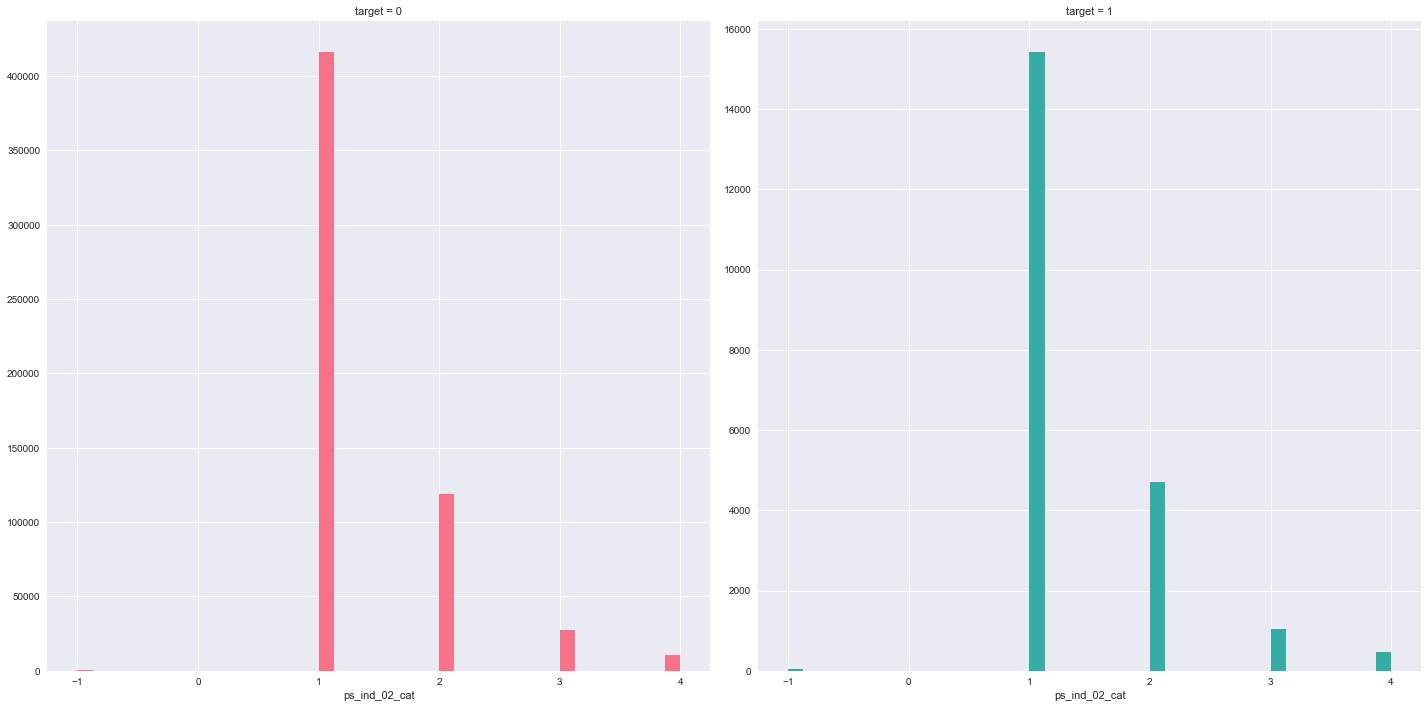

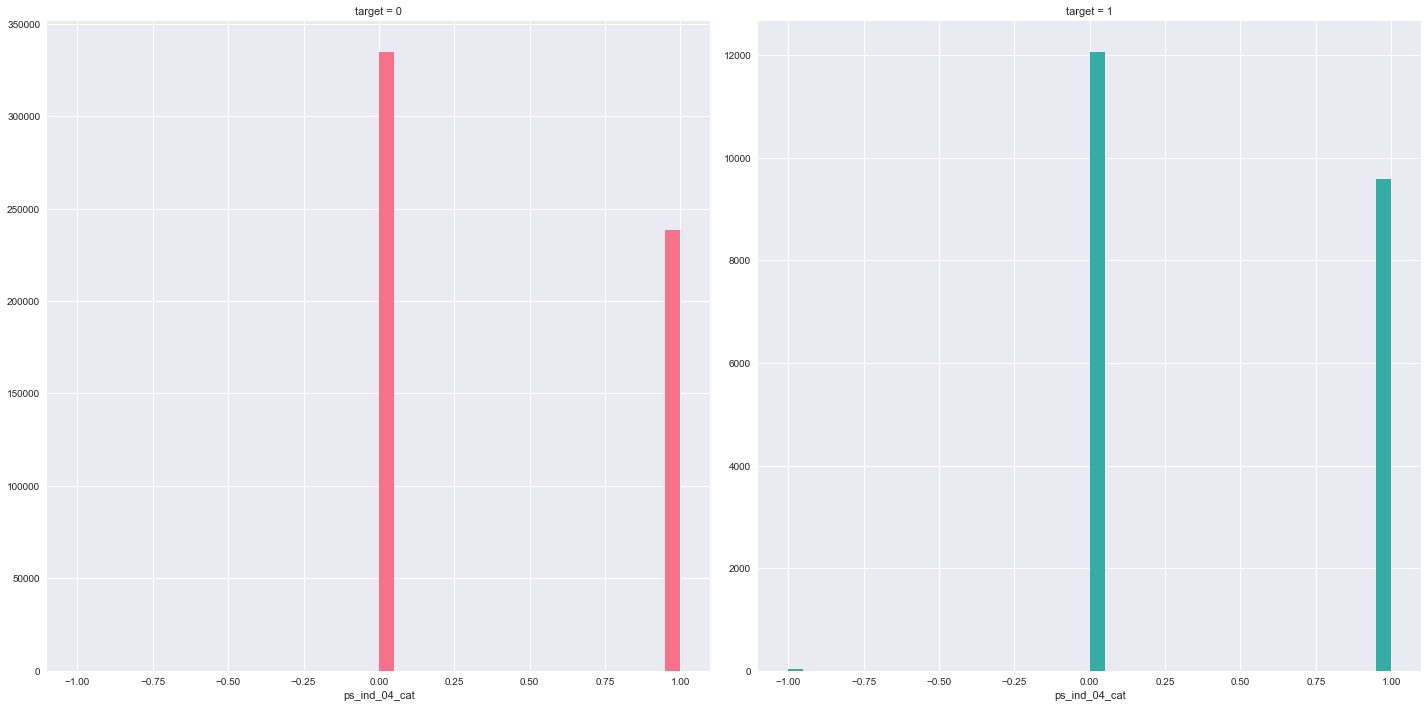

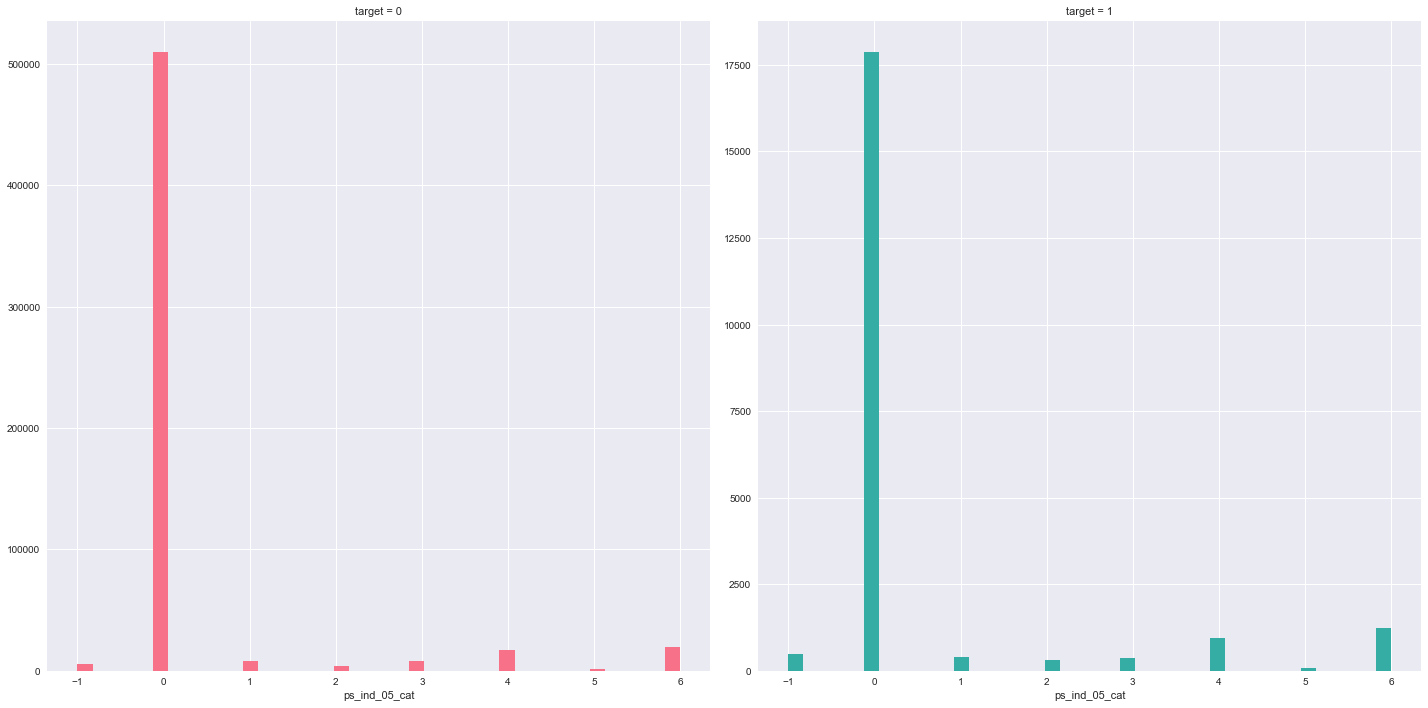

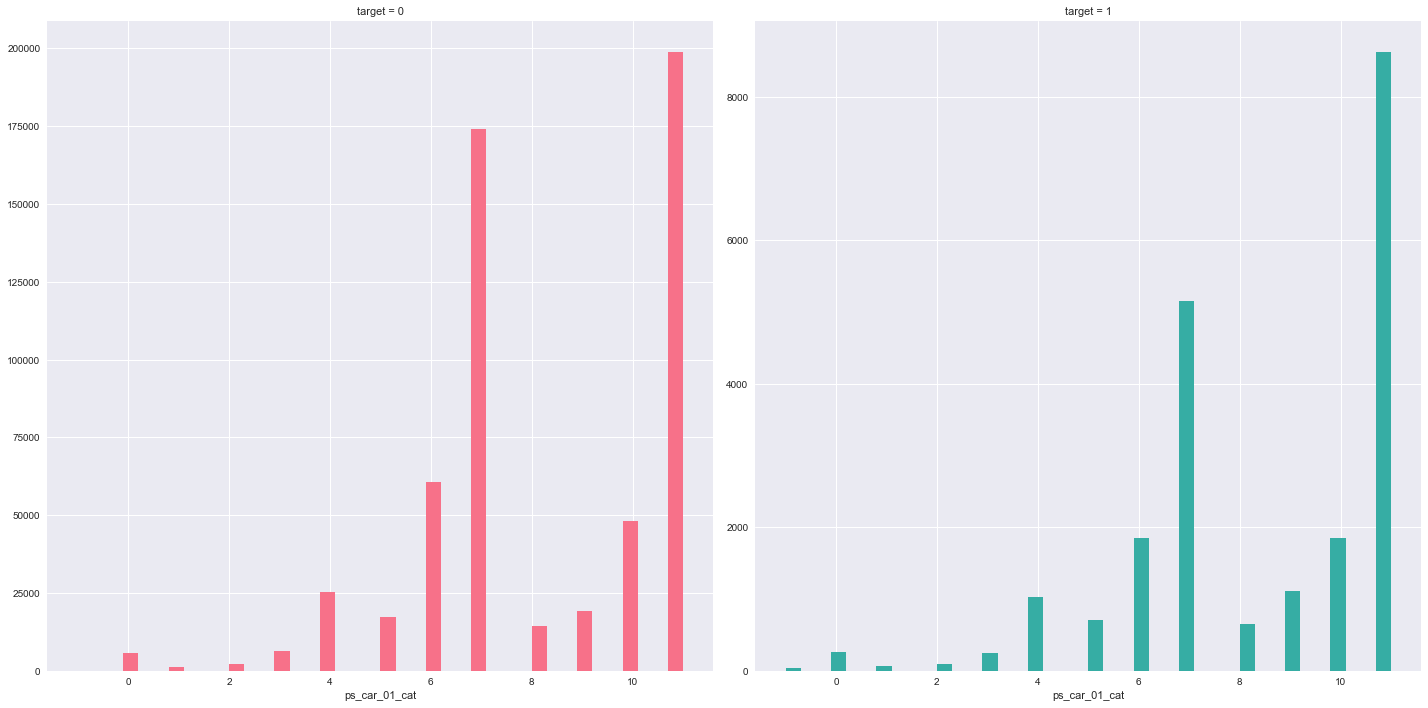

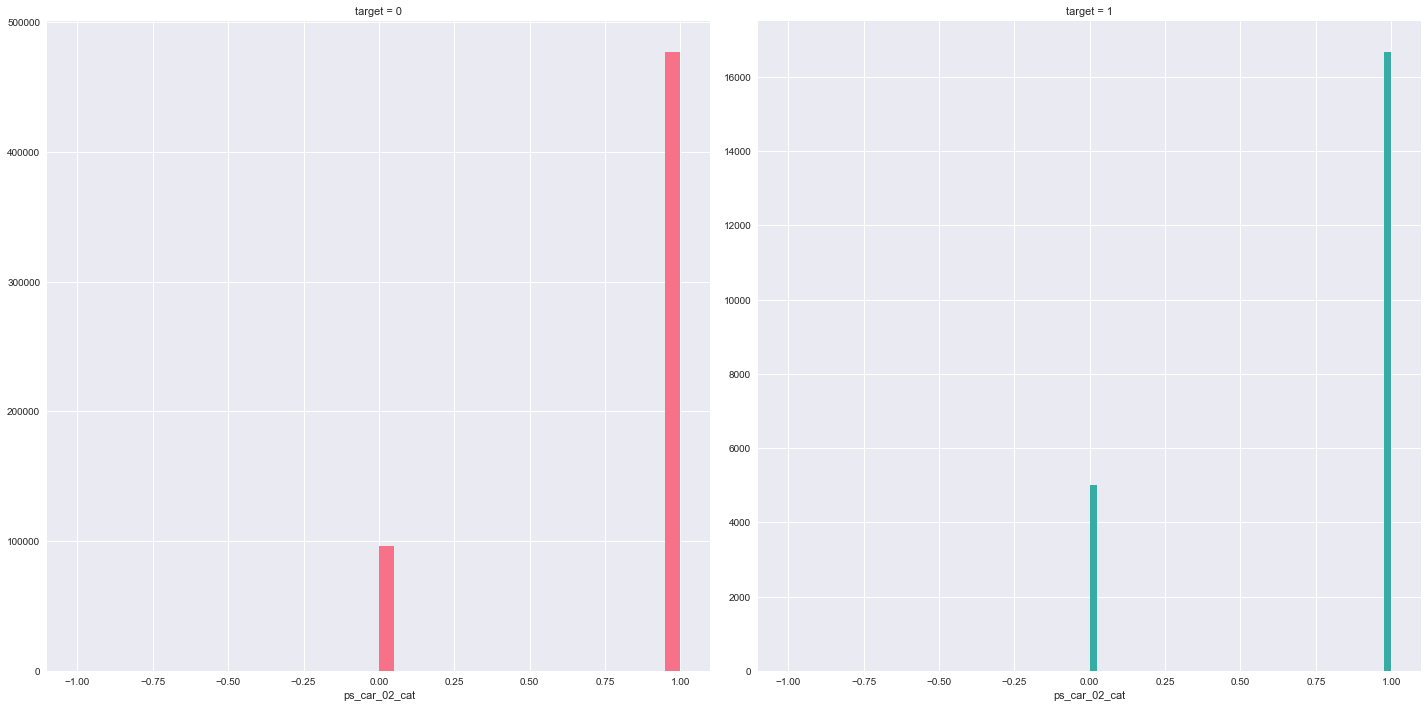

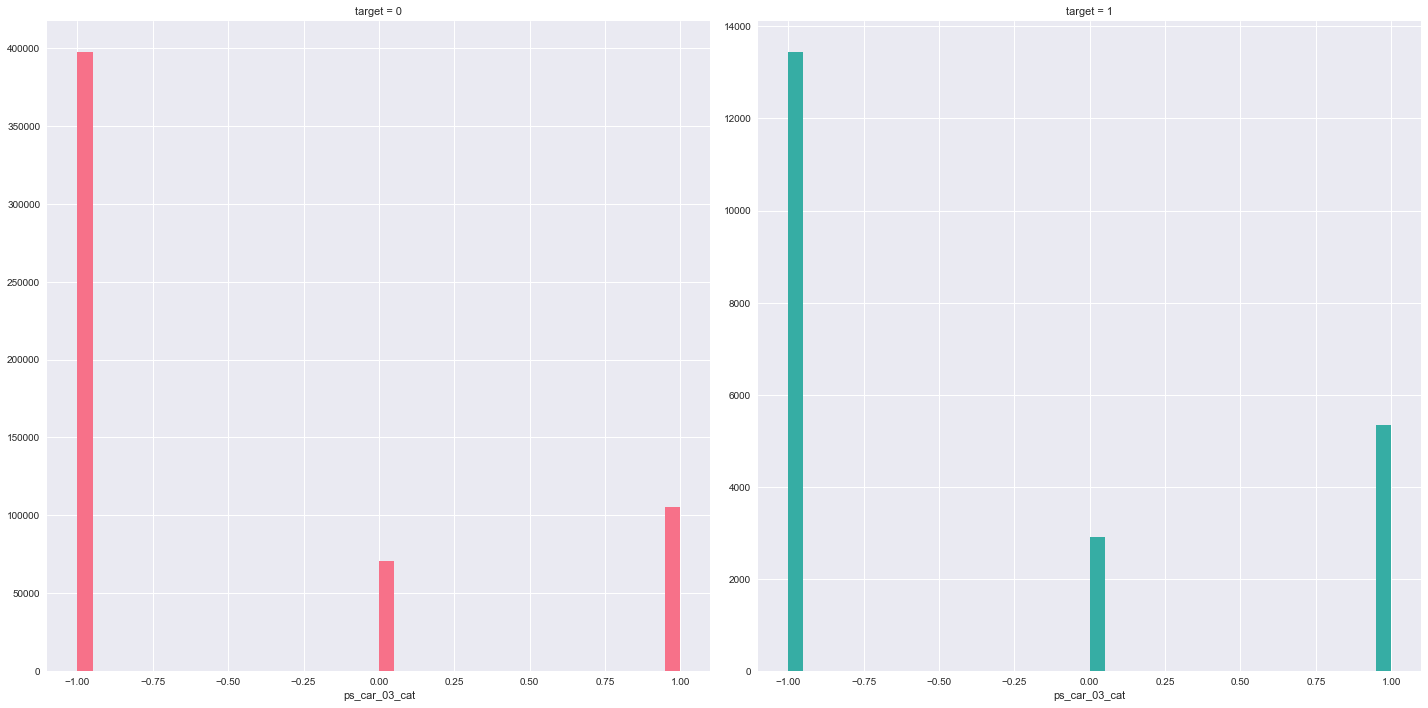

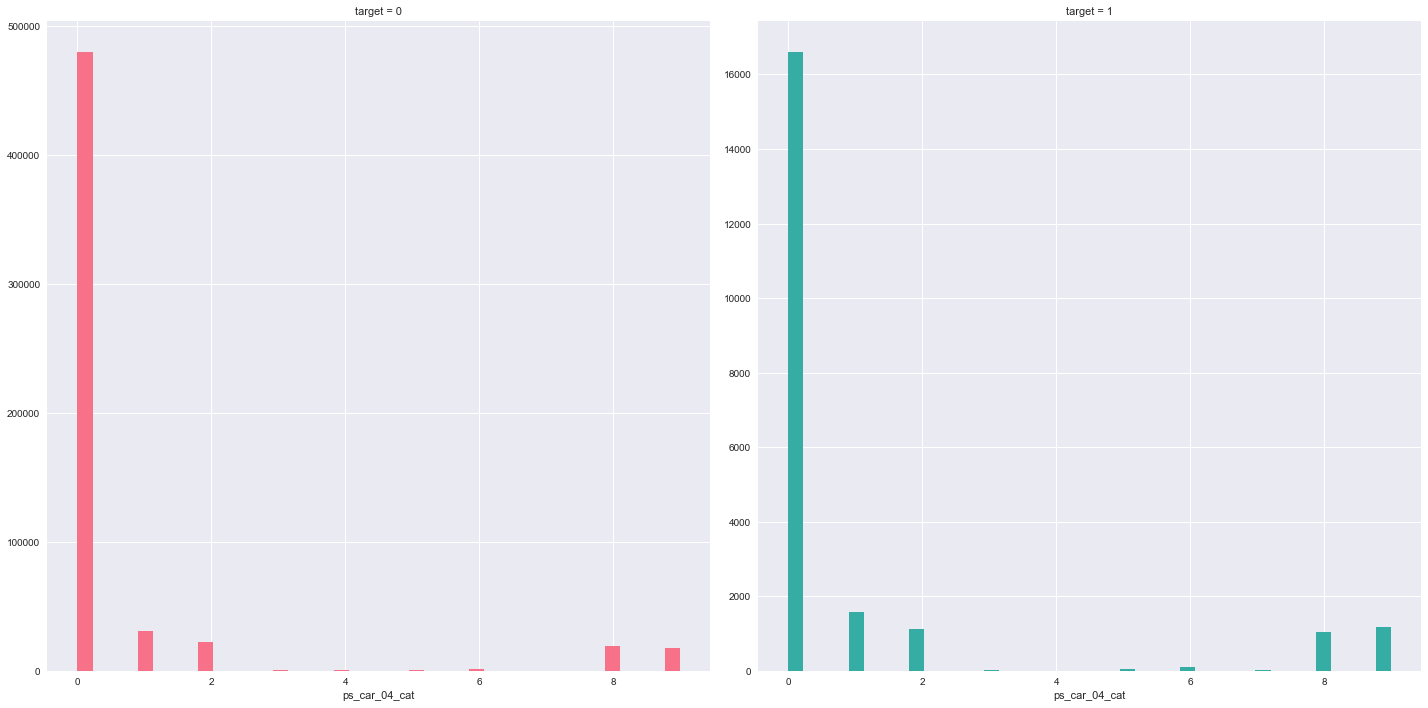

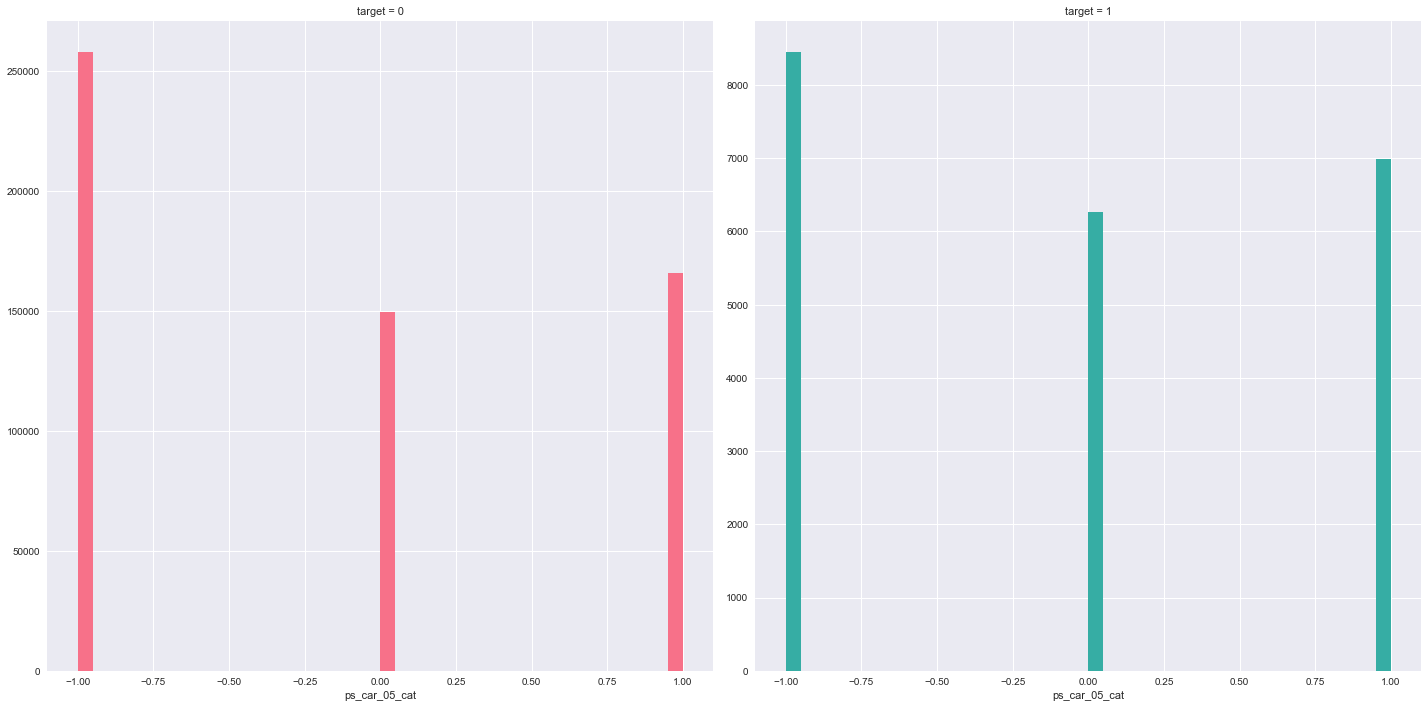

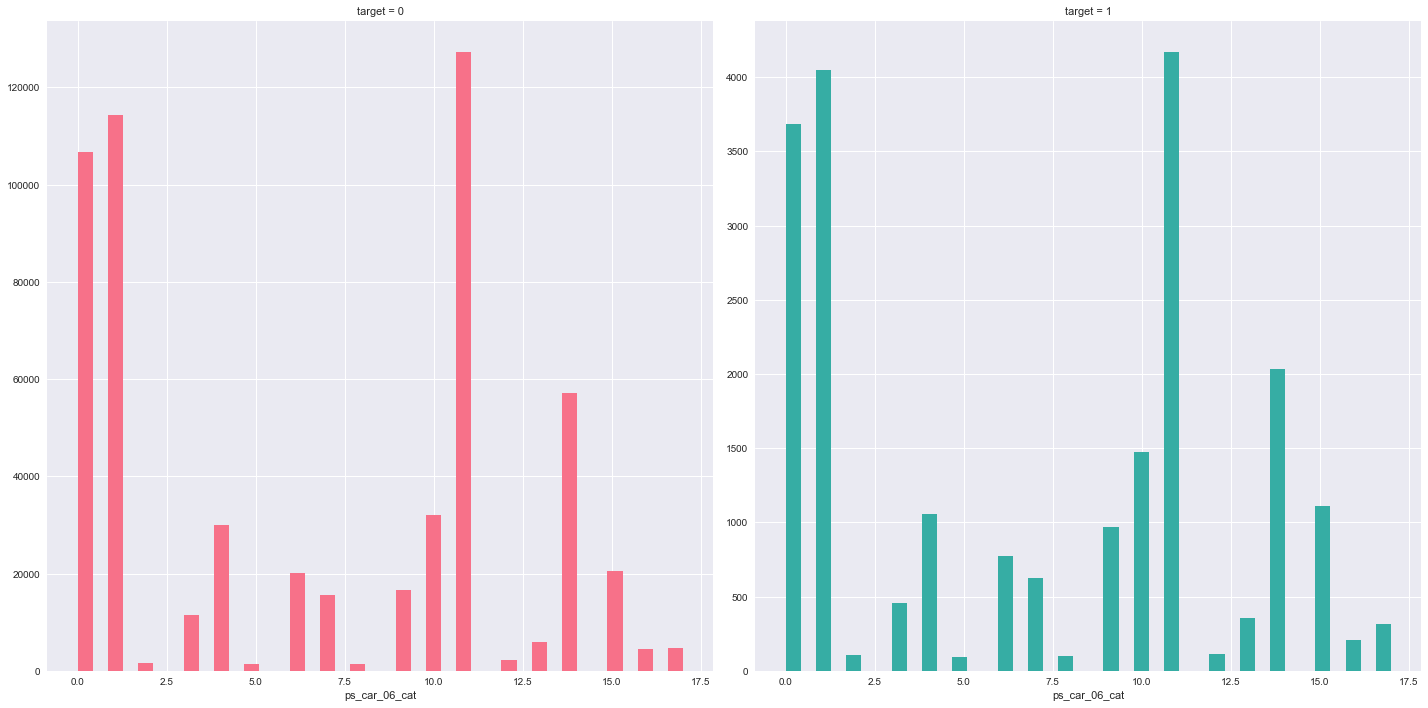

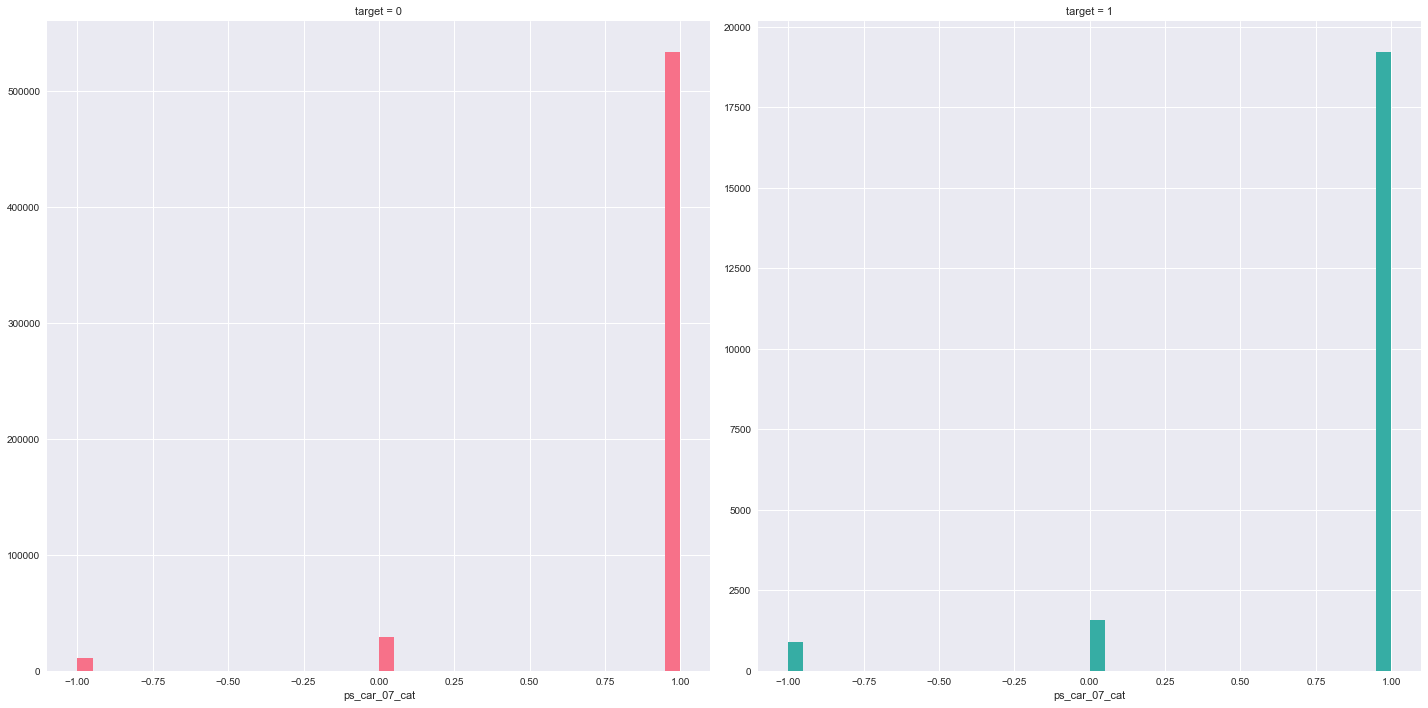

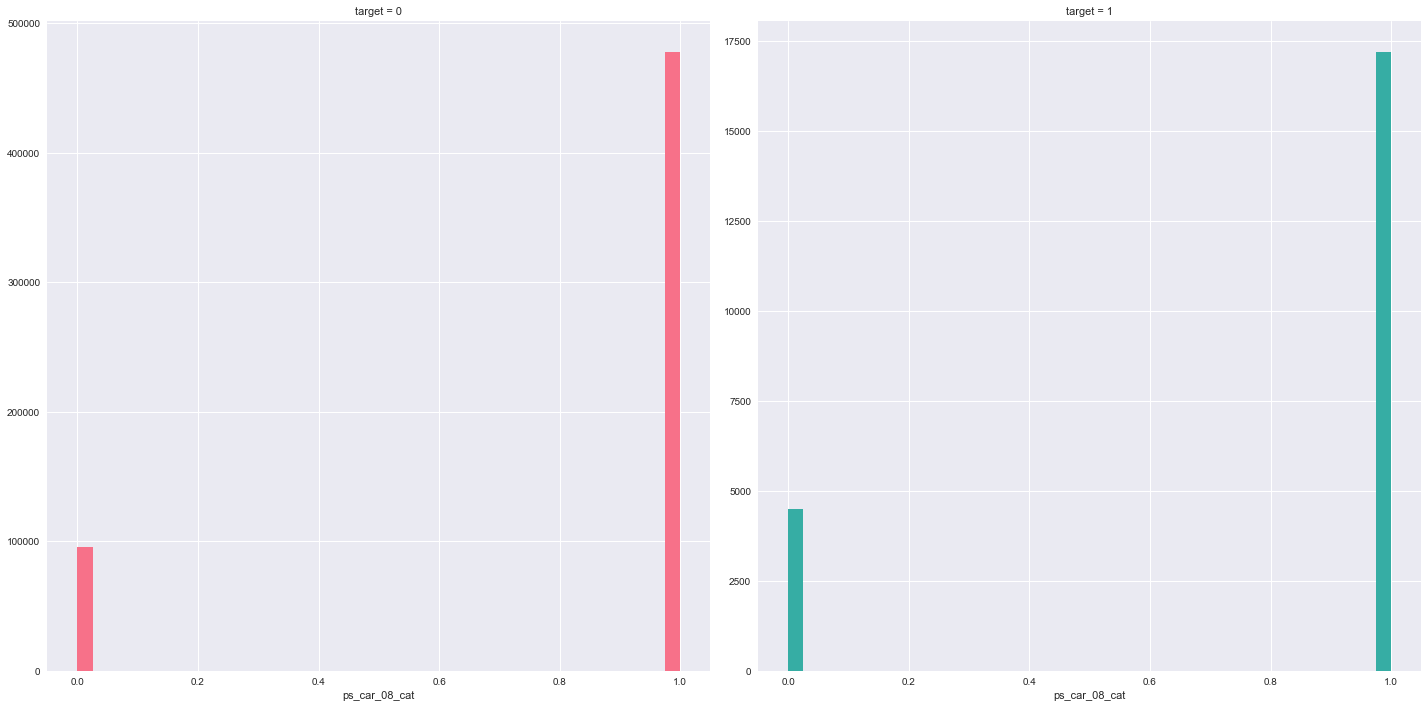

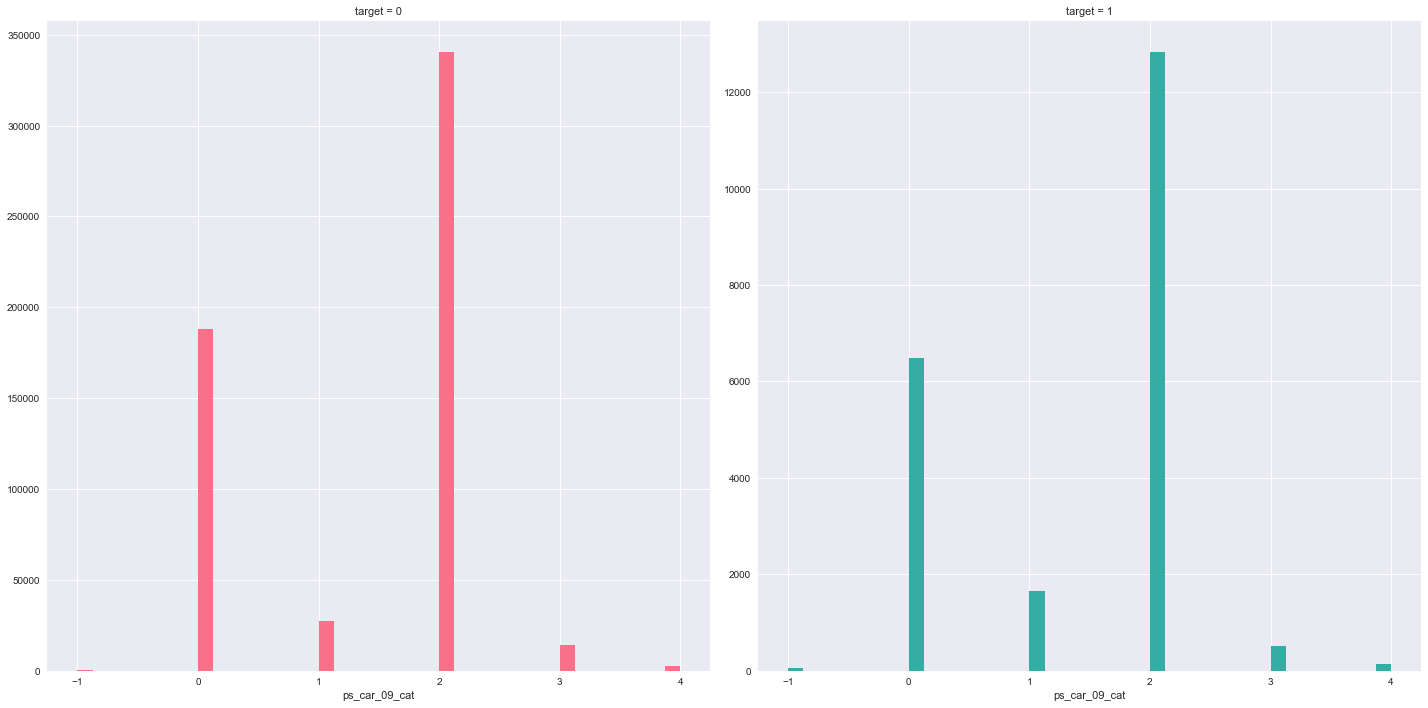

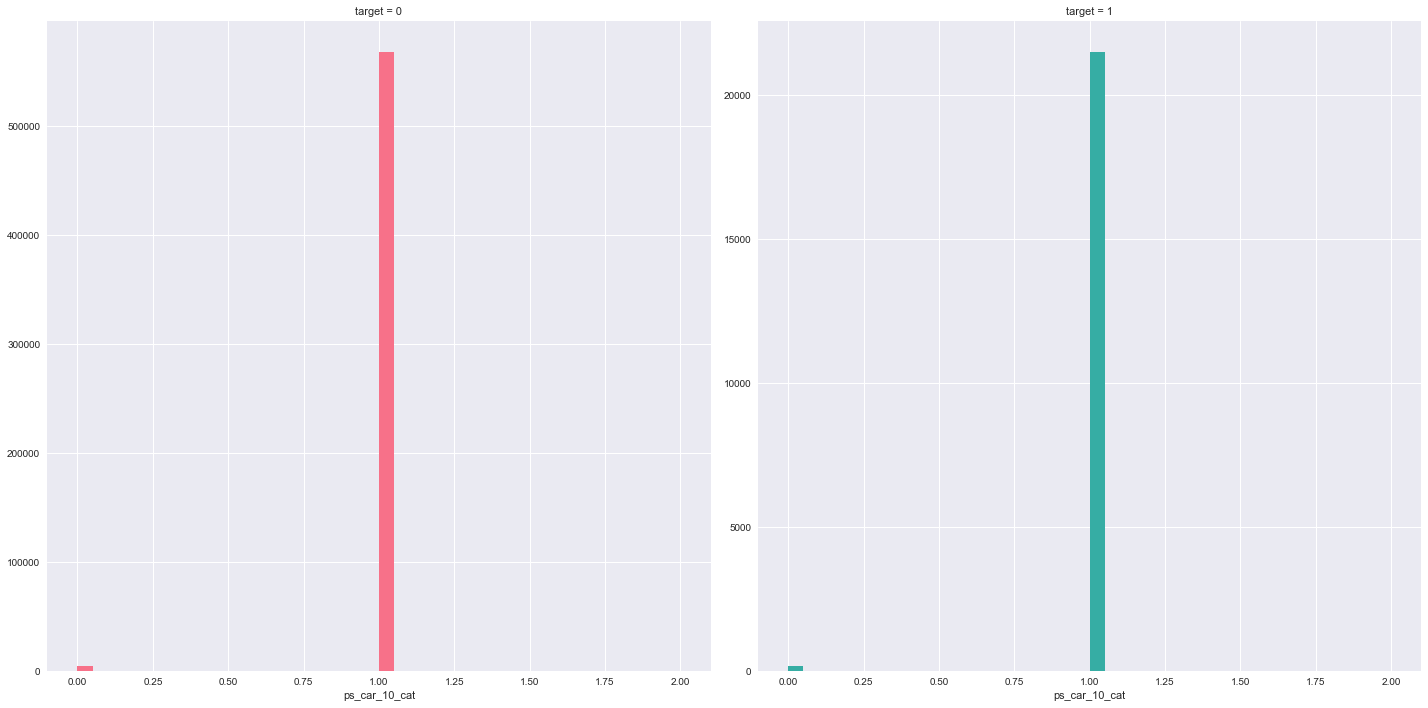

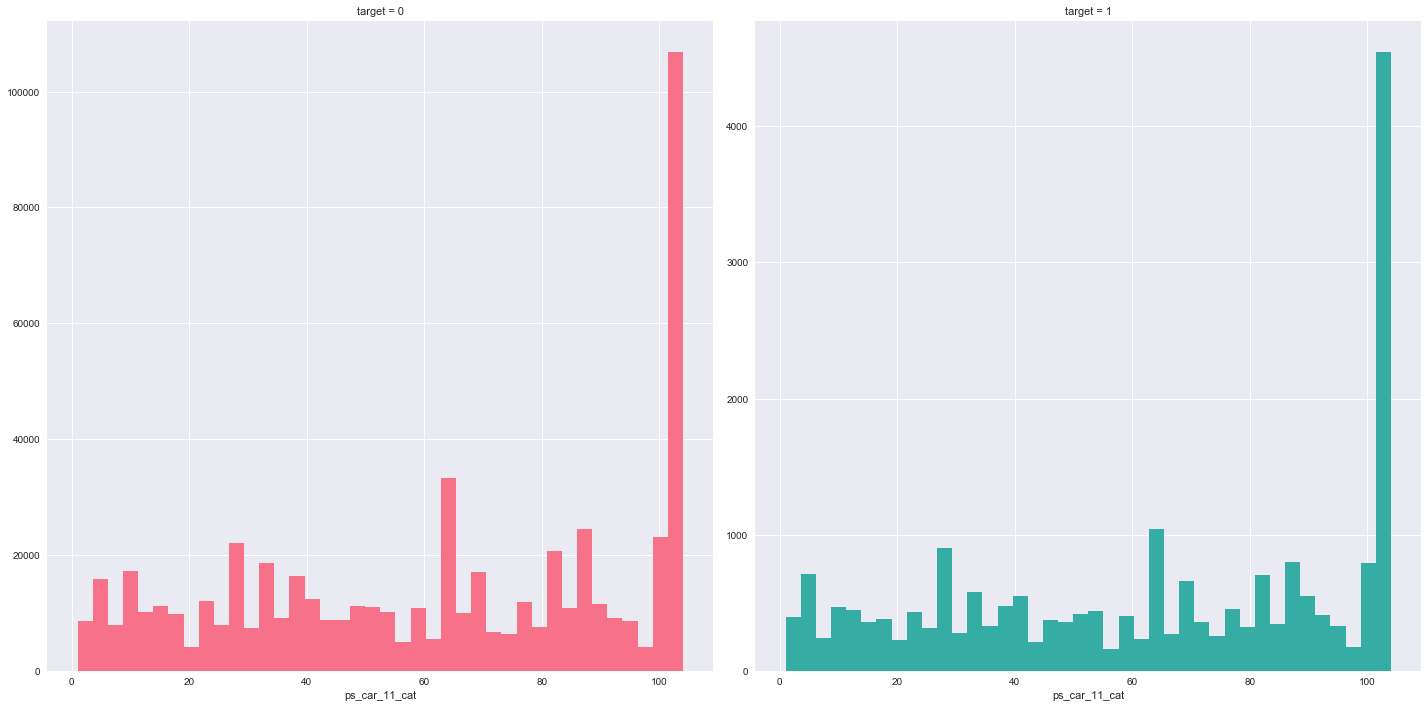

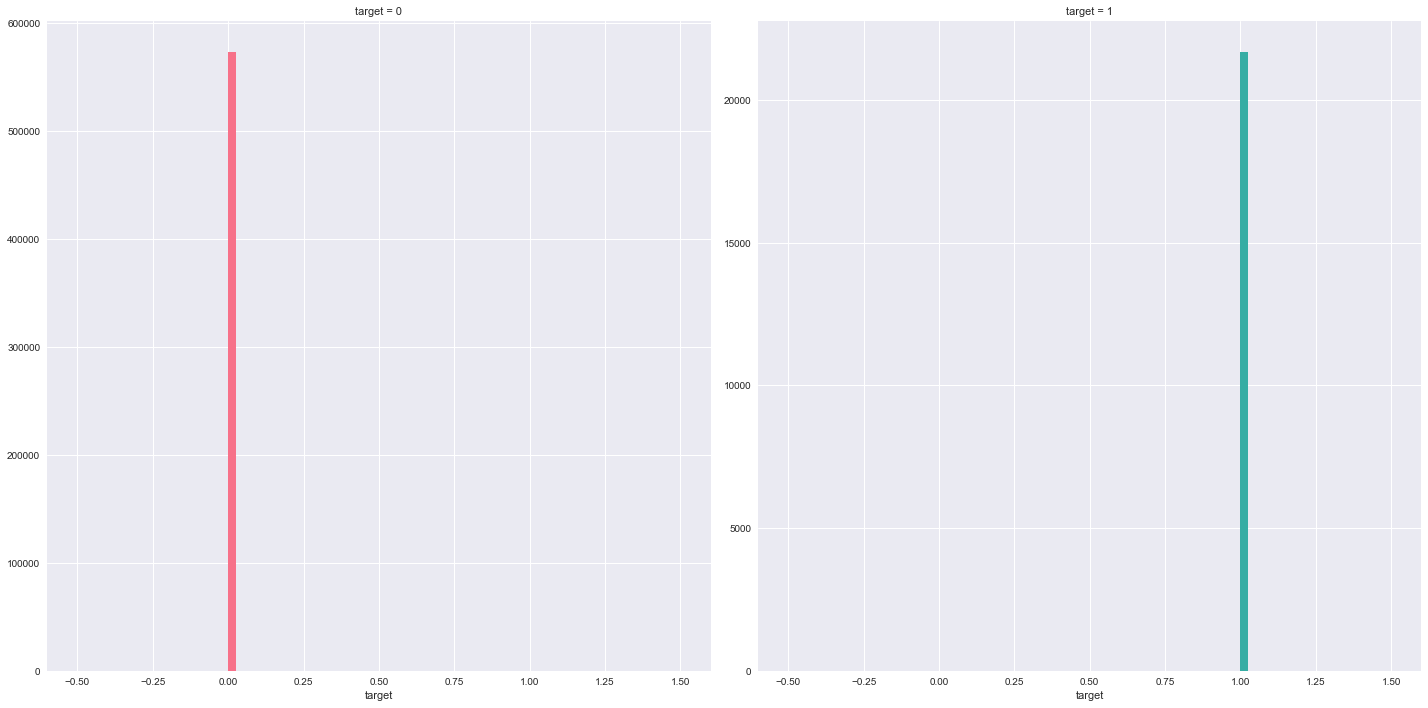

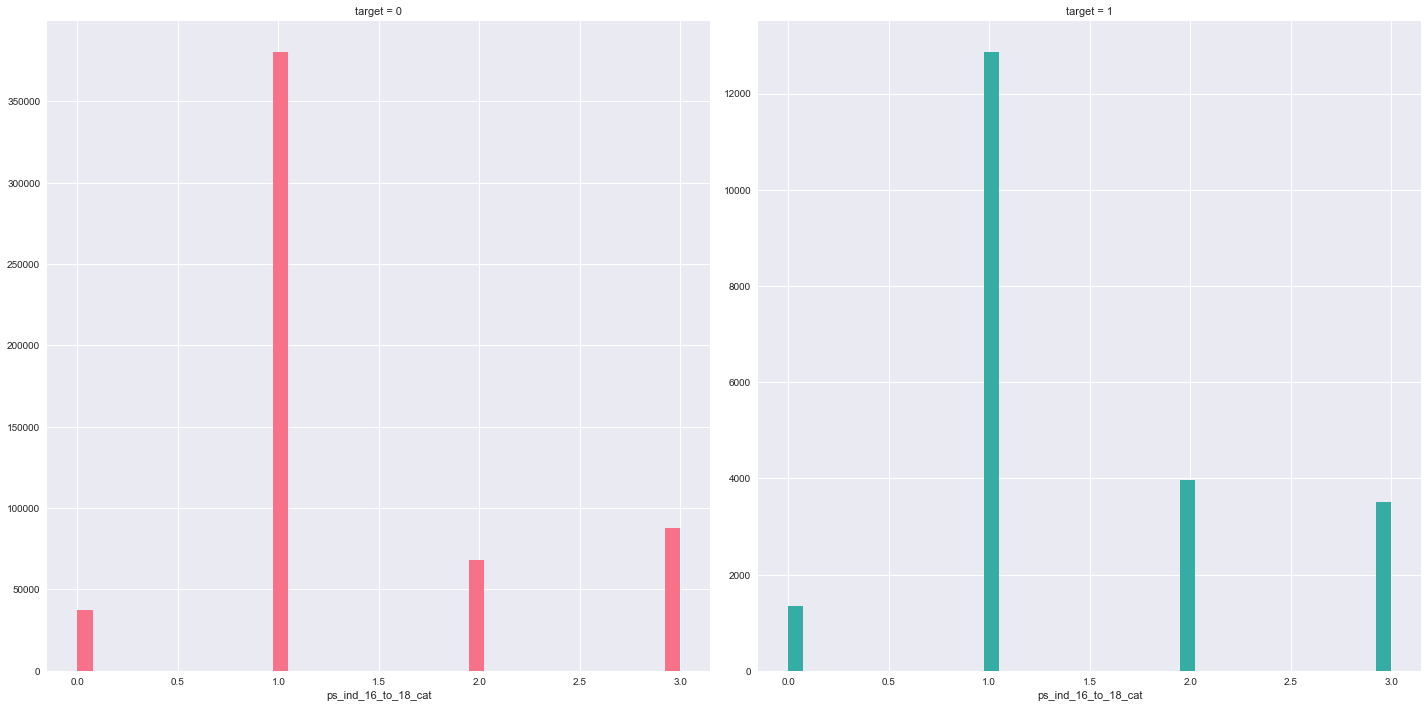

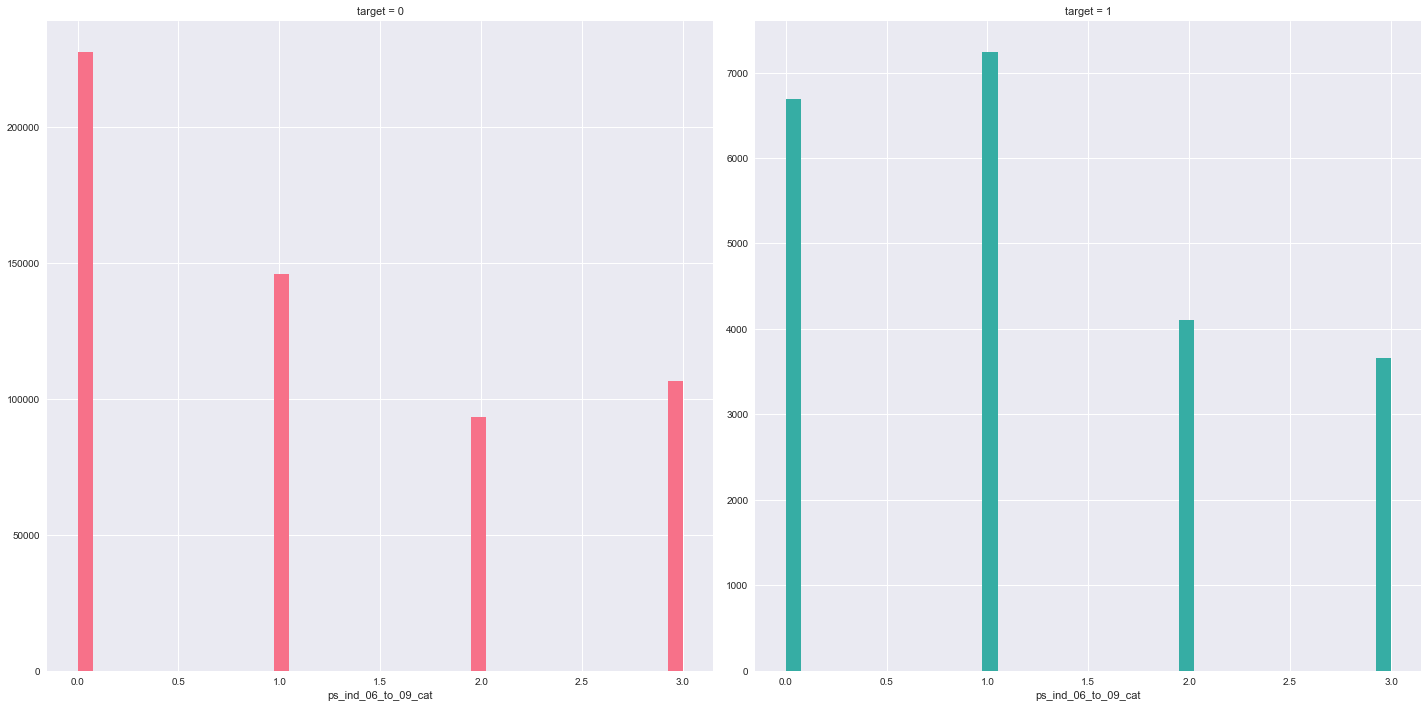

In [89]:
# produce histograms for all CATEGORICAL attributes
for col in X_cat_y_2.columns:
    g=sns.FacetGrid(X_cat_y_2,col='target',palette='husl',hue='target',size=10,sharey=False)
    g.map(plt.hist,col,bins=40);

In [166]:
Counter(X_cat_y['ps_car_10_cat'])

Counter({0: 4857, 1: 590179, 2: 176})

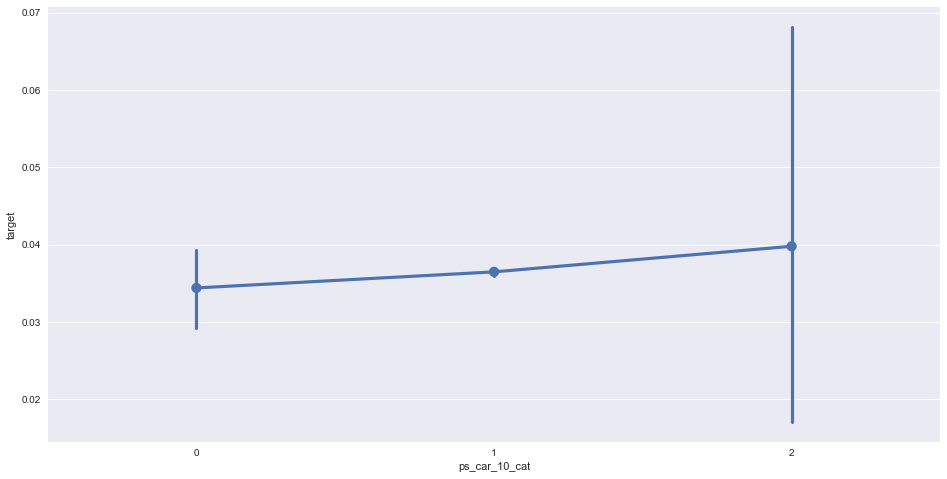

In [167]:
#col='ps_ind_06_to_09_cat'
#col='ps_ind_16_to_18_cat'
col='ps_car_10_cat'
plt.figure(figsize=(16,8))
sns.pointplot(x=col,y='target',data=X_cat_y_2);

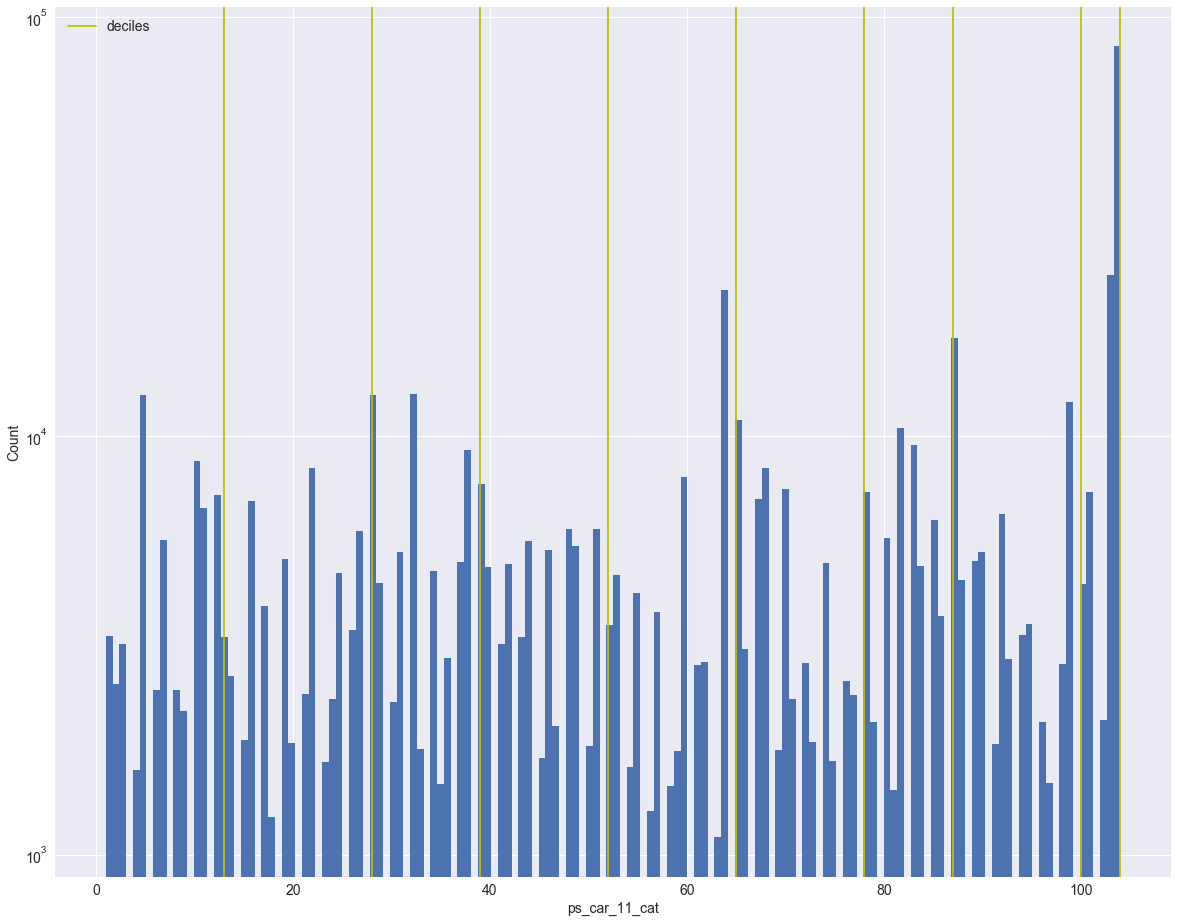

In [45]:
col='ps_car_11_cat'
deciles=X_cat_y[col].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

#overlay deciles on histogram
fig,ax=plt.subplots(figsize=(20,16))
X_cat_y[col].hist(ax=ax,bins=150)
for pos in deciles:
    handle=plt.axvline(pos,color='y')
ax.legend([handle],['deciles'],fontsize=14)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel(col,fontsize=14)
ax.set_ylabel('Count',fontsize=14)
plt.show()

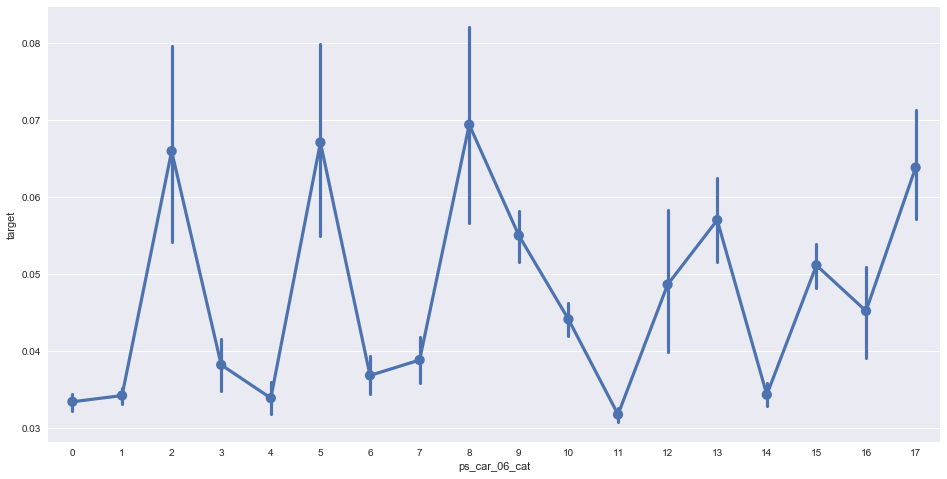

In [177]:
# qauntization
temp=X_cat_y.copy()
from_col='ps_car_06_cat'
to_col='ps_car_06_cat_binned'
temp[to_col]=pd.qcut(temp[from_col],4,labels=False,duplicates='drop')

# plot quantized continuous variable
plt.figure(figsize=(16,8))
sns.pointplot(x=from_col,y='target',data=temp);

In [88]:
X_cat_y_2=pd.concat([X_cat_y,cols_selected_2],axis=1)
print(X_cat_y_2.columns)

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'target', 'ps_ind_16_to_18_cat',
       'ps_ind_06_to_09_cat'],
      dtype='object')


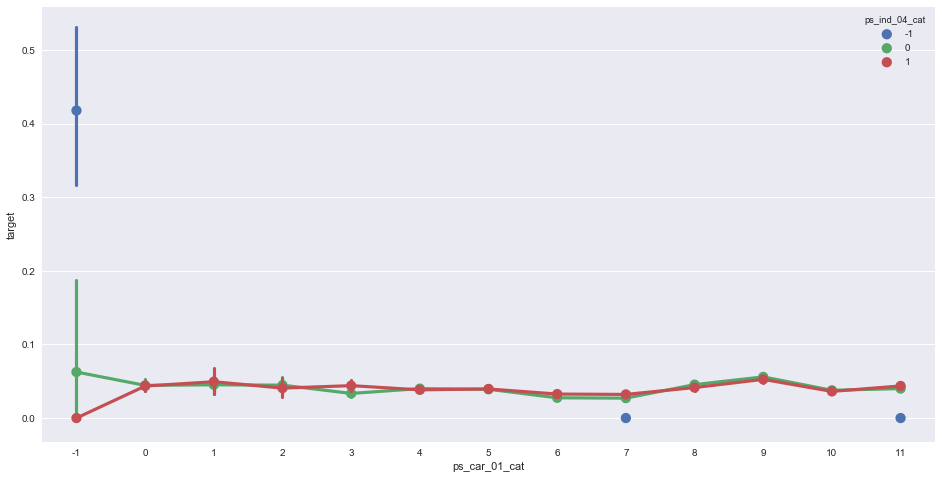

In [24]:
# qauntization
temp=X_cat_y.copy()
from_col='ps_car_01_cat'
to_col='ps_car_01_binned'
temp[to_col]=pd.qcut(temp[from_col],10,labels=False,duplicates='drop')
from_col_2='ps_ind_04_cat'
to_col_2='ps_ind_04_cat_binned'
temp[to_col_2]=pd.qcut(temp[from_col_2],4,labels=False,duplicates='drop')

# interaction plot 
plt.figure(figsize=(16,8))
sns.pointplot(x=from_col,y='target',hue=from_col_2,data=temp);

#### Ordinal Attributes

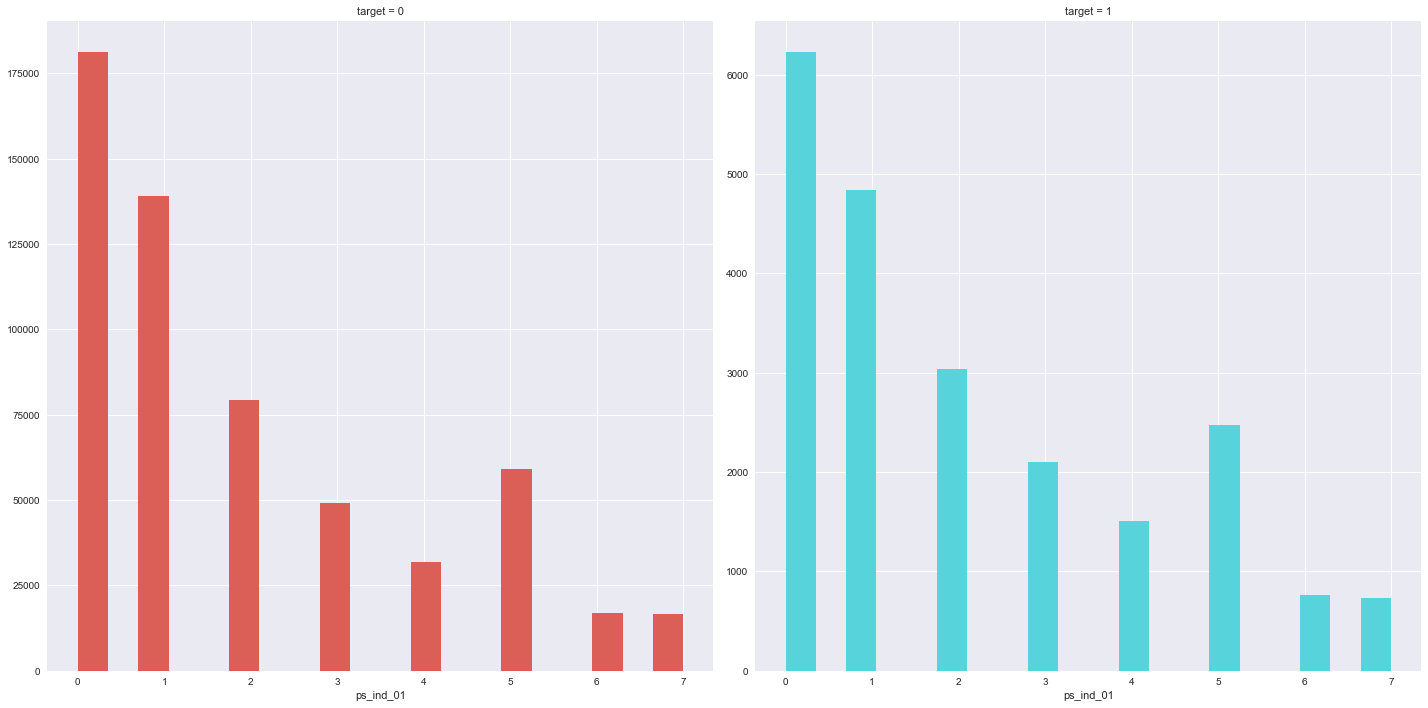

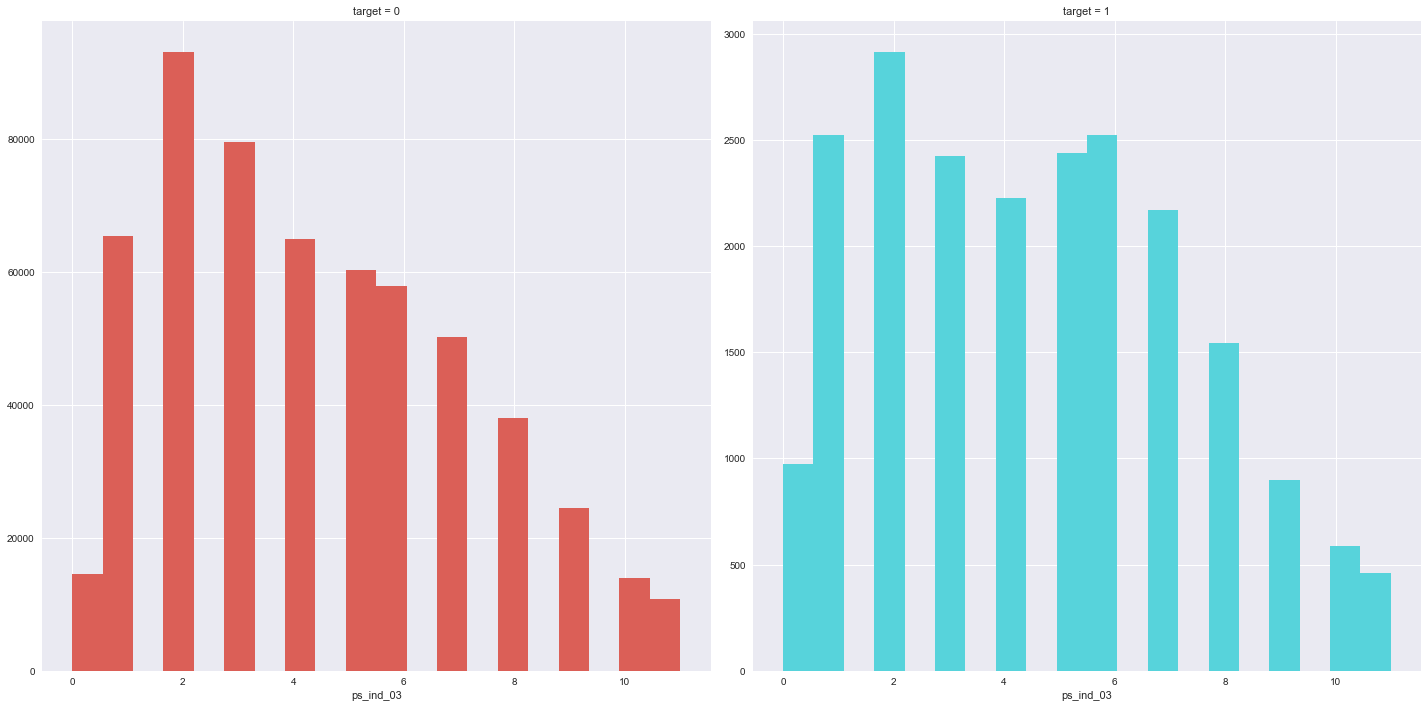

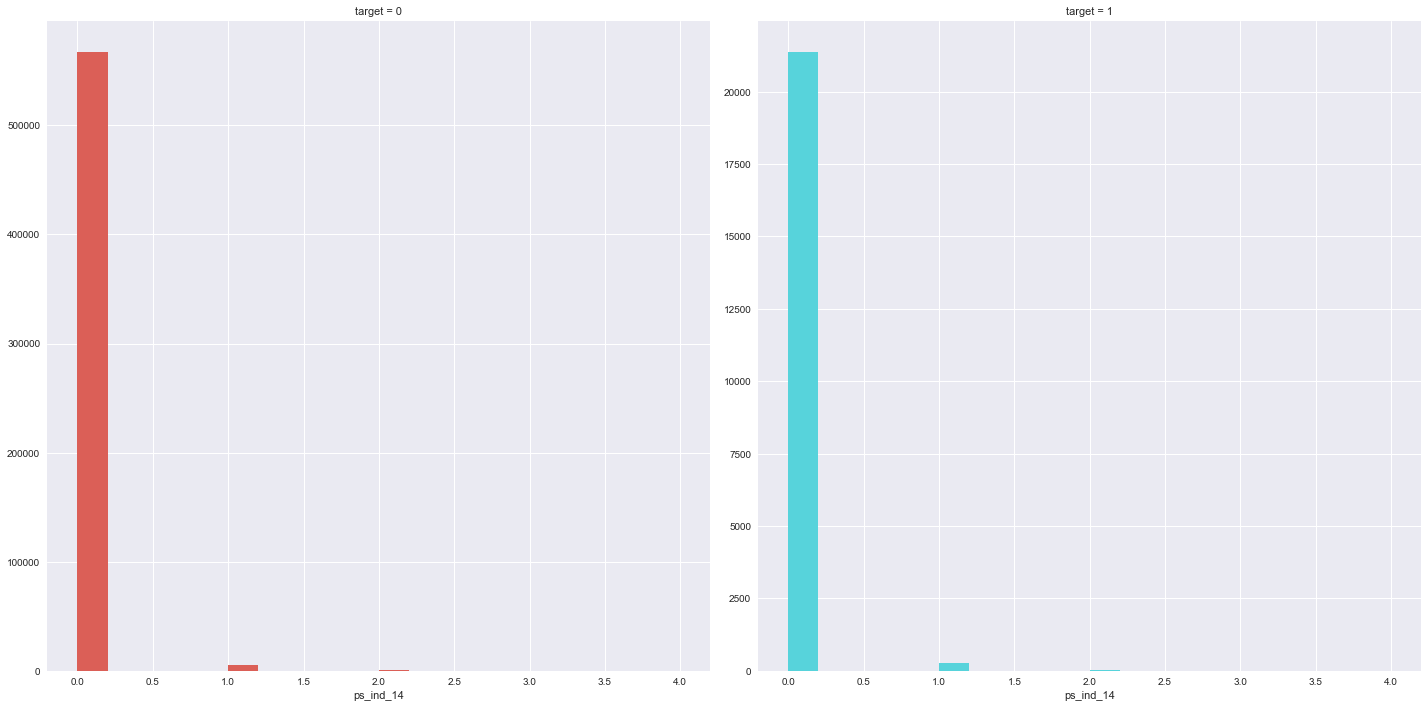

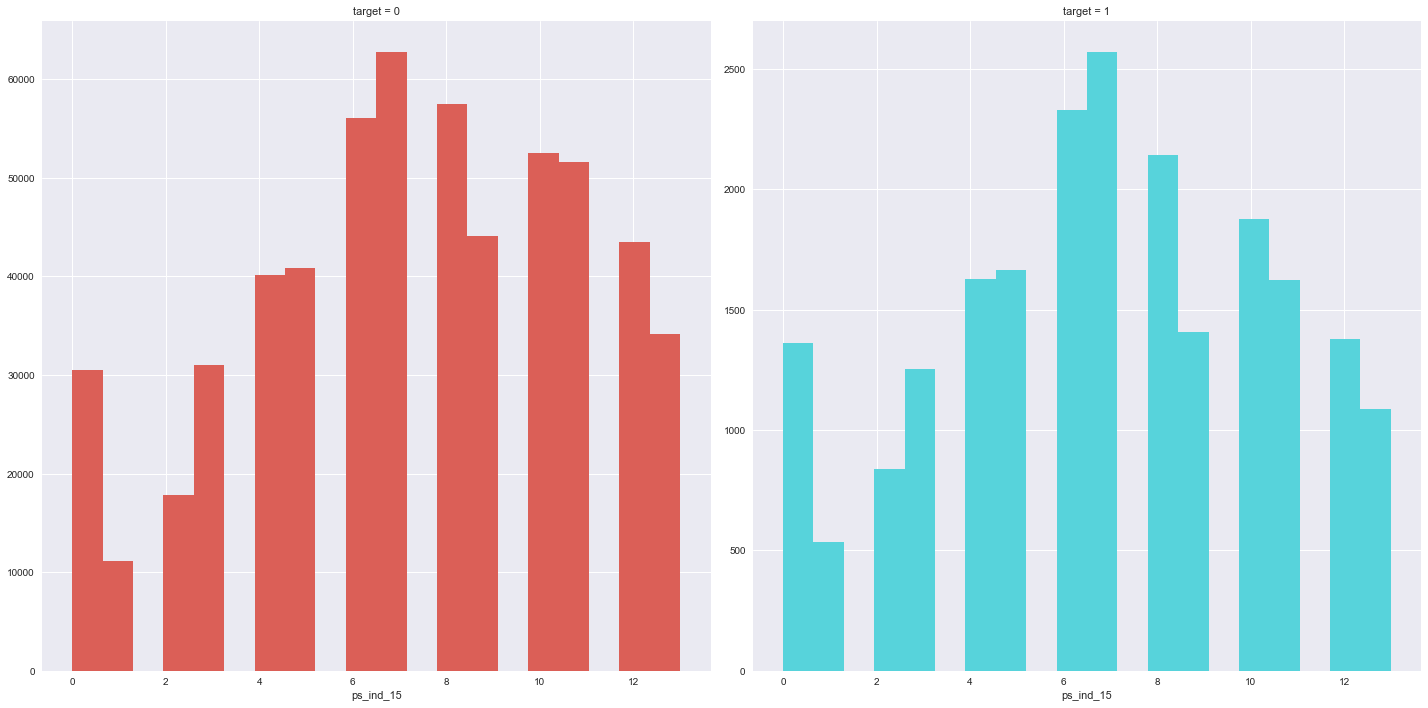

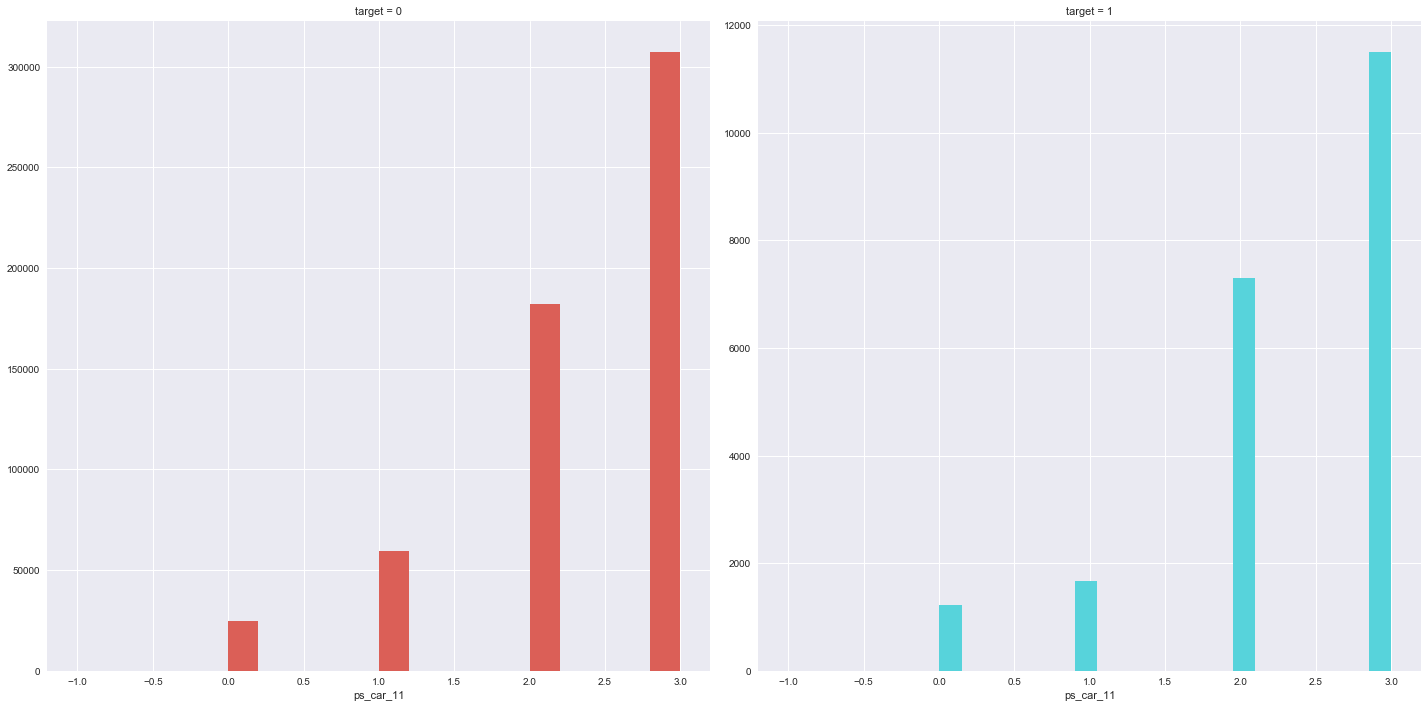

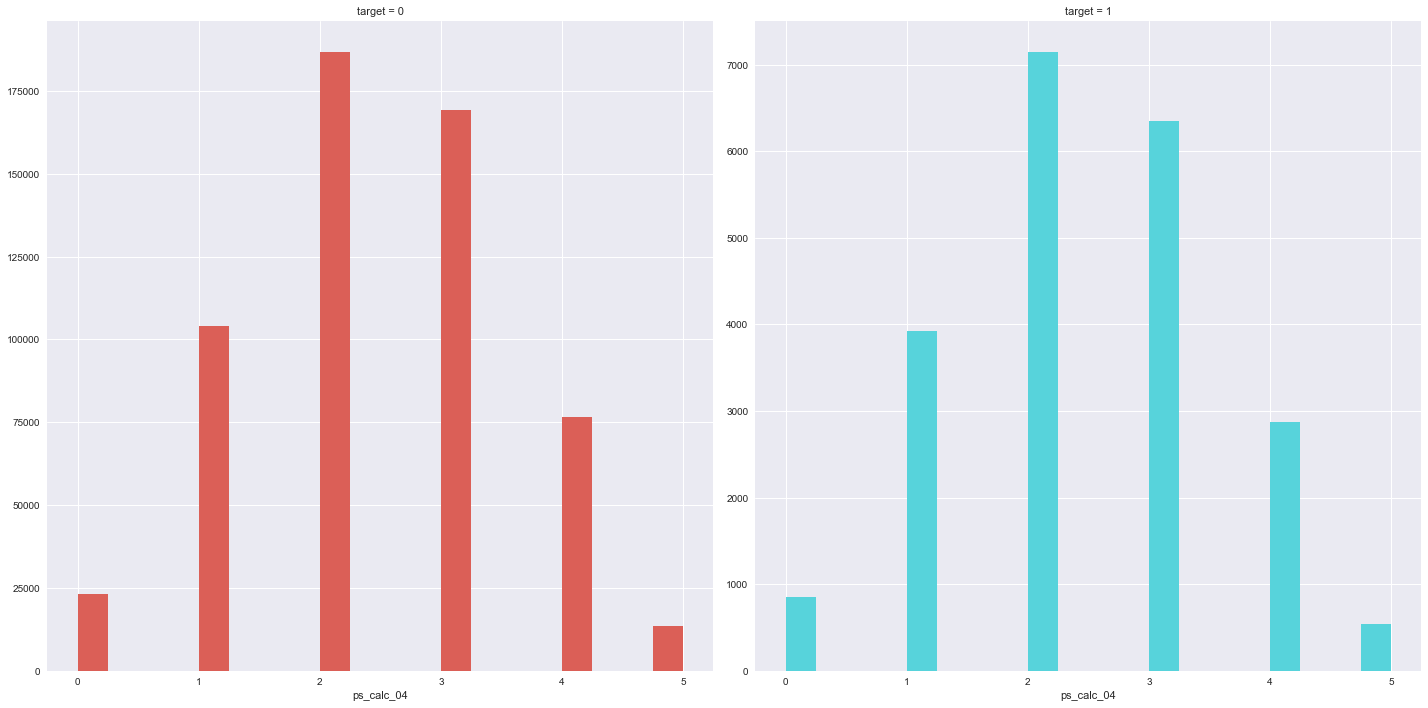

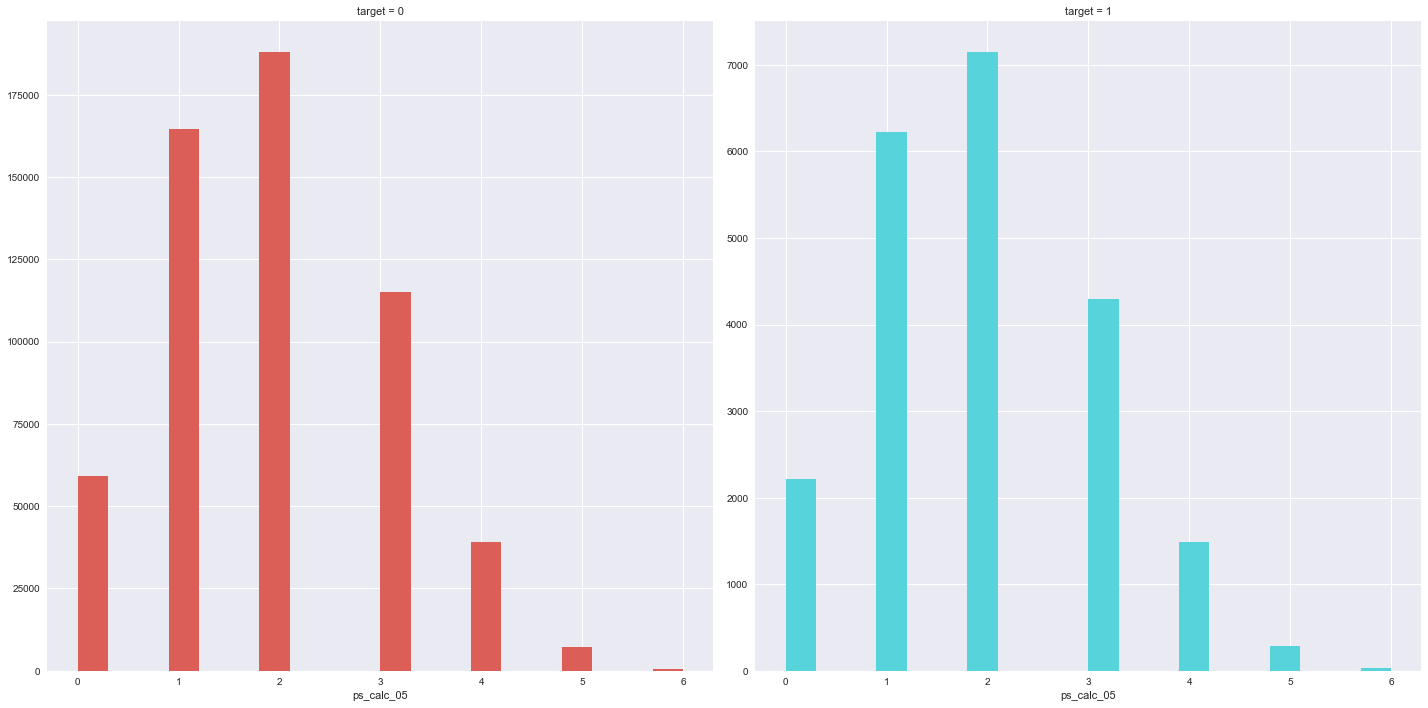

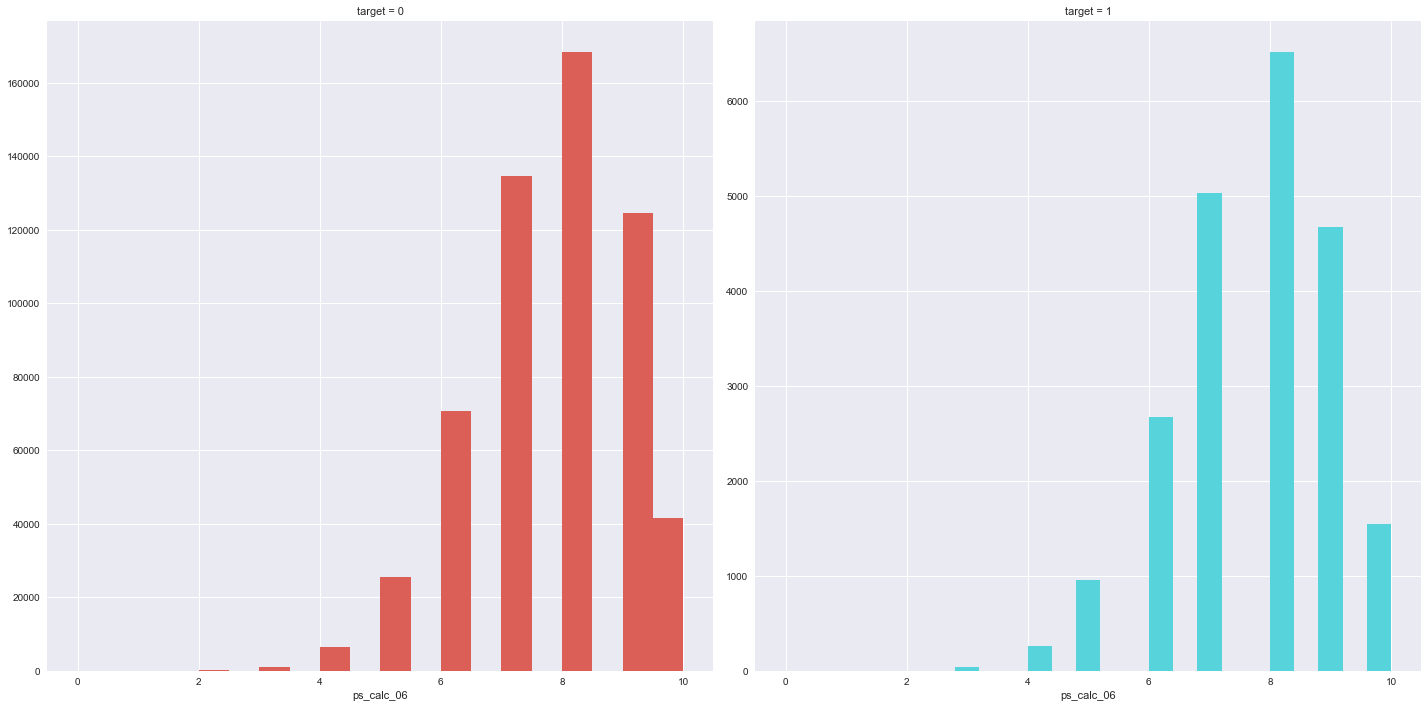

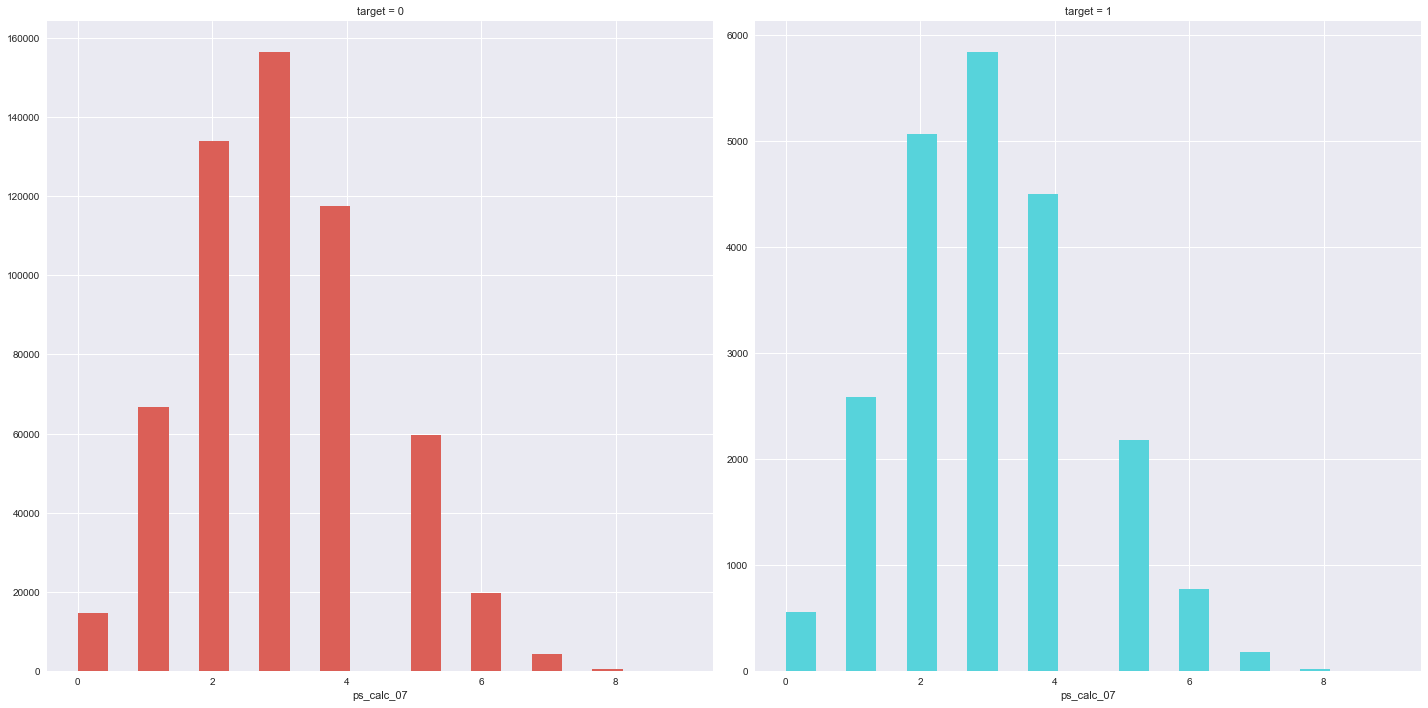

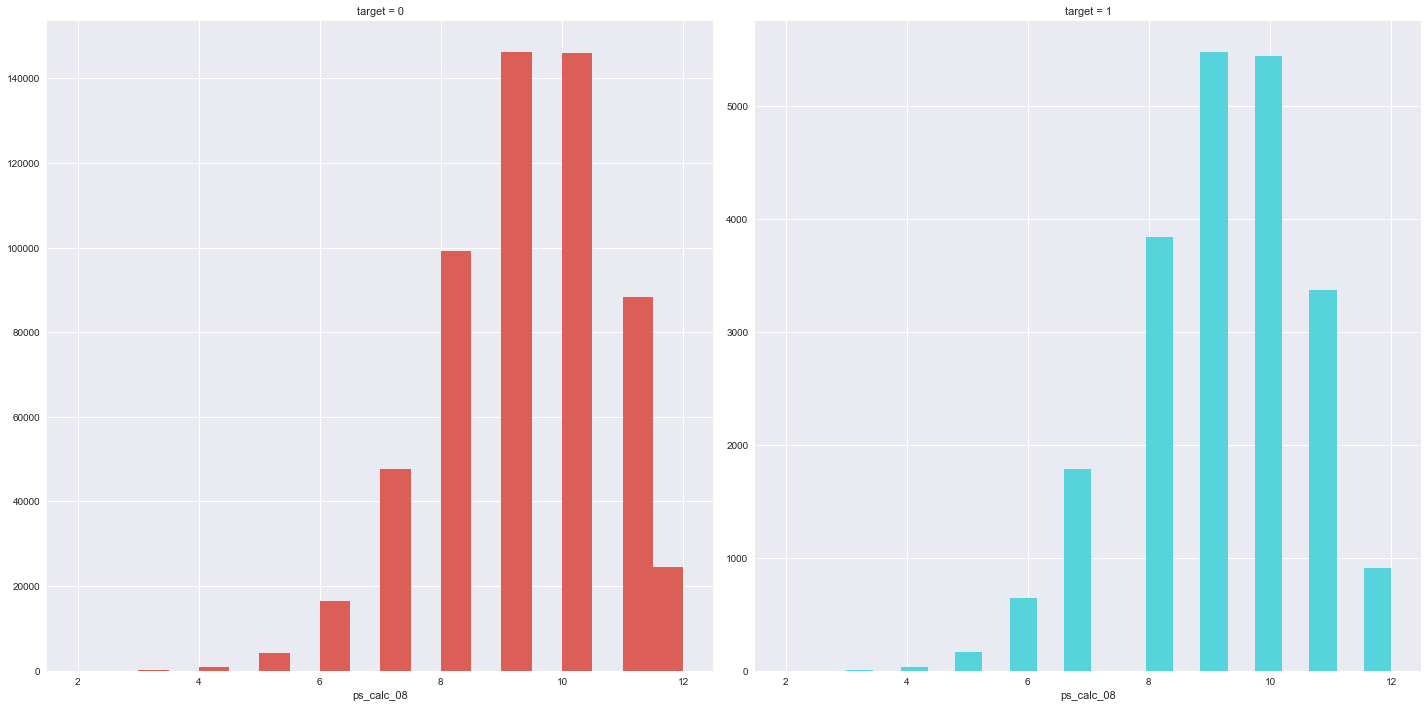

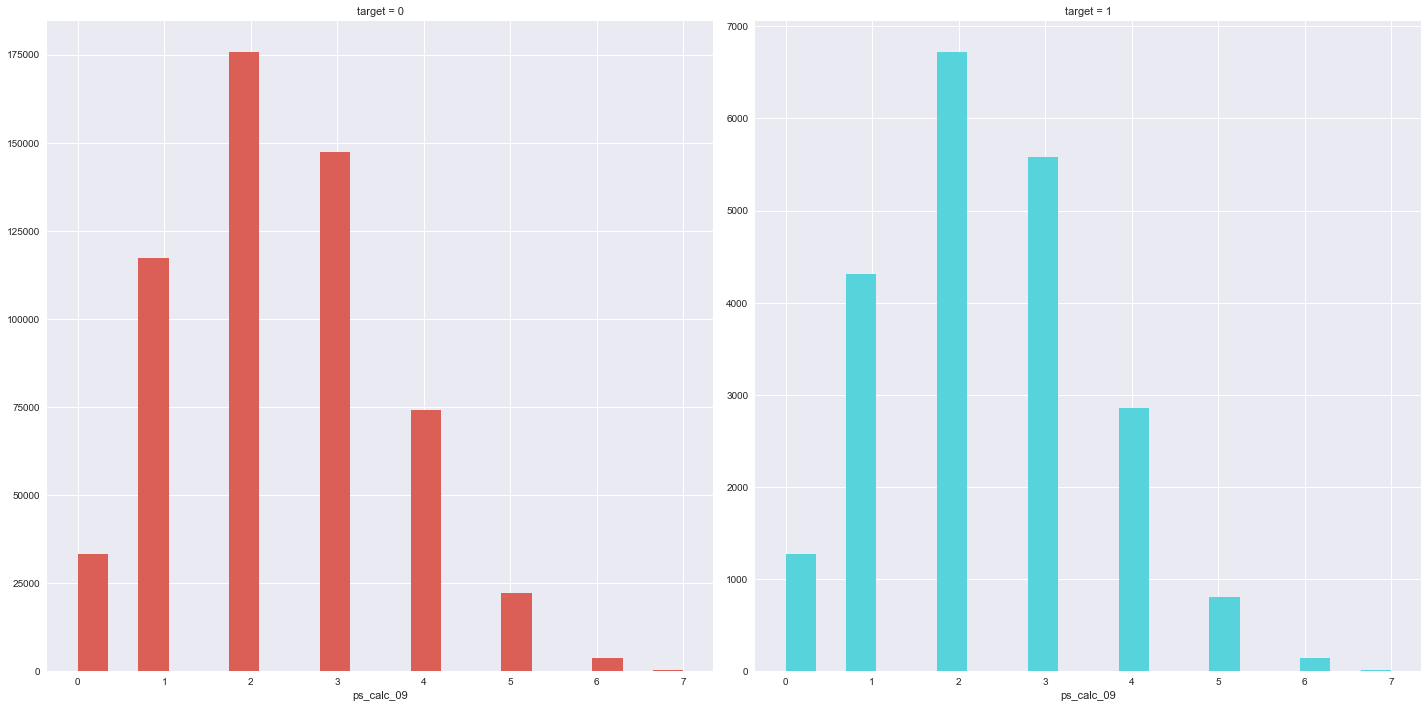

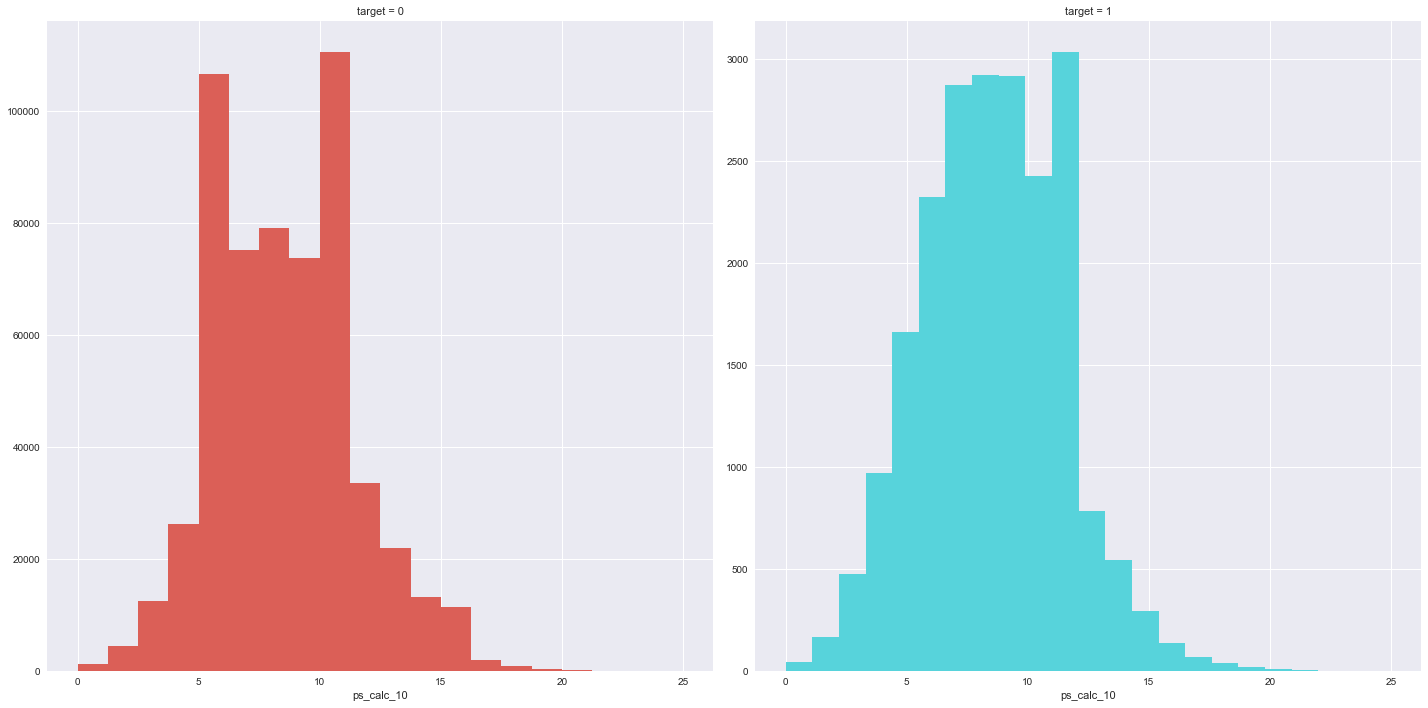

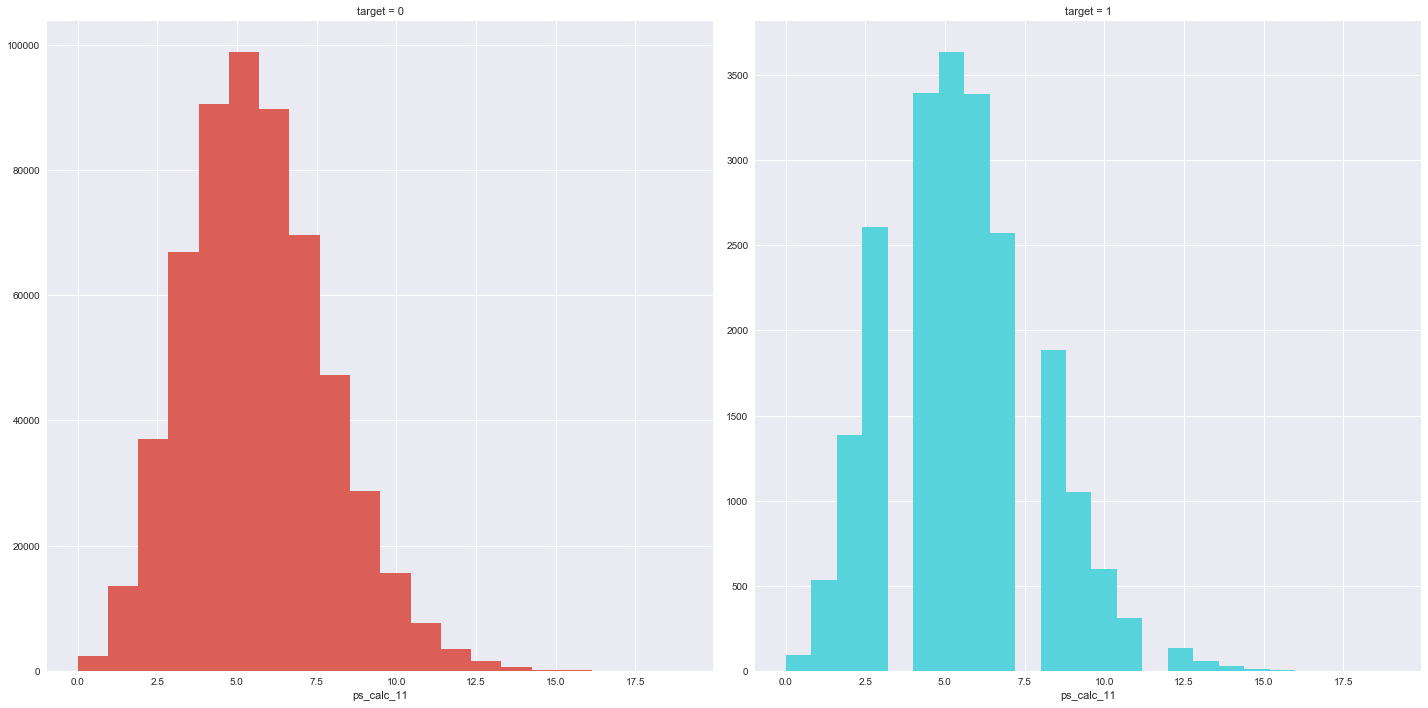

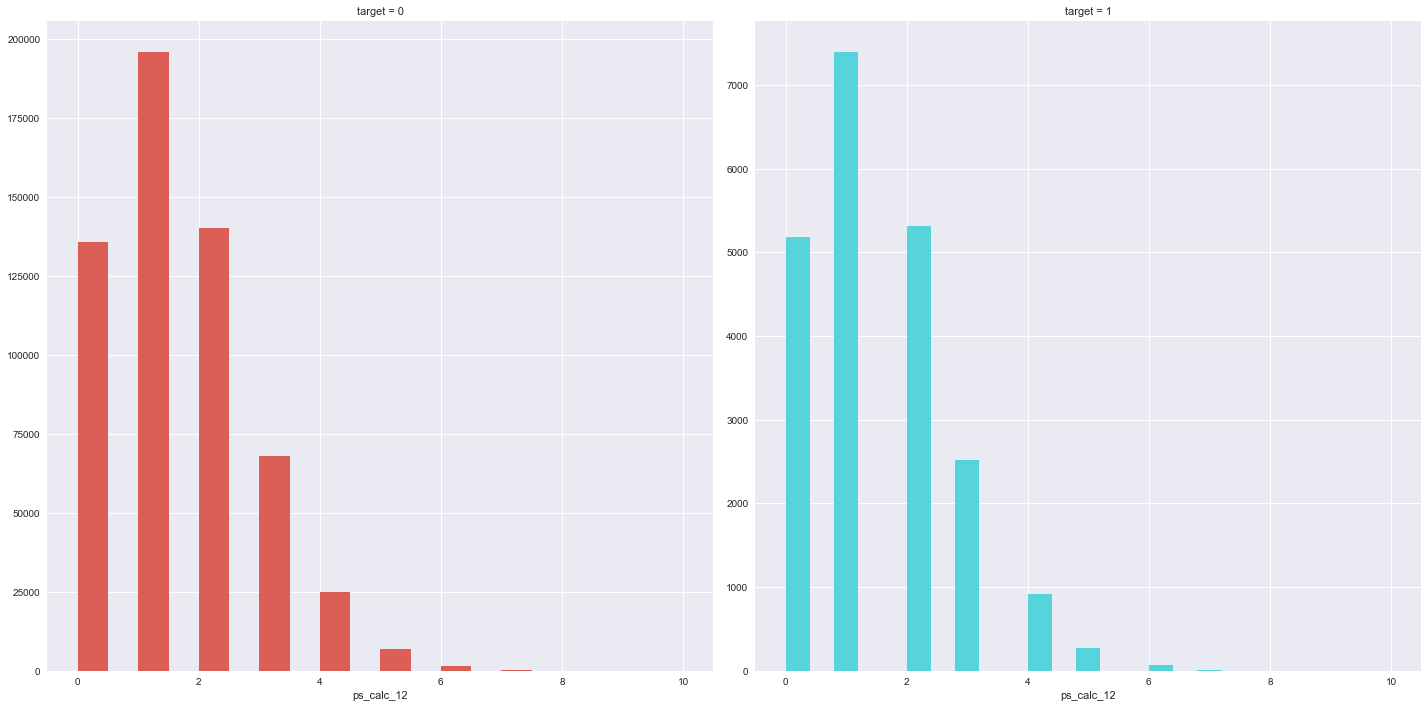

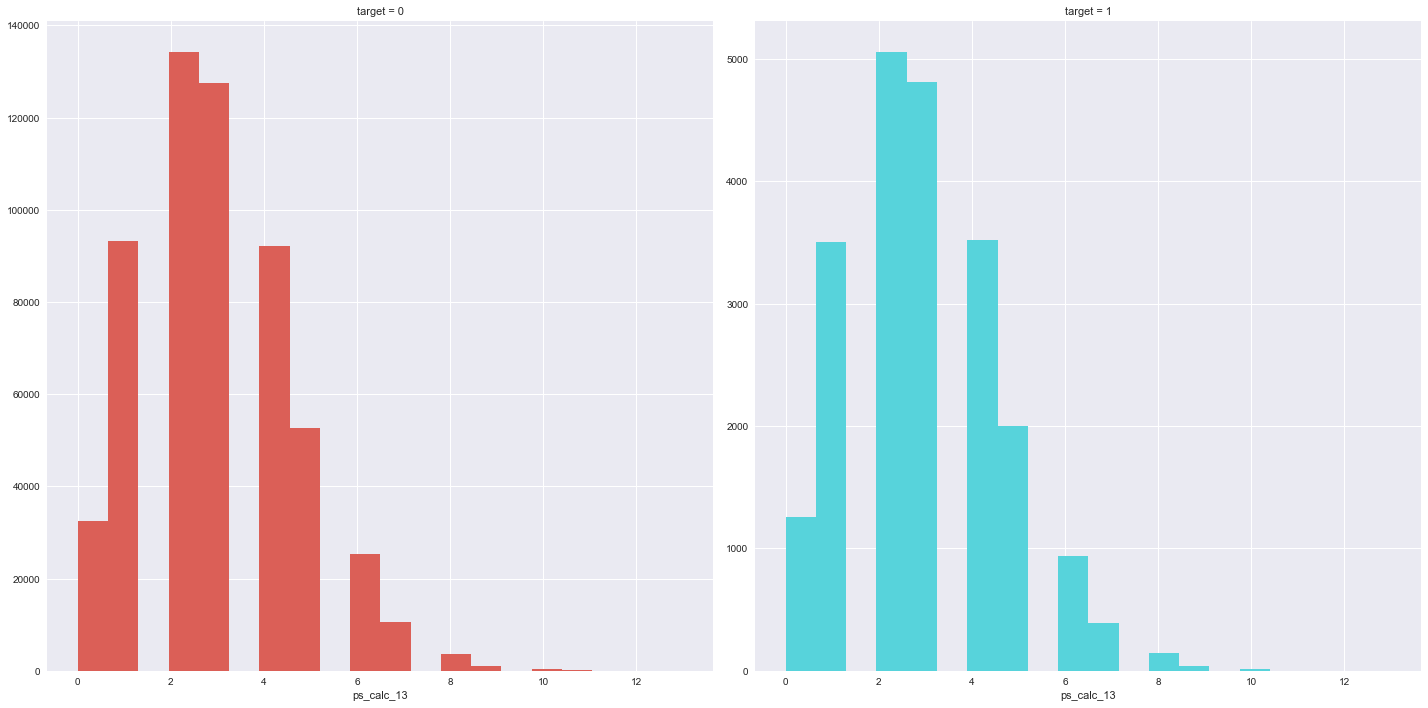

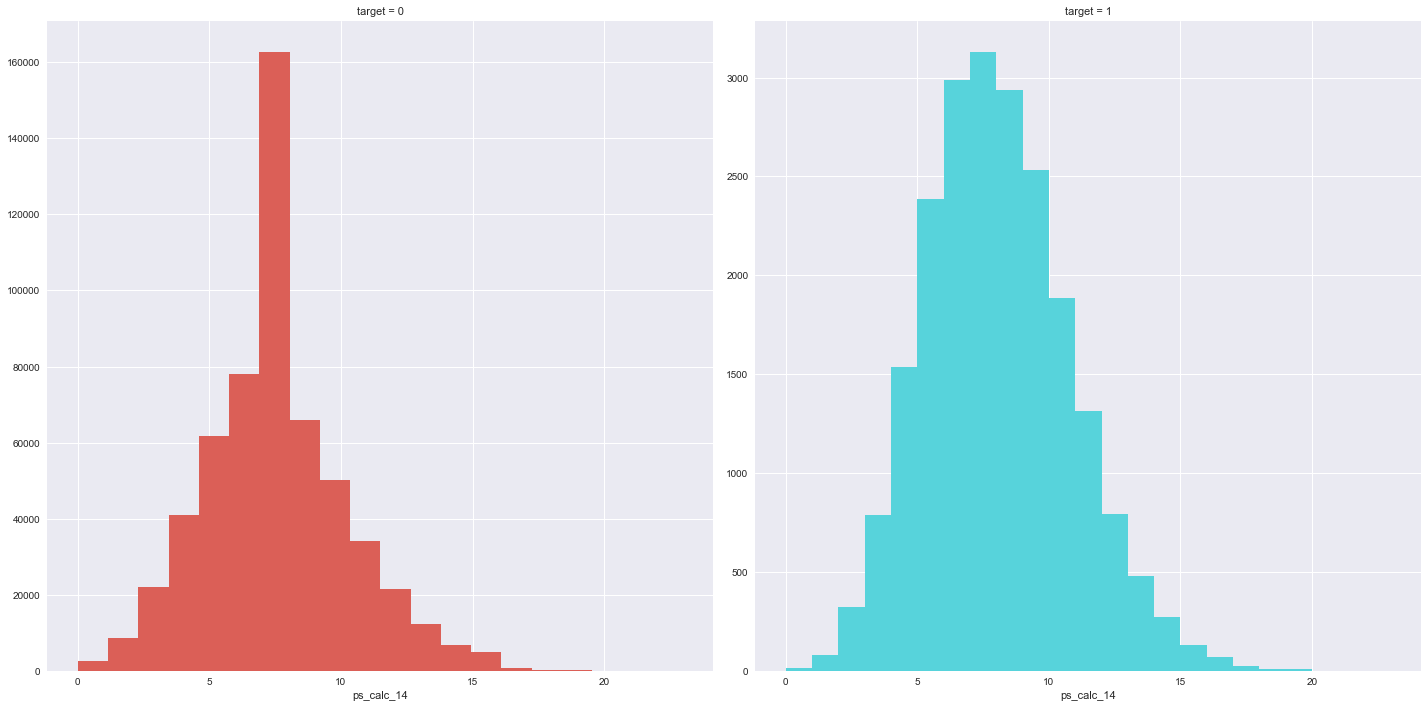

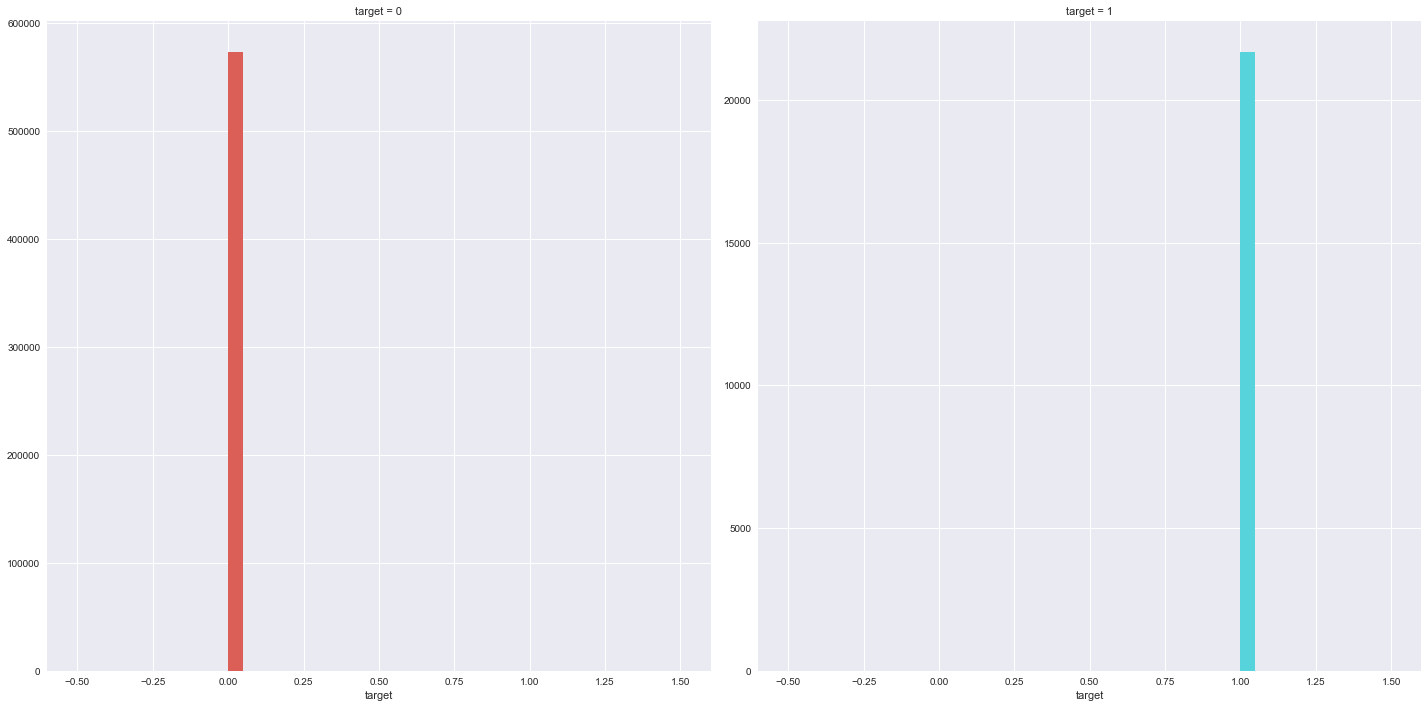

In [13]:
# produce histograms for all ORDINAL attributes
for col in X_ord_y.columns:
    g=sns.FacetGrid(X_ord_y,col='target',palette='hls',hue='target',size=10,sharey=False)
    g.map(plt.hist,col,bins=20);

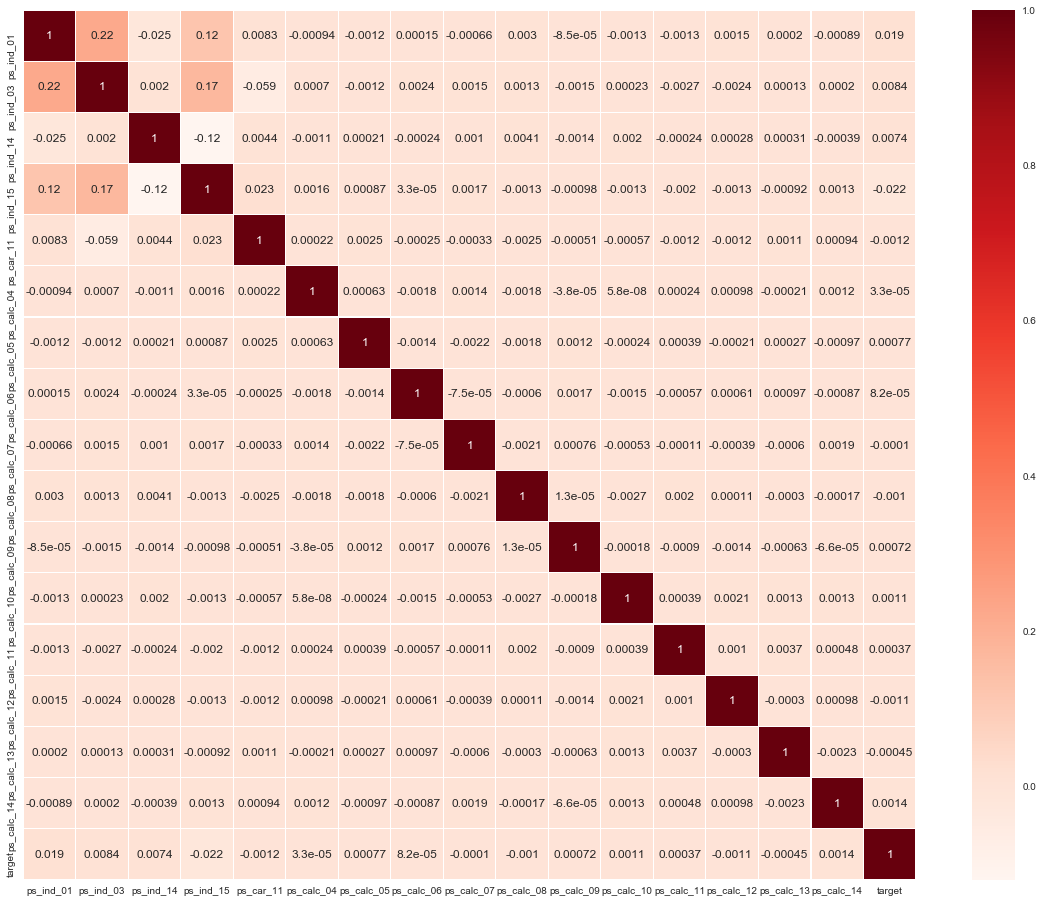

In [36]:
# produce seaborn heatmap for ORDINAL attributes
plt.figure(figsize=(20,16))
sns.heatmap(X_ord_y.corr(),cmap='Reds',annot=True,linewidths=0.1,linecolor='white');

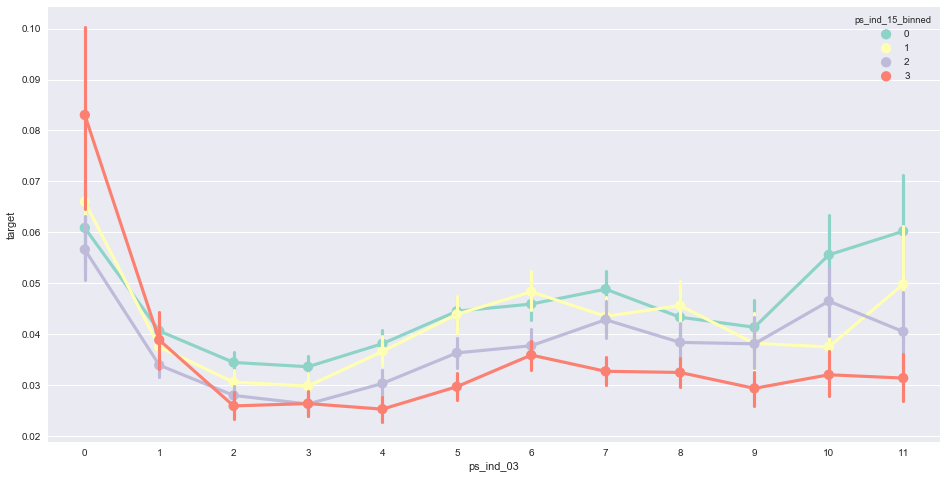

In [19]:
temp=X_ord_y.copy()
from_col='ps_ind_15'
to_col='ps_ind_15_binned'
temp[to_col]=pd.qcut(temp[from_col],4,labels=False,duplicates='drop')

col='ps_ind_03'
plt.figure(figsize=(16,8))
sns.pointplot(x=col,y='target',hue=to_col,data=temp,palette='Set3');

In [46]:
len(X_ord_y[(X_ord_y['ps_ind_01']==0) & (X_ord_y['ps_ind_03']==0)])

8709

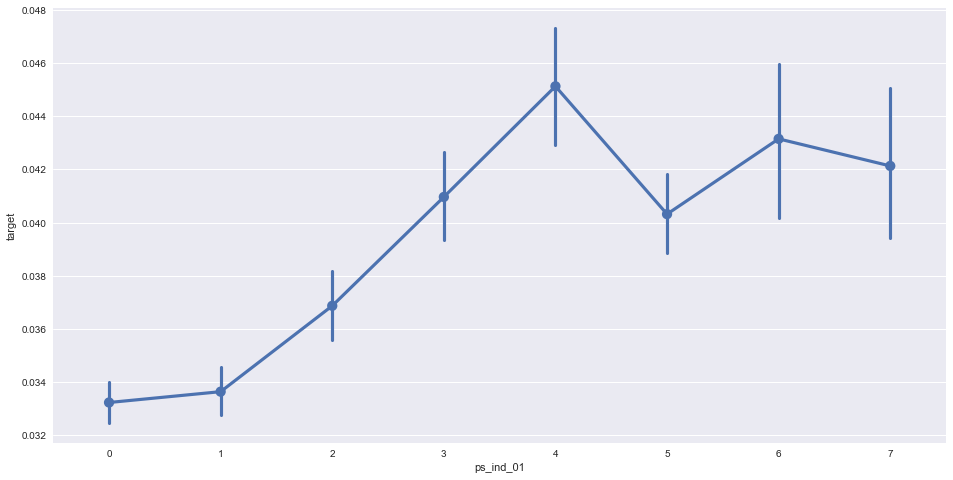

In [37]:
col='ps_ind_01'
plt.figure(figsize=(16,8))
sns.pointplot(x=col,y='target',data=X_ord_y);

#### Continuous Attributes

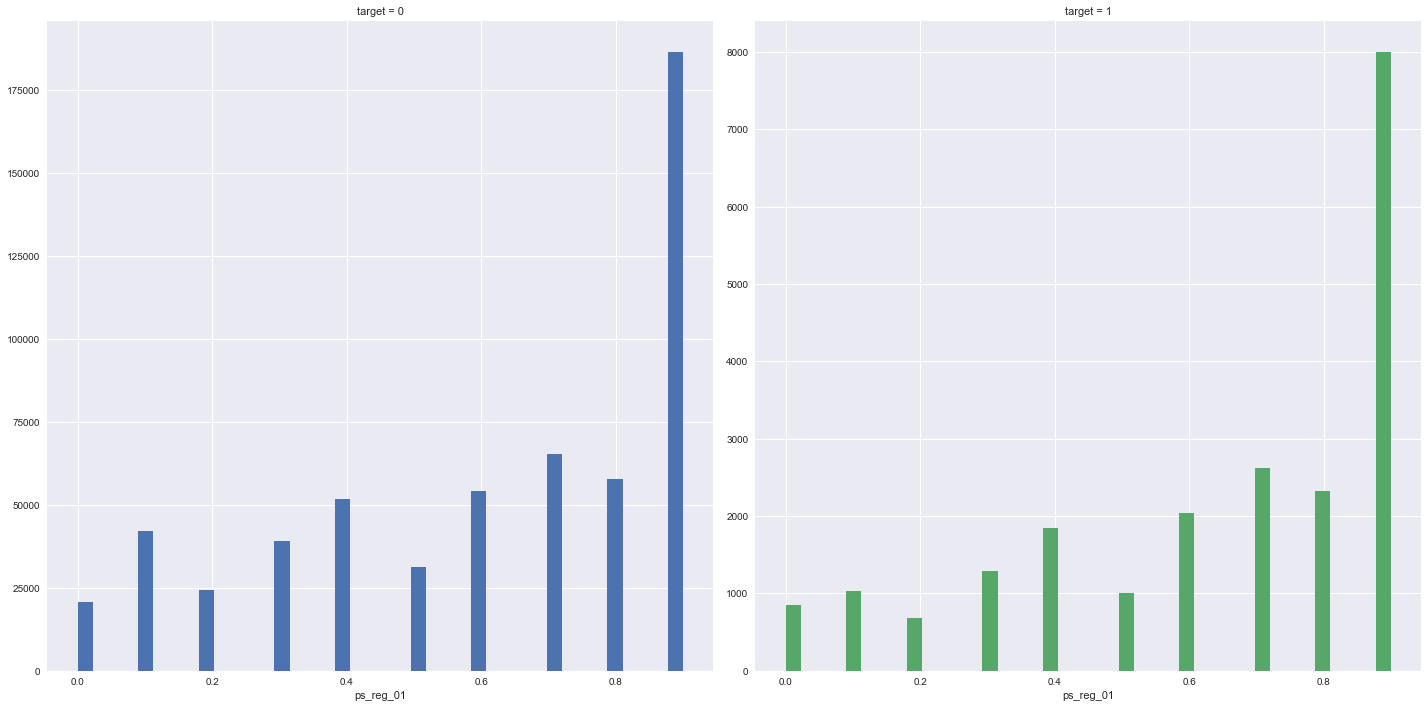

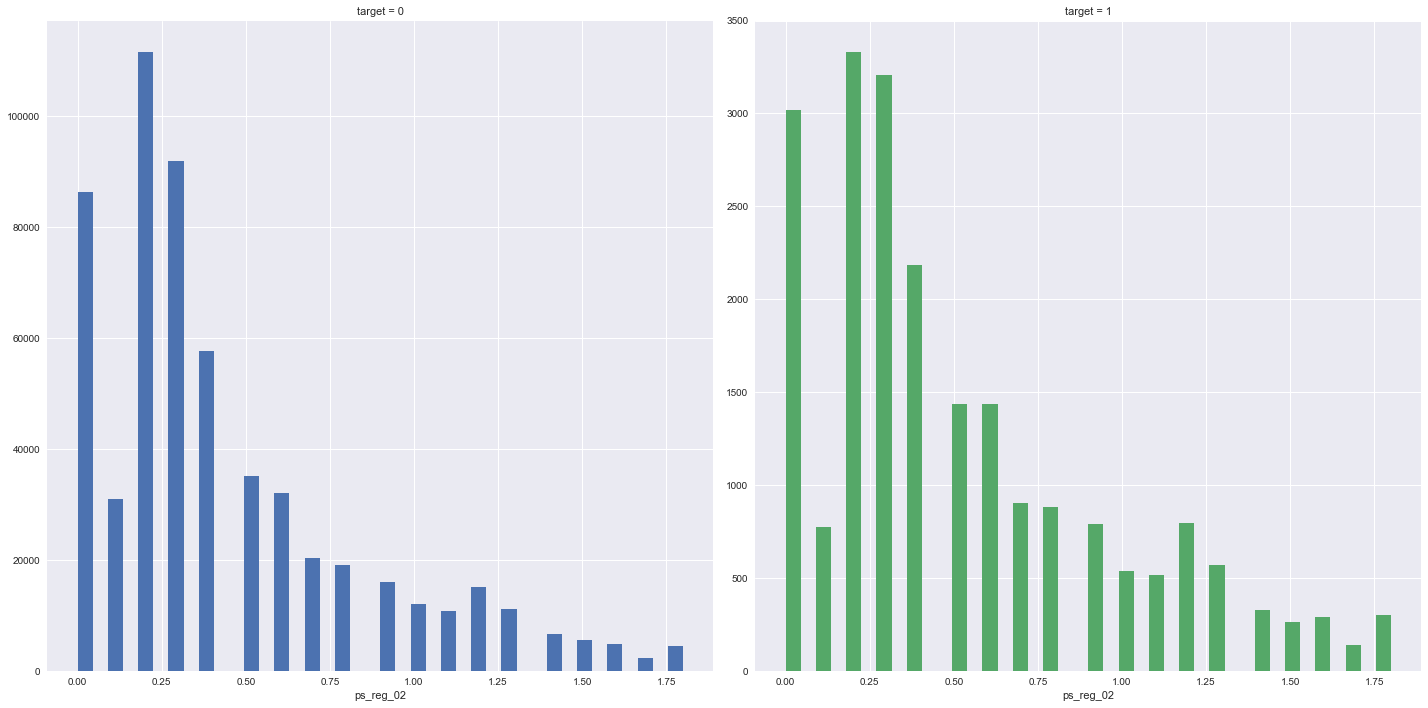

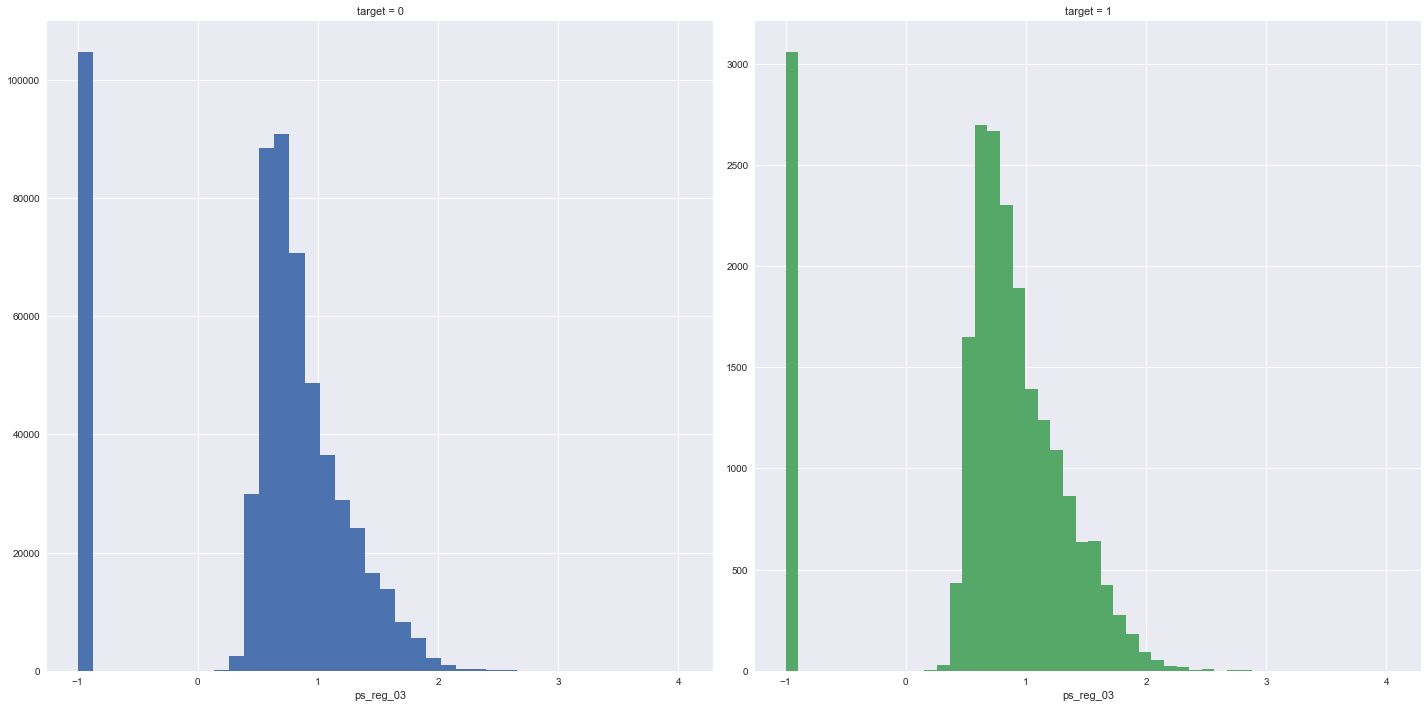

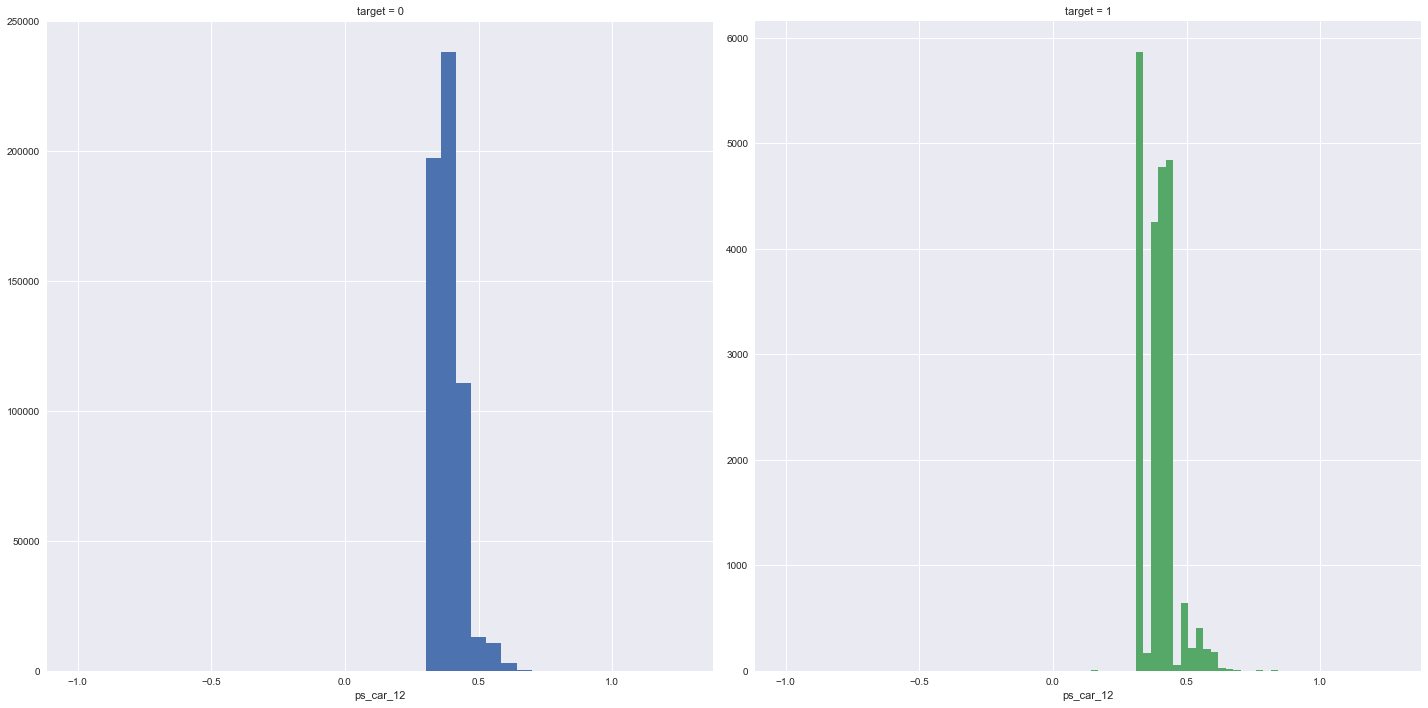

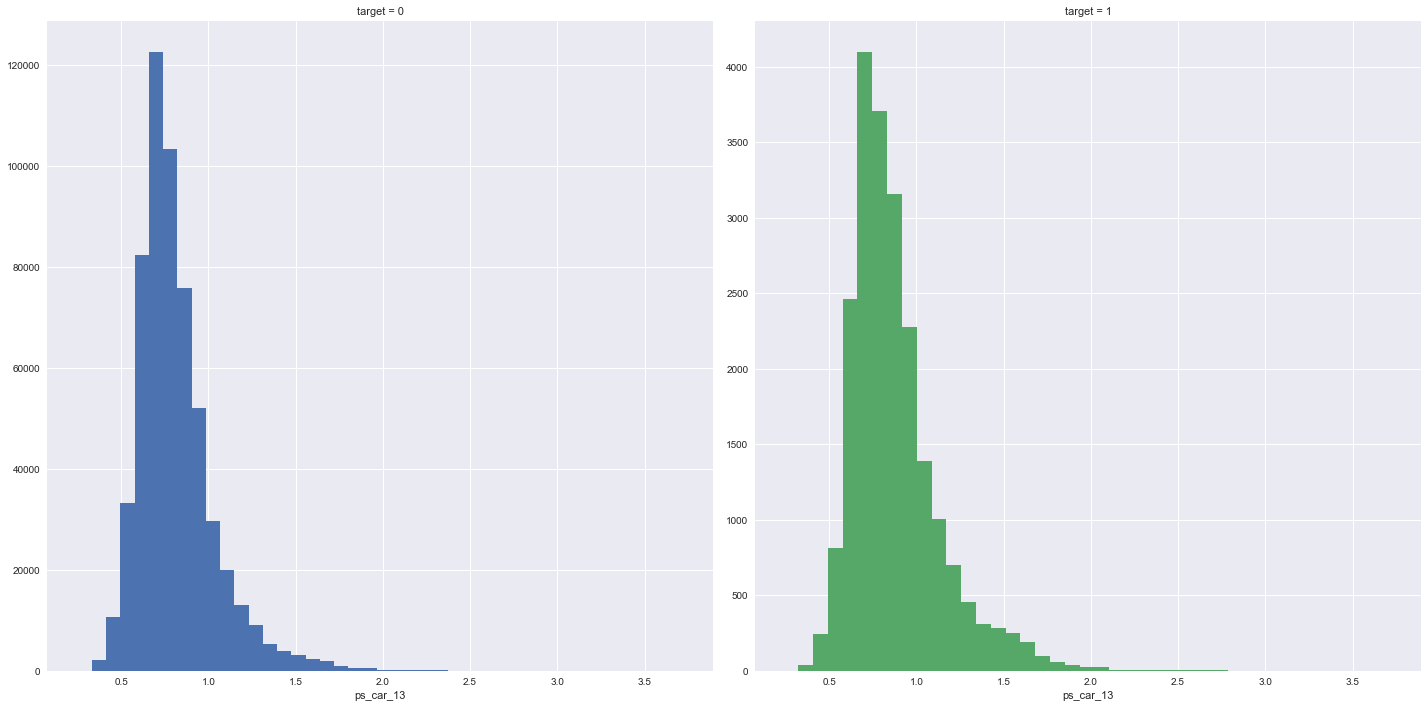

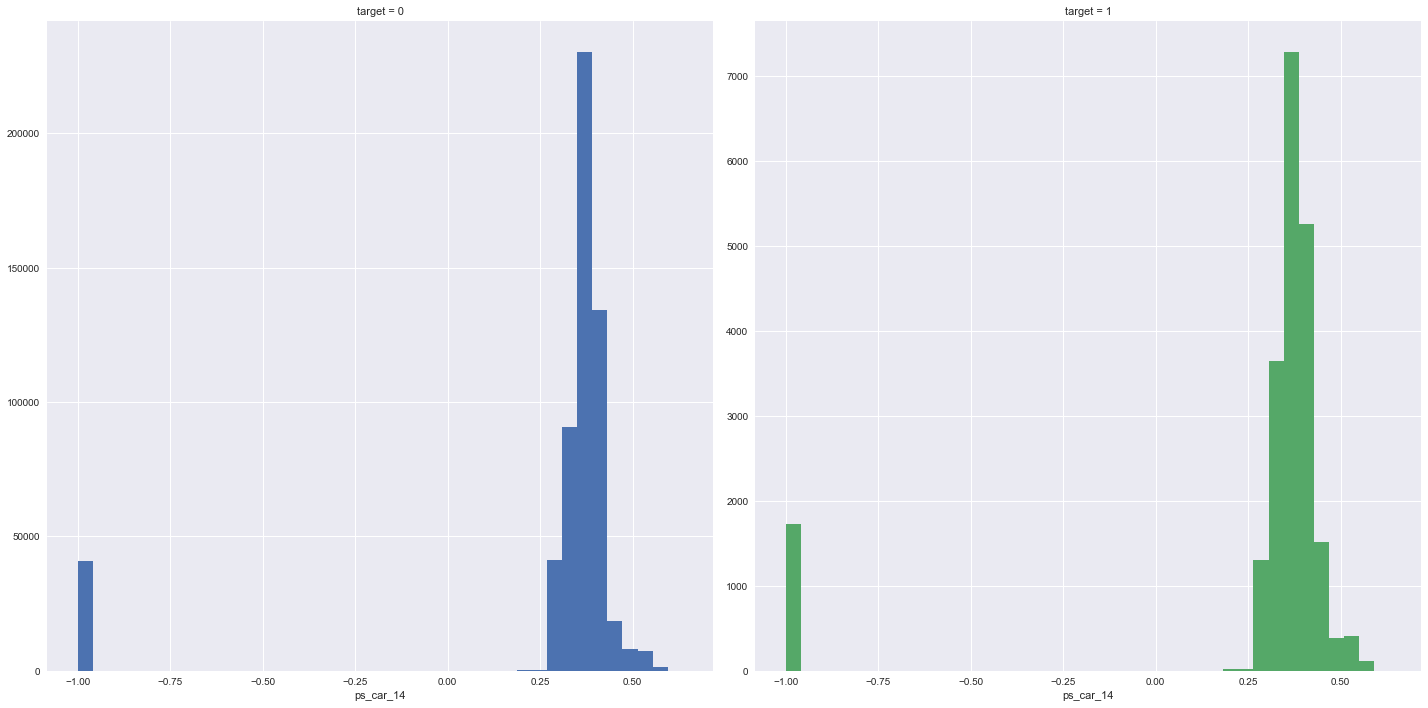

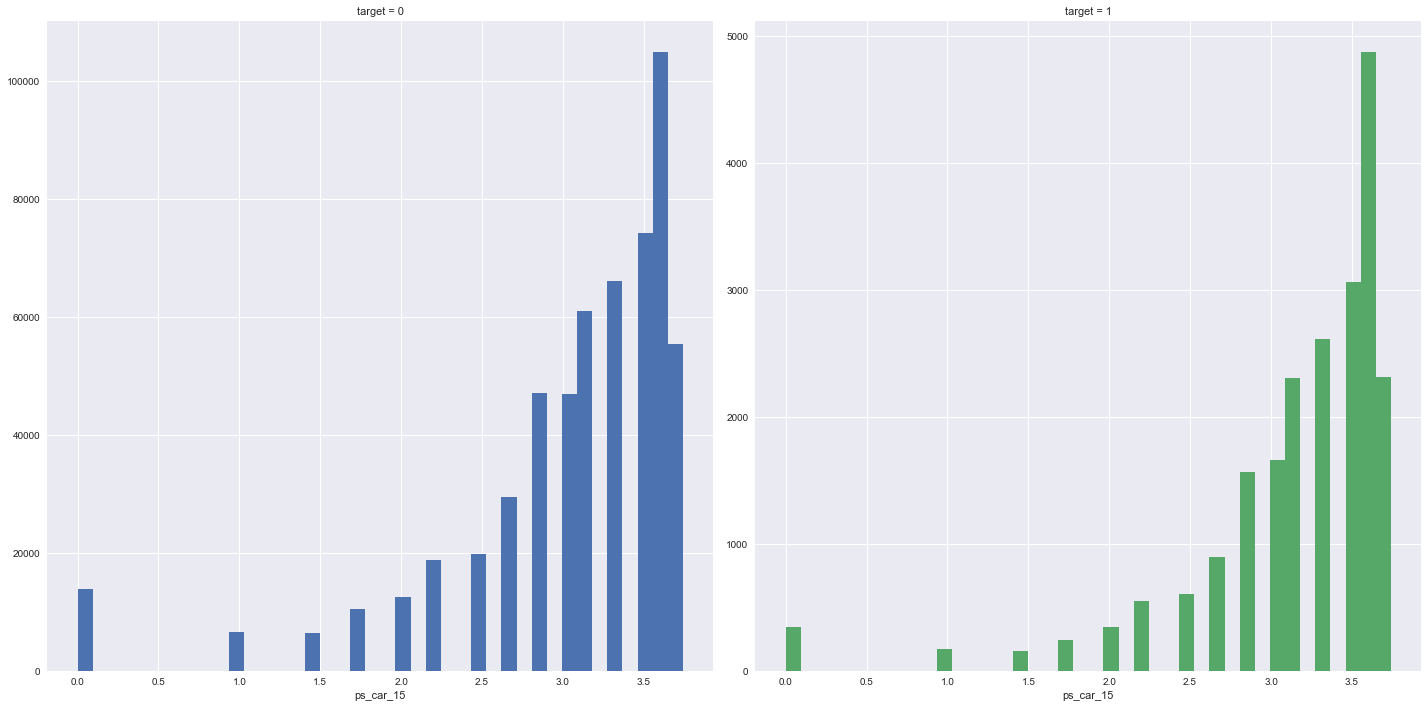

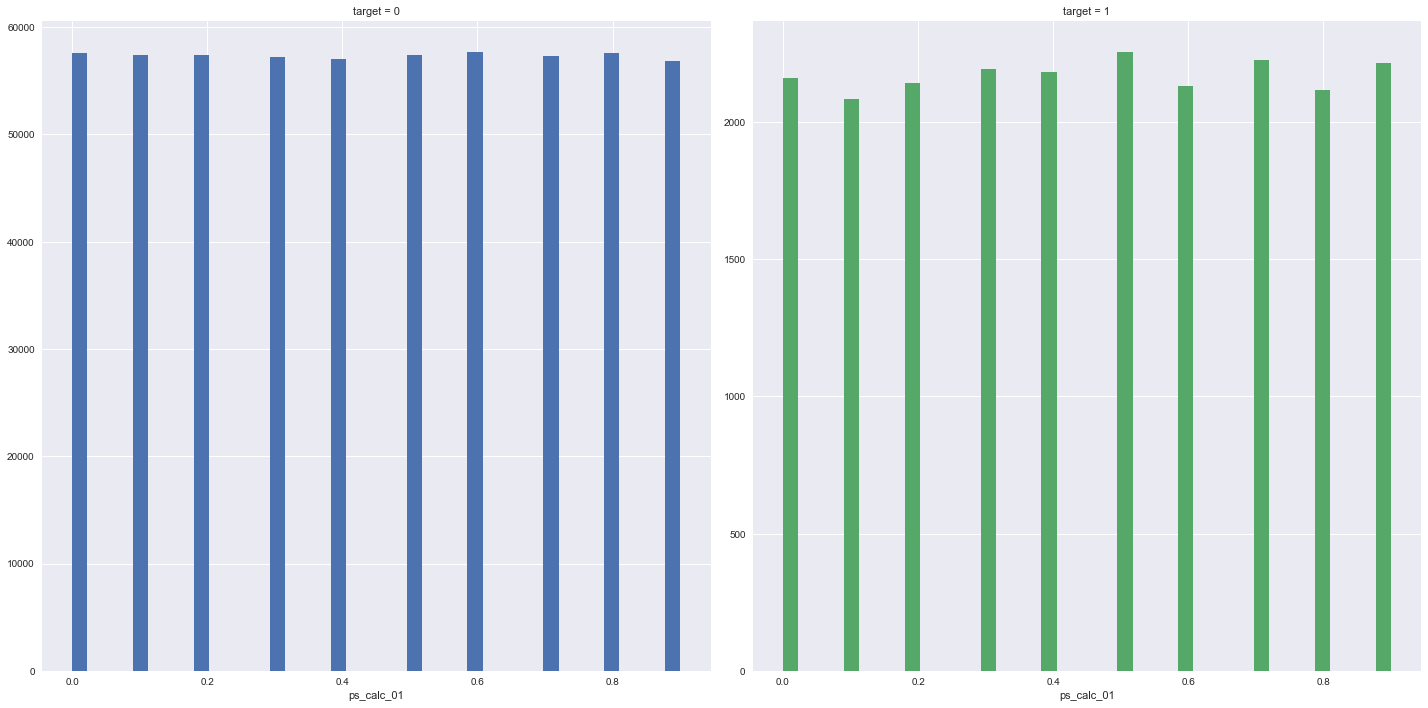

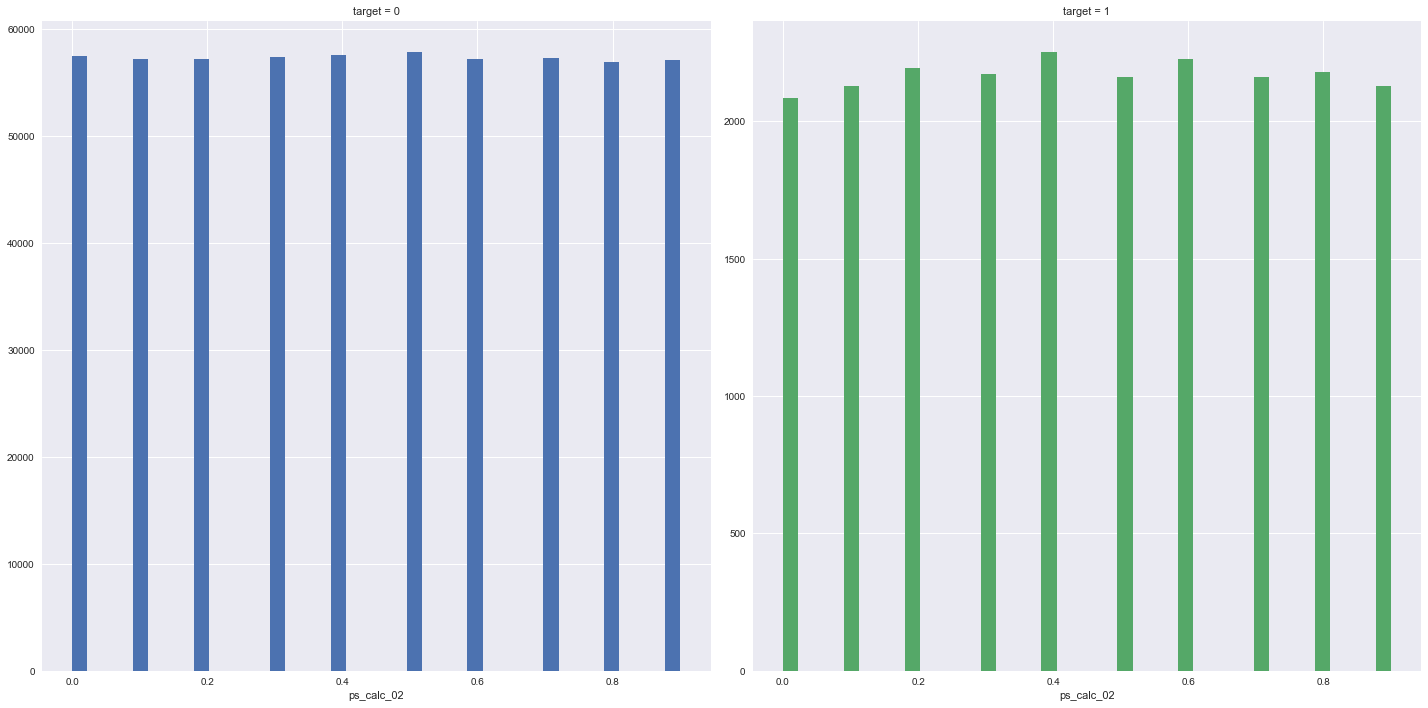

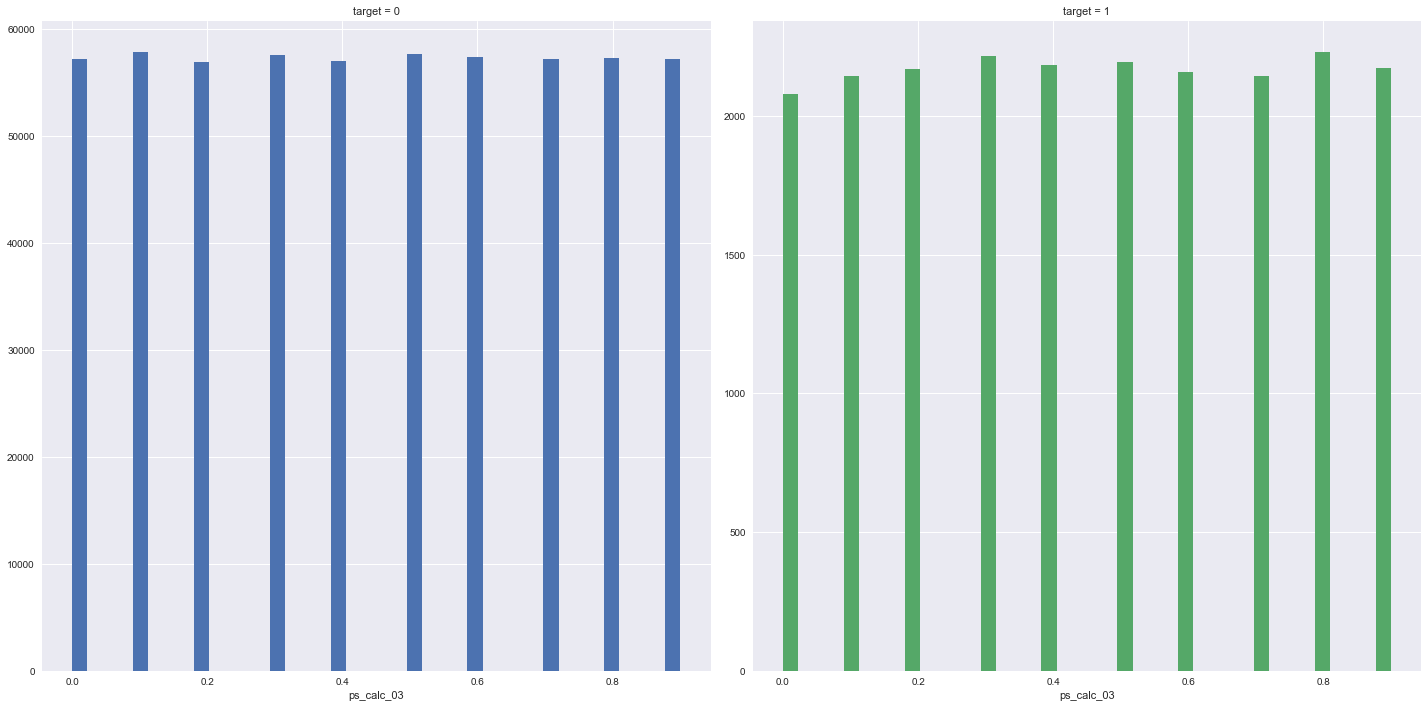

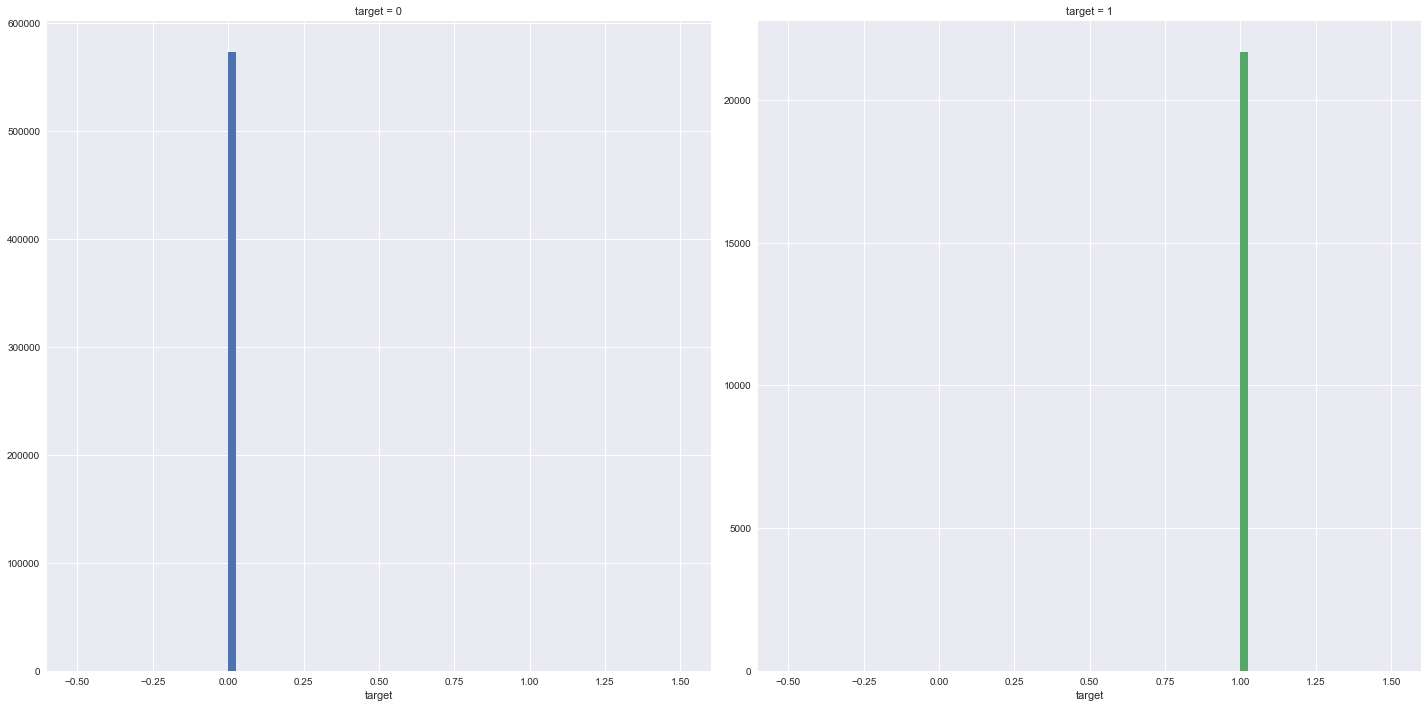

In [87]:
# produce histograms for all CONTINUOUS attributes 
for col in X_cont_y.columns:
    g=sns.FacetGrid(X_cont_y,col='target',hue='target',size=10,sharey=False)
    g.map(plt.hist,col,bins=40);

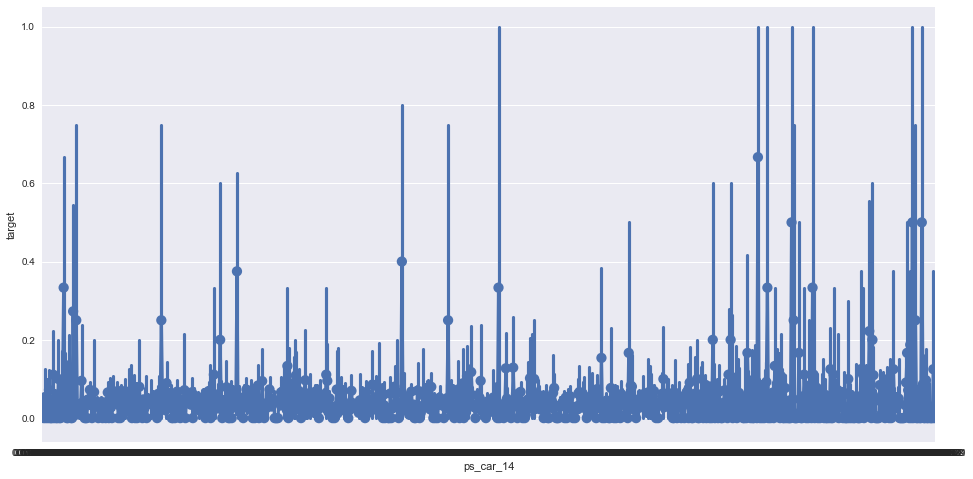

In [71]:
col='ps_car_14'
plt.figure(figsize=(16,8))
sns.pointplot(x=col,y='target',data=X_cont_y);

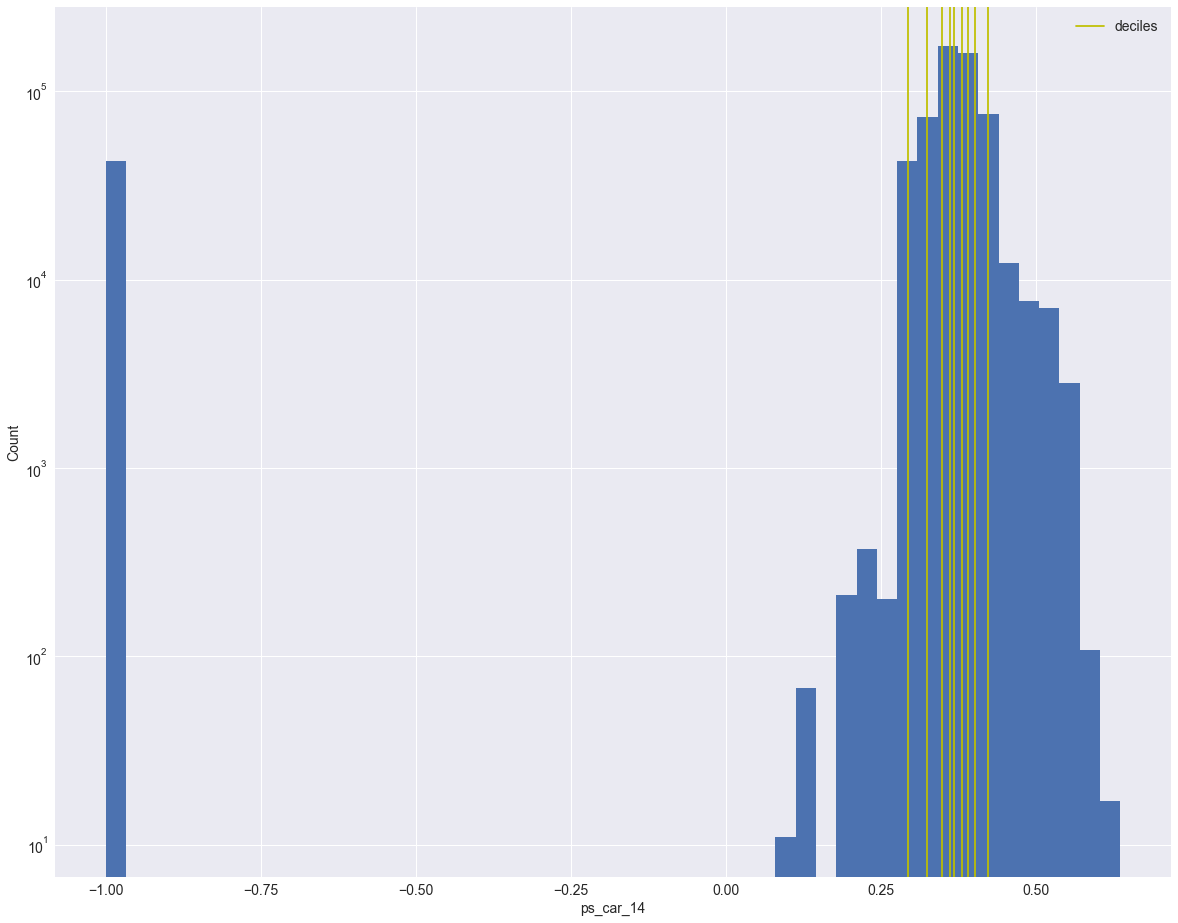

In [67]:
col='ps_car_14'
deciles=X_cont_y[col].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

#overlay deciles on histogram
fig,ax=plt.subplots(figsize=(20,16))
X_cont_y[col].hist(ax=ax,bins=50)
for pos in deciles:
    handle=plt.axvline(pos,color='y')
ax.legend([handle],['deciles'],fontsize=14)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel(col,fontsize=14)
ax.set_ylabel('Count',fontsize=14)
plt.show()

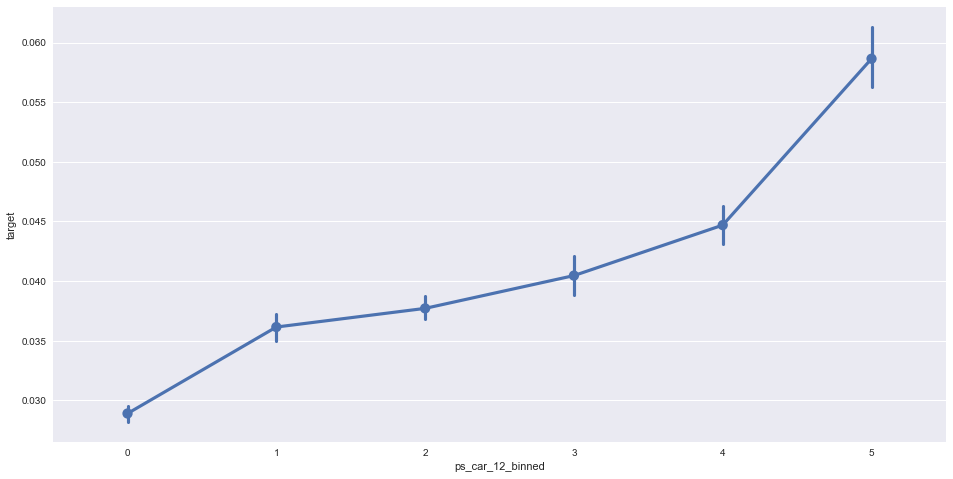

In [187]:
# qauntization
temp=X_cont_y.copy()
from_col='ps_car_12'
to_col='ps_car_12_binned'
temp[to_col]=pd.qcut(temp[from_col],10,labels=False,duplicates='drop')

# plot quantized continuous variable
plt.figure(figsize=(16,8))
sns.pointplot(x=to_col,y='target',data=temp);

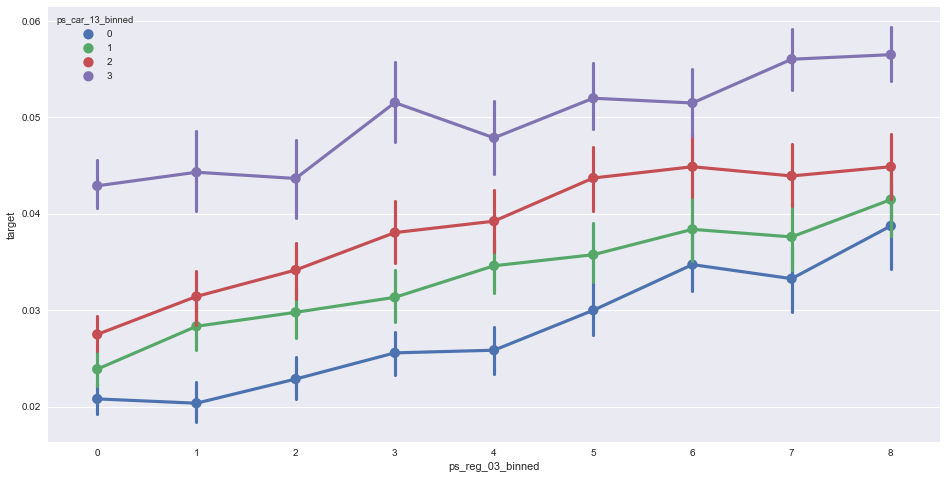

In [35]:
# qauntization
temp=X_cont_y.copy()
from_col='ps_reg_03'
to_col='ps_reg_03_binned'
temp[to_col]=pd.qcut(temp[from_col],10,labels=False,duplicates='drop')
from_col_2='ps_car_13'
to_col_2='ps_car_13_binned'
temp[to_col_2]=pd.qcut(temp[from_col_2],4,labels=False,duplicates='drop')

# interaction plot 
plt.figure(figsize=(16,8))
sns.pointplot(x=to_col,y='target',hue=to_col_2,data=temp);

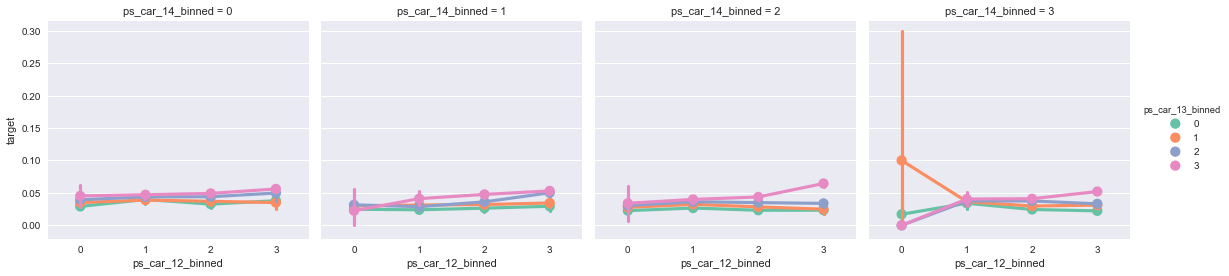

In [17]:
# qauntization
temp=X_cont_y.copy()
from_col='ps_car_12'
to_col='ps_car_12_binned'
temp[to_col]=pd.qcut(temp[from_col],4,labels=False,duplicates='drop')
from_col_2='ps_car_13'
to_col_2='ps_car_13_binned'
temp[to_col_2]=pd.qcut(temp[from_col_2],4,labels=False,duplicates='drop')
from_col_3='ps_car_14'
to_col_3='ps_car_14_binned'
temp[to_col_3]=pd.qcut(temp[from_col_3],4,labels=False,duplicates='drop')

# interaction plot 
sns.factorplot(x=to_col,y='target',col=to_col_3,hue=to_col_2,data=temp,kind='point',palette='Set2');

#### REG (REGION) Attributes

In [83]:
# product seaborn heatmap for REGION attributes
#plt.figure(figsize=(16,12))
#sns.heatmap(X_reg_y.corr(),cmap='Reds',annot=True,linewidths=0.1,linecolor='white');

In [ ]:
# produce seaborn pairplots for Regions attributes including target
#sns.pairplot(X_reg_y,hue='target',kind='reg',diag_kind='kde',markers='+',palette='husl',size=5);

In [ ]:
# produce seaborn heatmap for Ind and Reg attributes
#plt.figure(figsize=(24,20))
#sns.heatmap(X_ind_reg.corr(),cmap='Blues',annot=True,linewidths=0.1,linecolor='white');

#### CAR Attributes

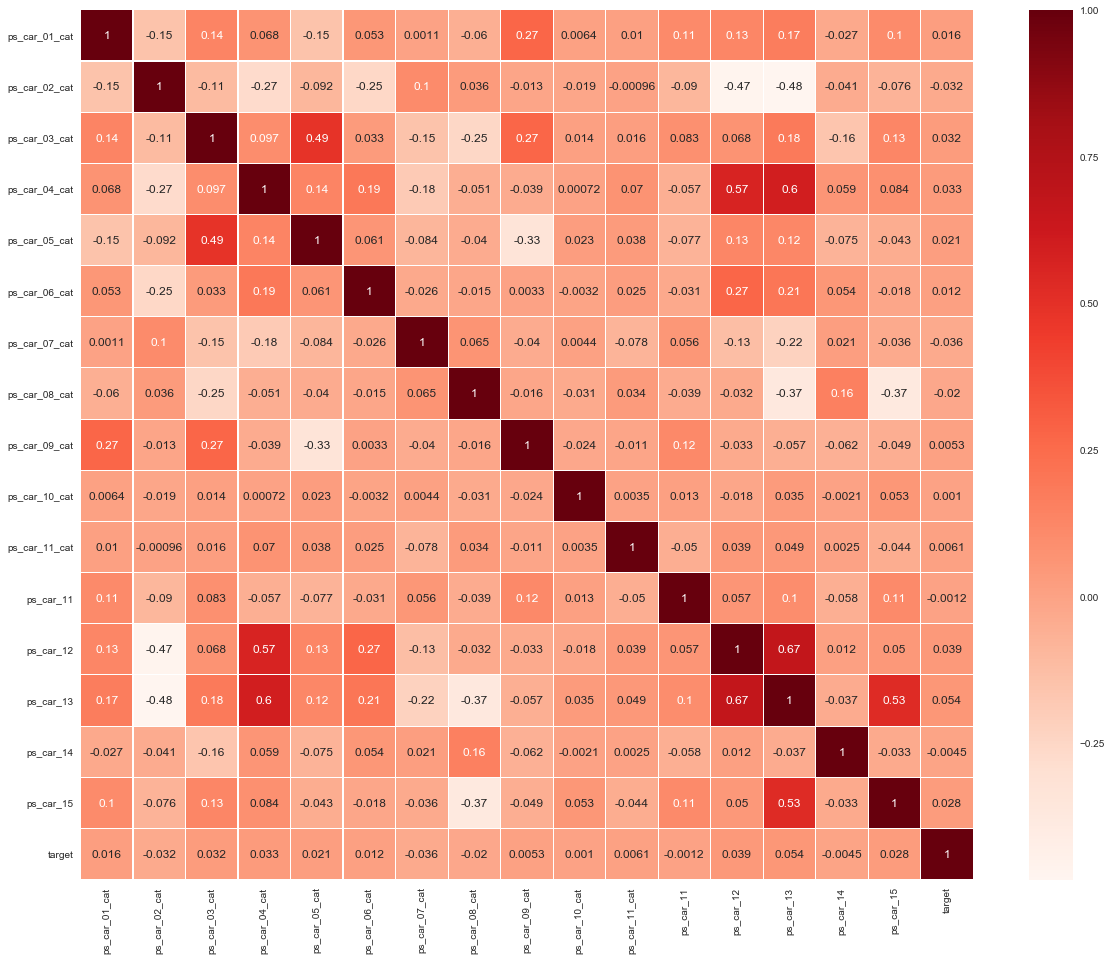

In [8]:
# produce seaborn heatmap for CAR attributes
plt.figure(figsize=(20,16))
sns.heatmap(X_car_y.corr(),cmap='Reds',annot=True,linewidths=0.1,linecolor='white');

In [ ]:
# produce seaborn heatmap for Ind and Car attributes
#plt.figure(figsize=(28,24))
#sns.heatmap(X_ind_car.corr(),cmap='Blues',annot=True,linewidths=0.1,linecolor='white');

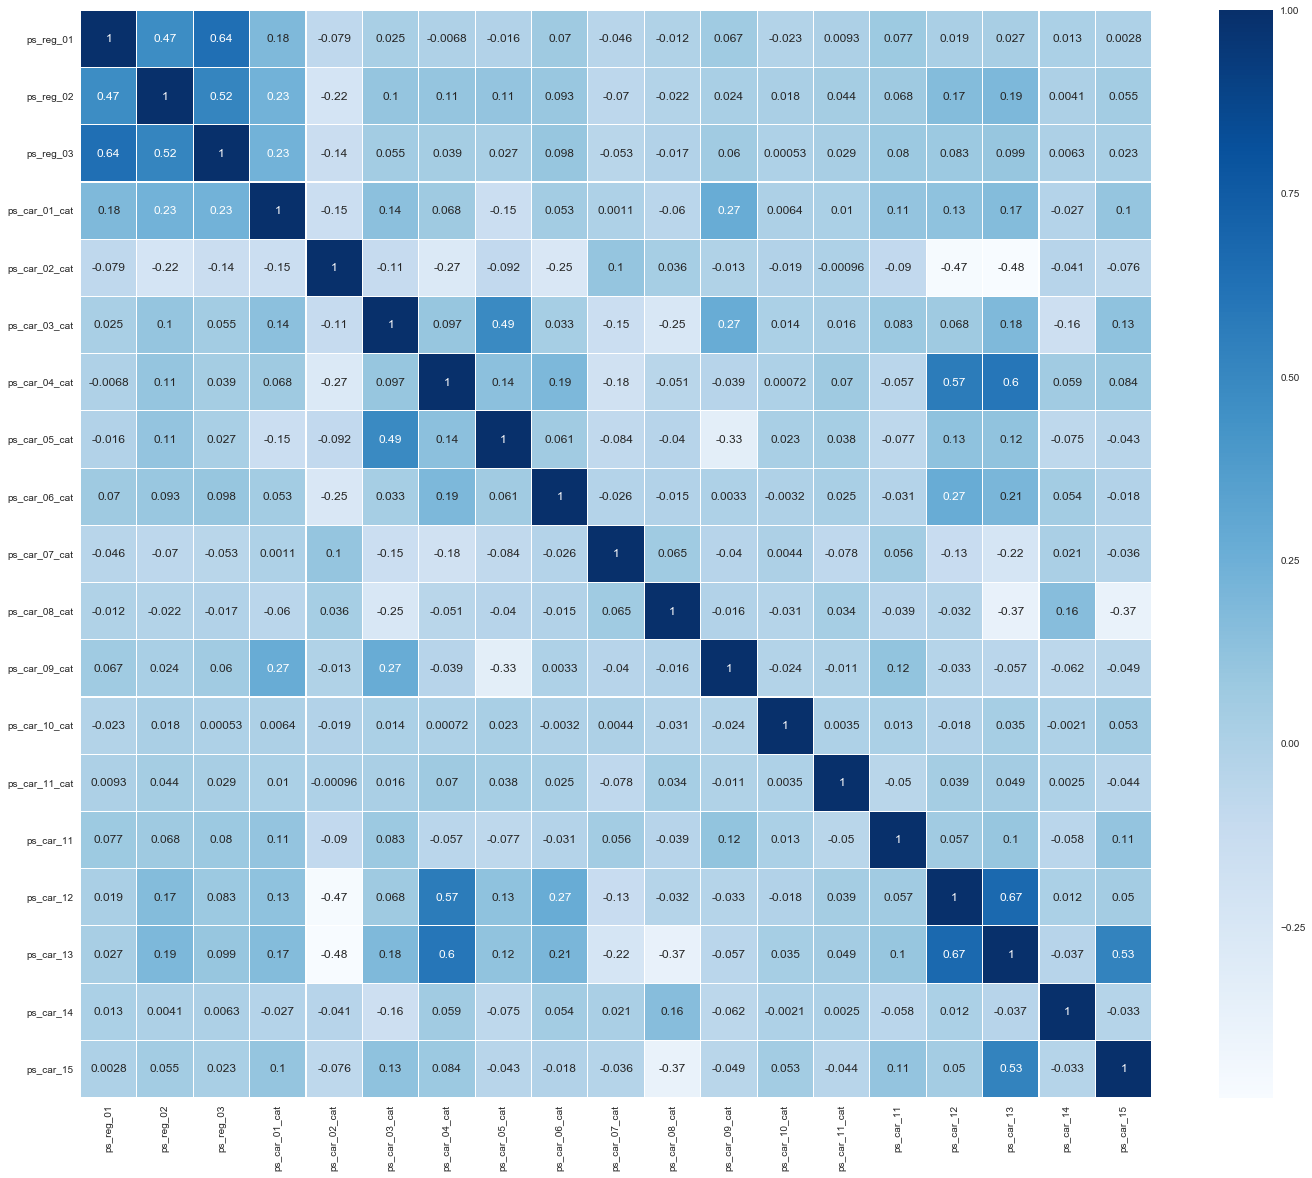

In [9]:
# produce seaborn heatmap for Car and Reg attributes
plt.figure(figsize=(24,20))
sns.heatmap(X_reg_car.corr(),cmap='Blues',annot=True,linewidths=0.1,linecolor='white');

In [10]:
#temp=X_car_y.replace(-1,np.nan).dropna(axis=0,how='any',subset=['ps_car_13','ps_car_12'])
temp=X_car_y

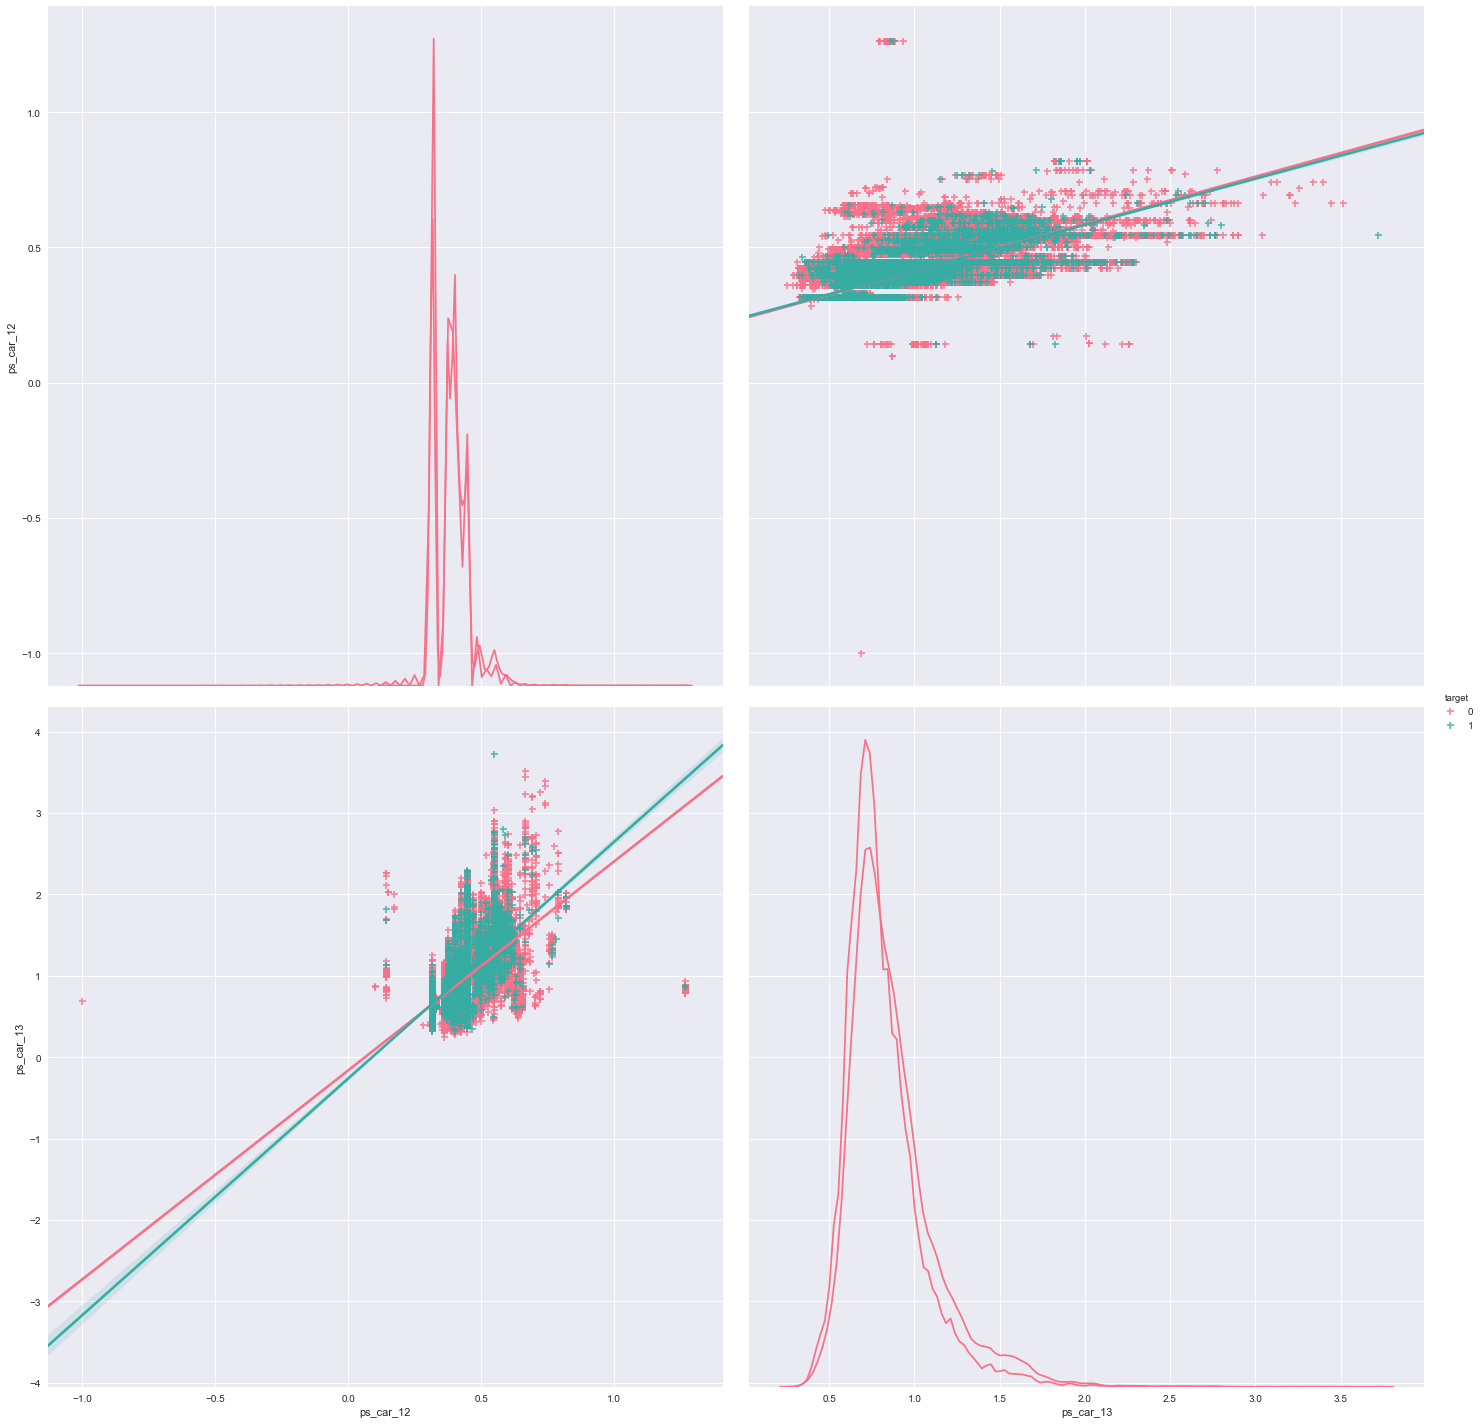

In [11]:
sns.pairplot(temp,vars=['ps_car_12','ps_car_13'],hue='target',kind='reg',diag_kind='kde',
             markers='+',palette='husl',size=10);

In [ ]:
sns.pairplot(X_car_y,vars=['ps_car_15','ps_car_13'],hue='target',kind='reg',diag_kind='kde',
             markers='+',palette='husl',size=10);

In [ ]:
sns.lmplot(x='ps_car_15',y='ps_car_13',hue='target',col='target',data=X_car_y,size=10,palette='husl');

In [ ]:
g=sns.FacetGrid(X_car_y,col='target',hue='target',size=10)
g.map(sns.stripplot,'ps_car_04_cat','ps_car_13',jitter=True,palette='husl');

In [ ]:
g=sns.FacetGrid(temp,col='target',hue='target',size=10)
g.map(sns.stripplot,'ps_car_04_cat','ps_car_12',jitter=True,palette='husl');

In [ ]:
#g=sns.FacetGrid(temp,col='target',hue='target',size=10)
#g.map(sns.stripplot,'ps_car_13','ps_car_15',jitter=True,palette='husl');

In [ ]:
sns.factorplot(x='ps_car_03_cat',hue='ps_car_05_cat',col='target',data=X_car_y,kind='count',
               size=10,palette='husl',sharey=False);

#### IND (INDIVIDUAL) Attributes

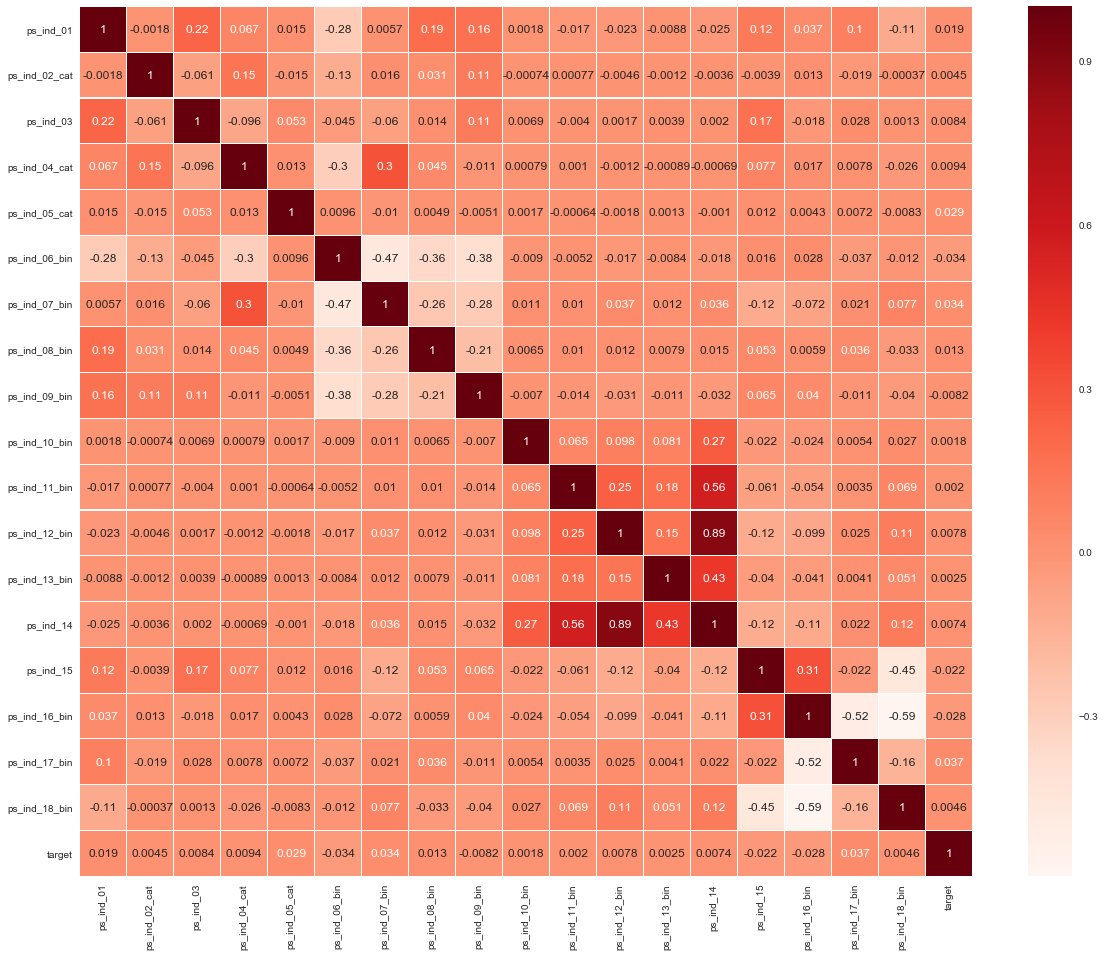

In [7]:
# produce seaborn heatmap for INDIVIDUAL attributes
plt.figure(figsize=(20,16))
sns.heatmap(X_ind_y.corr(),cmap='Reds',annot=True,linewidths=0.1,linecolor='white');

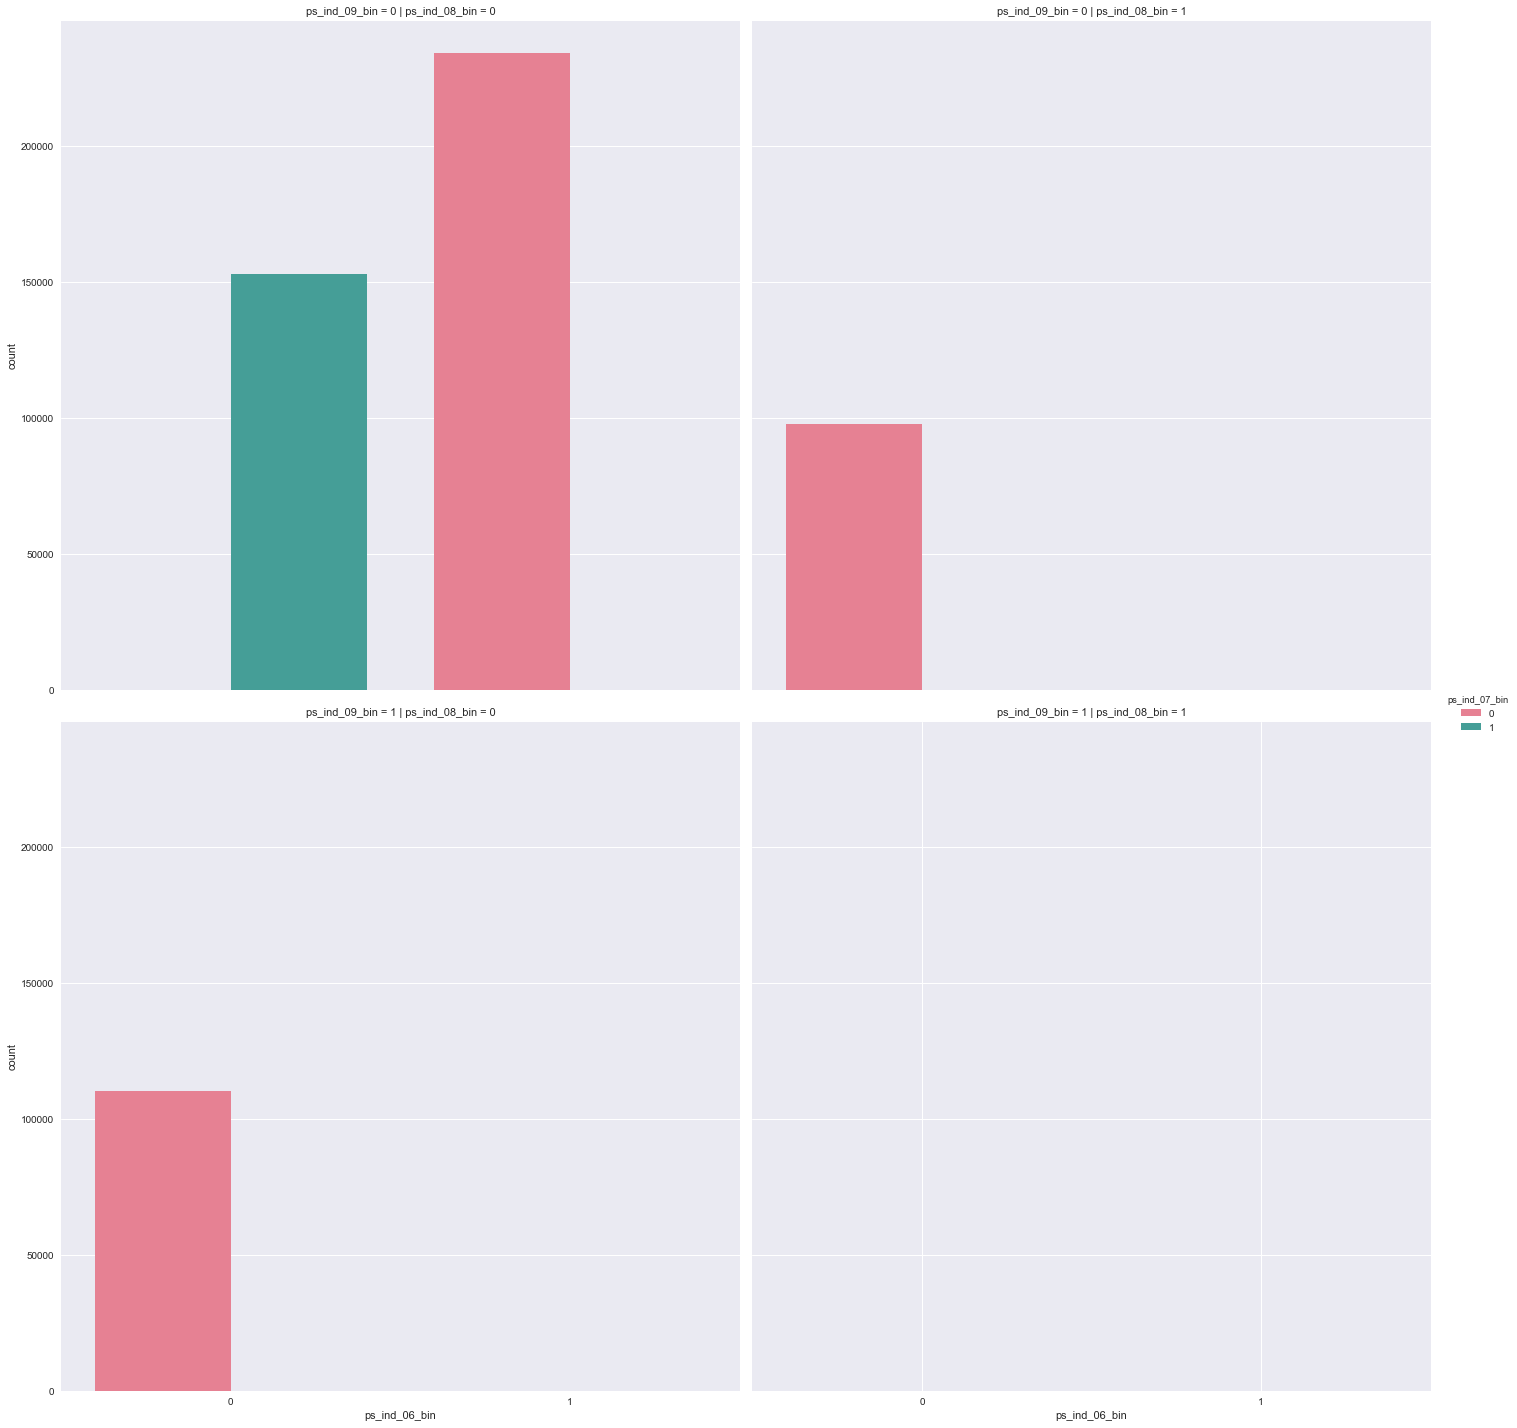

In [10]:
sns.factorplot(x='ps_ind_06_bin',hue='ps_ind_07_bin',col='ps_ind_08_bin',row='ps_ind_09_bin',data=X_ind_y,kind='count',
               size=10,palette='husl');

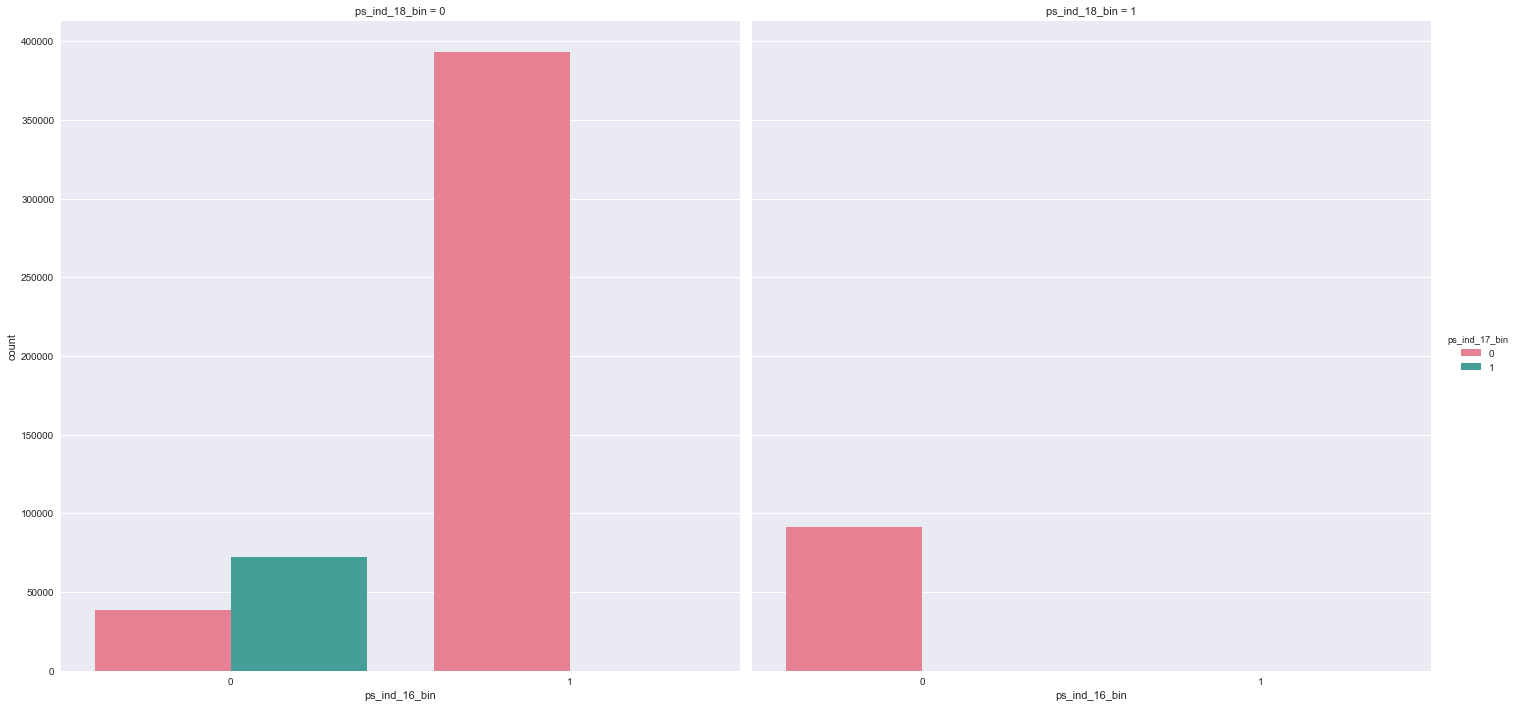

In [15]:
sns.factorplot(x='ps_ind_16_bin',hue='ps_ind_17_bin',col='ps_ind_18_bin',data=X_ind_y,kind='count',
               size=10,palette='husl');

In [ ]:
sns.lmplot(x='ps_ind_15',y='ps_ind_18_bin',data=X_ind,logistic=True,y_jitter=.03,size=10);

In [ ]:
#sns.lmplot(x='ps_ind_15',y='ps_ind_16_bin',data=X_ind,logistic=True,y_jitter=.03,size=10);

In [ ]:
temp=sns.pairplot(X_ind_y,vars=['ps_ind_15','ps_ind_16_bin','ps_ind_18_bin'],hue='target',kind='reg',diag_kind='kde',
             markers='+',palette='husl',size=5);

In [ ]:
sns.lmplot(x='ps_ind_14',y='ps_ind_12_bin',data=X_ind,logistic=True,y_jitter=.03,size=10);

In [ ]:
Counter((X_ind['ps_ind_14']))

#### CALC Attributes

In [82]:
# produce seaborn heatmap for '_calc_' attributes
#plt.figure(figsize=(20,16))
#sns.heatmap(X_calc_y.corr(),cmap='Greens',annot=True,linewidths=0.1,linecolor='white');